# Metadata

DS 5001 Final Project
Rachel Grace Treene, Eve Schoenrock & Connor Nickol

# Import & Set Up

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import nltk
import plotly_express as px
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
from gensim.models import word2vec
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

C:\Users\can2hr\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']

In [3]:
def importFiles(file_name):
    LINES = pd.DataFrame(open(file_name, 'r', encoding='utf-8-sig').readlines(), columns=['line_str'])
    LINES.index.name = 'line_num'
    LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()
    return LINES

In [4]:
LINES_1 = importFiles("Book1.txt")
LINES_2 = importFiles("Book2.txt")
LINES_3 = importFiles("Book3.txt")
LINES_4 = importFiles("Book4.txt")
LINES_5 = importFiles("Book5.txt")
LINES_6 = importFiles("Book6.txt")
LINES_7 = importFiles("Book7.txt")

In [5]:
title_1 = 'The Philosopher\'s Stone'
title_2 = 'The Chamber of Secrets'
title_3 = 'The Prisoner of Azkaban'
title_4 = 'The Goblet of Fire'
title_5 = 'The Order of the Phoenix'
title_6 = 'The Half Blood Prince'
title_7 = 'The Deathly Hallows'

## Clip Cruft

In [6]:
LINES_1 = LINES_1.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[5:]
LINES_2 = LINES_2.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[15:]
LINES_3 = LINES_3.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[5:]
LINES_4 = LINES_4.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[5:]
LINES_4 = LINES_4.replace(to_replace ='^\s*(?:Harry Potter and the Goblet of Fire)\s+(.*)', value = '', regex = True).loc[5:]
LINES_5 = LINES_5.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[11:]
LINES_6 = LINES_6.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[10:]
LINES_7 = LINES_7.replace(to_replace ='^\s*(?:Page\s\|)\s+(.*)', value = '', regex = True).loc[6:]

# Chunk by Chapter

## Function to chunk by chapter: `chunk_chaps`

Note that this function is specific to each book since chapter regex changes across books. Be sure to update regex accordingly here.

In [7]:
# function to find chapter chunks
def chunk_chaps(lines, chap_pat, book_num):
    '''
    This function will achieve chapter chunking automatically for each Harry Potter novel. The purpose of this function is to reduce code redundancy.
    
    INPUT:
        lines (dataframe) - dataframe of lines
        chap_pat (str) - chapter specific regex (chap_pat)
        book_num (int) - the Harry Potter series number (1-7); determines which chap_pat to continue with
    
    OUTPUT:
        chaps
    '''
    chap_lines = lines.line_str.str.match(chap_pat, case=True)
    
    # book specific regex
    if book_num == 1:
        # chap_pat = r"^\s*([A-Z\'\s]+|[A-Z\s]+)\s*$"
        a = lines.loc[chap_lines]
        a = a.drop([2394, 3124, 3127, 3147, 3182, 3196, 3197, 4990, 4992, 11155]) # 11155 because it's the second line of a chapter title - we don't want it to count as a standalone chapter title
        chap_titles = a.index.values.tolist()
    
    elif book_num == 2:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!,.-]')] # removes lines with digits, ?, !, ., and -
        a = a[~a["line_str"].str.endswith(('”', '.', '!', 'I'))] # removes lines ending with ", ., !, and I
        a = a.drop([1019, 2851, 2855, 4266, 6147, 10864])
        chap_titles = a.index.values.tolist()
        
    elif book_num == 3:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!.-;]')] # removes lines with digits, ?, !, ., and -
        a = a[~a["line_str"].str.endswith(('”', '.', '!', 'I', 'EMPLOYEE', 'PRIZE', 'OWN', 'YOU', 'LILY'))] # removes lines ending with these things
        a = a.drop([1723, 2373, 9413, 9718, 15425, 17183, 17598]) # last 3 are secondary title lines - remove these later for book 3
        chap_titles = a.index.values.tolist()
        
    elif book_num == 4:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!;]')] # removes lines with digits, ?, !, ., and ;
        a = a[~a["line_str"].str.endswith(('”', '.', '!', 'I', 'WORLD', 'STINKS', 'MISTAKE', 'POTTER', 'RIDDLE'))] # removes lines ending with these things
        a = a.drop([11945, 10281]) # drop last lines that shouldn't be selected
        chap_titles = a.index.values.tolist()
        
    elif book_num == 5:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!;]')] # removes lines with digits, ?, !, and ;
        a = a[~a["line_str"].str.endswith(('”', '.', '!'))] # removes lines ending with these things
        a = a.drop([917, 1217, 1501, 1582, 1845, 1953, 3363, 3732, 3733, 3767, 3778, 3786, 4795, 4796, 5595, 6121, 6122, 6123, 6351, 10217, 10220, 10859, 10862, 11342, 12554, 16329, 17413, 17415,
                   19937, 19999, 20033, 23057, 23059, 23274, 23290, 23306, 23354, 23400, 23402, 23404, 23445, 26539, 27598, 27604, 27615, 27658, 30990, 30994, 31091, 31093, 31337, 31350, 32915,
                   32917, 32918, 32920, 33059, 33071, 35479, 35492, 36452, 36459, 37320, 37358, 37399, 43685, 43686, 46209, 46858, 48039]) # drop last lines that shouldn't be selected
        chap_titles = a.index.values.tolist()
        
    elif book_num == 6:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!.;]')] # removes lines with digits, ?, !, ., and ;
        a = a[~a["line_str"].str.endswith(('”', '.', '!'))] # removes lines ending with these things
        a = a.drop([1924, 1997, 1999, 2001, 5046, 5447, 5714, 5718, 5719, 5721, 17672, 27286]) # drop last lines that shouldn't be selected
        chap_titles = a.index.values.tolist()
        
    elif book_num == 7:
        # chap_pat = r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$"
        # further specific regex required (remove lines ending with punctuation not indicative of chapter title)
        a = lines.loc[chap_lines] # has too many observations, but we can further pare these down
        a = a[~a['line_str'].str.contains(r'[\d?!.;]')] # removes lines with digits, ?, !, ., and ;
        a = a[~a["line_str"].str.endswith(('”', '.', '!'))] # removes lines ending with these things
        a = a.drop([766, 10376, 10378, 10877, 10878, 11262, 11263, 12346, 12487, 12532, 12534, 12538, 12540, 12611, 16481, 16484, 17597, 19978, 19984, 20328]) # drop last lines that shouldn't be selected
        chap_titles = a.index.values.tolist()
        
        
    # assign numbers to chapters
    lines.loc[chap_titles, 'chap_num'] = [i+1 for i in range(lines.loc[chap_titles].shape[0])]
    # forward fill chapter numbers
    lines.chap_num = lines.chap_num.ffill()
    # clean up
    lines = lines.drop(chap_titles)
    if book_num in {1, 3, 5, 7}: 
        if book_num == 1:
            addl_titles = [4215, 11155]
        if book_num == 3:
            addl_titles = [15425, 17183, 17598] # second title lines for 3 chapters in book 3
        if book_num == 5:
            addl_titles = [3363, 5595, 19937, 26539]
        if book_num == 7:
            addl_titles = [12346, 17597, 20328]
        lines = lines.drop(addl_titles) # drop additional title lines that were not caught before
    
    # Make big string for each chapter
    chaps = lines.groupby(OHCO[:1])\
        .line_str.apply(lambda x: '\n'.join(x))\
        .to_frame('chap_str')
    chaps['chap_str'] = chaps.chap_str.str.strip() # clip cruft from chap strings
    
    return a, chaps

## Book 1: Chunked by Chapter

In [8]:
chunk_chaps1 = chunk_chaps(LINES_1, r"^\s*([A-Z\'\s]+|[A-Z\s]+)\s*$", 1)

In [9]:
chaps1_titles = chunk_chaps1[0]
chaps1 = chunk_chaps1[1]

In [10]:
chaps1_titles

line_str
line_num                           
5                 THE BOY WHO LIVED
786              THE VANASHIG GLASS
1399        THE LETTERS FROM NO ONE
2124         THE KEEPER OF THE KEYS
2856                    DIAGON ALLY
4214      THE JOURNEY FROM PLATFORM
5515                THE SORTING HAT
6400             THE POTIONS MASTER
6952              THE MIDNIGHT DUEL
7964                      HALLOWEEN
8795                      QUIDDITCH
9456           THE MIRROR OF ERISED
10504               NICHOLAS FLAMBL
11154         NORBERT THE NORWEGIAN
11847          THE FORBIDDEN FOREST
12817          THROUGH THE TRAPDOOR
14168        THE MAN WITH TWO FACES

In [11]:
chaps1

chap_str
chap_num                                                   
1.0       Mr. and Mrs. Dursley, of number four, Privet D...
2.0       Nearly ten years had passed since the Dursleys...
3.0       The escape of the Brazilian boa constrictor ea...
4.0       BOOM. They knocked again. Dudley jerked awake....
5.0       Harry woke early the next morning. Although he...
6.0       Harry’s last month with the Dursleys wasn’t fu...
7.0       The door swung open at once. A tall, black-hai...
8.0       “There, look.”\n\n“Where?”\n\n“Next to the tal...
9.0       Harry had never believed he would meet a boy h...
10.0      Malfoy couldn’t believe his eyes when he saw t...
11.0      As they entered November, the weather turned v...
12.0      Christmas was coming. One morning in mid-\nDec...
13.0      Dumbledore had convinced Harry not to go looki...
14.0      Quirrell, however, must have been braver than ...
15.0      Things couldn’t have been worse.\n\nFilch took...
16.0      In years to come, Harry would never quite reme...
17.0      It was Quirrell.\n\n“You\” gasped Harry.\n\nQu...

## Book 2: Chunked by Chapter

In [12]:
chunk_chaps2 = chunk_chaps(LINES_2, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 2)

In [13]:
chaps2_title = chunk_chaps2[0]
chaps2 = chunk_chaps2[1]

In [14]:
chaps2_title

line_str
line_num                         
15             THE WORST BIRTHDAY
523               DOBBY’S WARNING
1134                   THE BURROW
2017       AT FLOURISH AND BLOTTS
3116          THE WHOMPING WILLOW
4155            GILDEROY LOCKHART
5036        MUDBLOODS AND MURMURS
5919           THE DEATHDAY PARTY
6815      THE WRITING ON THE WALL
7887            THE ROGUE BLUDGER
8888             THE DUELING CLUB
10045       THE POLY JUICE POTION
11111       THE VERY SECRET DIARY
12176             CORNELIUS FUDGE
12958                      ARAGOG
13839      THE CHAMBER OF SECRETS
14987       THE HEIR OF SLYTHERIN
16010              DOBBY’S REWARD

In [15]:
chaps2

chap_str
chap_num                                                   
1.0       Not for the first time, an argument had broken...
2.0       Harry managed not to shout out, but it was a c...
3.0       “Ron\” breathed Harry, creeping to the window ...
4.0       Life at the Burrow was as different as possibl...
5.0       The end of the summer vacation came too quickl...
6.0       The next day, however, Harry barely grinned on...
7.0       Harry spent a lot of time over the next few da...
8.0       October arrived, spreading a damp chill over t...
9.0       “What’s going on here? What’s going on?”\n\nAt...
10.0      Since the disastrous episode of the pixies, Pr...
11.0      Harry woke up on Sunday morning to find the\nd...
12.0      They stepped off the stone staircase at the to...
13.0      Hermione remained in the hospital wing for sev...
14.0      Harry, Ron, and Hermione had always known that...
15.0      Summer was creeping over the grounds around th...
16.0      All those times we were in that bathroom, and ...
17.0      He was standing at the end of a very long, dim...
18.0      For a moment there was silence as Harry, Ron,\...

## Book 3: Chunked by Chapter

In [16]:
chunk_chaps3 = chunk_chaps(LINES_3, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 3)

In [17]:
chaps3_title = chunk_chaps3[0]
chaps3 = chunk_chaps3[1]

In [18]:
chaps3_title # some chapter titles span 2 lines - we dropped the second line & when dropping chapter titles from lines we also remove the second line of title

line_str
line_num                               
5                              OWL POST
677            AUNT MARGE’S BIG MISTAKE
1416                     THE KNIGHT BUS
2280                 THE LEAKY CAULDRON
3262                       THE DEMENTOR
4599              TALONS AND TEA LEAVES
5928        THE BOGGART IN THE WARDROBE
6822             FLIGHT OF THE FAT LADY
7871                        GRIM DEFEAT
8932                 THE MARAUDER’S MAP
10284                      THE FIREBOLT
11401                      THE PATRONUS
12370       GRYFFINDOR VERSUS RAVENCLAW
13206                    SNAPE’S GRUDGE
14326               THE QUIDDITCH FINAL
15424             PROFESSOR TRELAWNEY’S
16309                 CAT, RAT, AND DOG
17181     MOONY, WORMTAIL, PADFOOT, AND
17597               THE SERVANT OF LORD
18582               THE DEMENTOR’S KISS
18978                 HERMIONE’S SECRET
20550                    OWL POST AGAIN

In [19]:
chaps3 # chapter 3 strings outputted

chap_str
chap_num                                                   
1.0       Harry Potter was a highly unusual boy in many ...
2.0       Harry went down to breakfast the next morning ...
3.0       Harry was several streets away before he colla...
4.0       It took Harry several days to get used to his ...
5.0       Tom woke Harry the next morning with his usual...
6.0       When Harry, Ron, and Hermione entered the Grea...
7.0       Malfoy didn’t reappear in classes until late o...
8.0       In no time at all, Defense Against the Dark Ar...
9.0       Professor Dumbledore sent all the Gryffindors ...
10.0      Madam Pomfrey insisted on keeping Harry in the...
11.0      Harry didn’t have a very clear idea of how he ...
12.0      Harry knew that Hermione had meant well, but t...
13.0      It looked like the end of Ron and Hermione’s\n...
14.0      No one in Gryffindor Tower slept that night. T...
15.0      “He — he sent me this,” Hermione said, holding...
16.0      Harry’s euphoria at finally winning the Quiddi...
17.0      Harry’s mind had gone blank with shock. The th...
18.0      It took a few seconds for the absurdity of thi...
19.0      Hermione screamed. Black leapt to his feet. Ha...
20.0      Harry had never been part of a stranger group....
21.0      “Shocking business ... shocking ... miracle no...
22.0      “Harry!”\n\nHermione was tugging at his sleeve...

## Book 4: Chunked by Chapter

In [20]:
chunk_chaps4 = chunk_chaps(LINES_4, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 4)

In [21]:
chaps4_title = chunk_chaps4[0]
chaps4 = chunk_chaps4[1]

In [22]:
chaps4_title

line_str
line_num                                
5                       THE RIDDLE HOUSE
766                             THE SCAR
1243                      THE INVITATION
1857                  BACK TO THE BURROW
2497            WEASLEYS’ WIZARD WHEEZES
3223                         THE PORTKEY
3715                   BAGMAN AND CROUCH
4753             THE QUIDDITCH WORLD CUP
5854                       THE DARK MARK
7296              MAYHEM AT THE MINISTRY
7964         ABOARD THE HOGWARTS EXPRESS
8664            THE TRIWIZARD TOURNAMENT
9756                       MAD-EYE MOODY
10616            THE UNFORGIVABLE CURSES
11613         BEAUXBATONS AND DRUMSTRANG
12624                 THE GOBLET OF FIRE
13840                 THE FOUR CHAMPIONS
14668          THE WEIGHING OF THE WANDS
15975             THE HUNGARIAN HORNTAIL
17142                     THE FIRST TASK
18467     THE HOUSE-ELF LIBERATION FRONT
19577                THE UNEXPECTED TASK
20504                      THE YULE BALL
22099               RITA SKEBTER’S SCOOP
23361                THE EGG AND THE EYE
24464                    THE SECOND TASK
25960                    PADFOOT RETURNS
27303          THE MADNESS OF MR. CROUCH
28842                          THE DREAM
29739                       THE PENSIEVE
30996                     THE THIRD TASK
32503             FLESH, BLOOD, AND BONE
32896                   THE DEATH EATERS
33633                  PRIORI INCANTATEM
34173                        VERITASERUM
35295            THE PARTING OF THE WAYS
36503                      THE BEGINNING

In [23]:
chaps4

chap_str
chap_num                                                   
1.0       The villagers of Little Hangleton still called...
2.0       Harry lay flat on his back, breathing hard as ...
3.0       By the time Harry arrived in the kitchen, the ...
4.0       By twelve o’clock the next day, Harry’s school...
5.0       Harry spun faster and faster, elbows tucked ti...
6.0       Harry felt as though he had barely lain down t...
7.0       Harry disentangled himself from Ron and got to...
8.0       Clutching their purchases, Mr. Weasley in the ...
9.0       “ Don’t tell your mother you’ve been gambling,...
10.0      Mr. Weasley woke them after only a few hours s...
11.0      There was a definite end-of-the-holidays gloom...
12.0      Through the gates, flanked with statues of win...
13.0      The storm had blown itself out by the followin...
14.0      The next two days passed without great inciden...
15.0      Early next morning, Harry woke with a plan ful...
16.0      “I don’t believe it!” Ron said, in a stunned v...
17.0      Harry sat there, aware that every head in the ...
18.0      When Harry woke up on Sunday morning, it took ...
19.0      The prospect of talking face-to-face with Siri...
20.0      Harry got up on Sunday morning and dressed so\...
21.0      Harry, Ron, and Hermione went up to the Owlery...
22.0      “Potter! Weasley! Will you pay attention?”\n\n...
23.0      Despite the very heavy load of homework that t...
24.0      Everybody got up late on Boxing Day. The Gryff...
25.0      As Harry had no idea how long a bath he would ...
26.0      “You said you’d already worked out that egg cl...
27.0      One of the best things about the aftermath of ...
28.0      Harry, Ron, and Hermione went up to the Owlery...
29.0      “It comes down to this,” said Hermione, rubbin...
30.0      The door of the office opened.\n\n“Hello, Pott...
31.0      “Dumbledore reckons You- Know- Who’s getting\n...
32.0      Harry felt his feet slam into the ground; his ...
33.0      Voldemort looked away from Harry and began\nex...
34.0      Wormtail approached Harry, who scrambled to fi...
35.0      Harry felt himself slam flat into the ground; ...
36.0      Dumbledore stood up. He stared down at Barty\n...
37.0      When he looked back, even a month later, Harry...

## Book 5: Chunked by Chapter

In [24]:
chap_lines = LINES_5.line_str.str.match(r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", case=True)
a = LINES_5.loc[chap_lines] # has too many observations, but we can further pare these down
a = a[~a['line_str'].str.contains(r'[\d?!;]')] # removes lines with digits, ?, !, and ;
a = a[~a["line_str"].str.endswith(('”', '.', '!'))] # removes lines ending with these things
a = a.drop([917, 1217, 1501, 1582, 1845, 1953, 3363, 3732, 3733, 3767, 3778, 3786, 4795, 4796, 5595, 6121, 6122, 6123, 6351, 10217, 10220, 10859, 10862, 11342, 12554, 16329, 17413, 17415,
                   19937, 19999, 20033, 23057, 23059, 23274, 23290, 23306, 23354, 23400, 23402, 23404, 23445, 26539, 27598, 27604, 27615, 27658, 30990, 30994, 31091, 31093, 31337, 31350, 32915,
                   32917, 32918, 32920, 33059, 33071, 35479, 35492, 36452, 36459, 37320, 37358, 37399, 43685, 43686, 46209, 46858, 48039]) # drop last lines that shouldn't be selected
chap_titles = a.index.values.tolist()

In [25]:
a

line_str
line_num                              
12                     DUDLEY DEMENTED
1082                    A PECK OF OWLS
2348                THE ADVANCED GUARD
3362          NUMBER TWELVE, GRIMMAULD
4521          THE ORDER OF THE PHOENIX
5594        THE NOBLE AND MOST ANCIENT
6881             THE MINISTRY OF MAGIC
7768                       THE HEARING
8608          THE WOES OF MRS. WEASLEY
10188                    LUNA LOVEGOOD
11347       THE SORTING HAT’S NEW SONG
12501               PROFESSOR UMBRIDGE
14209           DETENTION WITH DOLORES
15846                PERCY AND PADFOOT
17402     THE HOGWARTS HIGH INQUISITOR
18798                IN THE HOG’S HEAD
19936        EDUCATIONAL DECREE NUMBER
21277                DUMBLEDORE’S ARMY
22656         THE LION AND THE SERPENT
23916                    HAGRID’S TALE
25136             THE EYE OF THE SNAKE
26538         ST. MUNGO’S HOSPITAL FOR
28015     CHRISTMAS ON THE CLOSED WARD
29395                       OCCLUMENCY
30936                THE BEETLE AT BAY
32417              SEEN AND UNFORESEEN
34020        THE CENTAUR AND THE SNEAK
35475             SNAPE’S WORST MEMORY
37029                    CAREER ADVICE
38498                            GRAWP
40040                          O.W.L.S
41461                  OUT OF THE FIRE
42693                 FIGHT AND FLIGHT
43457      THE DEPARTMENT OF MYSTERIES
44442                  BEYOND THE VEIL
45933      THE ONLY ONE HE EVER FEARED
46636                THE LOST PROPHECY
48037            THE SECOND WAR BEGINS

In [26]:
chunk_chaps5 = chunk_chaps(LINES_5, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 5)

In [27]:
chaps5_title = chunk_chaps5[0]
chaps5 = chunk_chaps5[1]

In [28]:
chaps5_title

line_str
line_num                              
12                     DUDLEY DEMENTED
1082                    A PECK OF OWLS
2348                THE ADVANCED GUARD
3362          NUMBER TWELVE, GRIMMAULD
4521          THE ORDER OF THE PHOENIX
5594        THE NOBLE AND MOST ANCIENT
6881             THE MINISTRY OF MAGIC
7768                       THE HEARING
8608          THE WOES OF MRS. WEASLEY
10188                    LUNA LOVEGOOD
11347       THE SORTING HAT’S NEW SONG
12501               PROFESSOR UMBRIDGE
14209           DETENTION WITH DOLORES
15846                PERCY AND PADFOOT
17402     THE HOGWARTS HIGH INQUISITOR
18798                IN THE HOG’S HEAD
19936        EDUCATIONAL DECREE NUMBER
21277                DUMBLEDORE’S ARMY
22656         THE LION AND THE SERPENT
23916                    HAGRID’S TALE
25136             THE EYE OF THE SNAKE
26538         ST. MUNGO’S HOSPITAL FOR
28015     CHRISTMAS ON THE CLOSED WARD
29395                       OCCLUMENCY
30936                THE BEETLE AT BAY
32417              SEEN AND UNFORESEEN
34020        THE CENTAUR AND THE SNEAK
35475             SNAPE’S WORST MEMORY
37029                    CAREER ADVICE
38498                            GRAWP
40040                          O.W.L.S
41461                  OUT OF THE FIRE
42693                 FIGHT AND FLIGHT
43457      THE DEPARTMENT OF MYSTERIES
44442                  BEYOND THE VEIL
45933      THE ONLY ONE HE EVER FEARED
46636                THE LOST PROPHECY
48037            THE SECOND WAR BEGINS

In [29]:
chaps5

chap_str
chap_num                                                   
1.0       The hottest day of the summer so far was drawi...
2.0       “What?” said Harry blankly.\n\n“He left!” said...
3.0       “Fve just been attacked by dementors and I mig...
4.0       “What’s the Order of the — ?” Harry began.\n\n...
5.0       “Your — ?”\n\n“My dear old mum, yeah,” said Si...
6.0       Mrs. Weasley followed them upstairs looking gr...
7.0       Harry awoke at half-past five the next morning...
8.0       Harry gasped; he could not help himself. The l...
9.0       Dumbledore’s abrupt departure took Harry\ncomp...
10.0      Harry had a troubled night’s sleep. His parent...
11.0      Harry did not want to tell the others that he ...
12.0      Seamus dressed at top speed next morning and l...
13.0      Dinner in the Great Hall that night was not a ...
14.0      Harry was the first to awake in his dormitory ...
15.0      They had expected to have to comb Hermione’s D...
16.0      Hermione made no mention of Harry giving Defen...
17.0      Harry felt happier for the rest of the weekend...
18.0      “Umbridge has been reading your mail, Harry. T...
19.0      Harry felt as though he were carrying some kin...
20.0      Harry sprinted up to the boys’ dormitory to fe...
21.0      Hermione plowed her way back to Hagrid’s cabin...
22.0      Harry was so relieved that she was taking him\...
23.0      Was this why Dumbledore would no longer meet\n...
24.0      Kreacher, it transpired, had been lurking in t...
25.0      Harry’s question was answered the very next\nm...
26.0      Luna said vaguely that she did not know how so...
27.0      “I’ll bet you wish you hadn’t given up Divinat...
28.0      — BY ORDER OF —\n\nTHE MINISTRY OF MAGIC\n\nDo...
29.0      “But why haven’t you got Occlumency lessons\na...
30.0      The story of Fred and George’s flight to freed...
31.0      Ron’s euphoria at helping Gryffindor scrape th...
32.0      “I’m not going... I don’t need the hospital wi...
33.0      Harry had no idea what Hermione was planning, ...
34.0      Harry wound his hand tightly into the mane of ...
35.0      Black shapes were emerging out of thin air all...
36.0      “He hasn’t gone!” Harry yelled.\n\nHe did not ...
37.0      Harry’s feet hit solid ground again; his knees...
38.0      HE-WHO-MUST-NOT-BE-NAMED RETURNS\n\nIn a brief...

## Book 6: Chunked by Chapter

In [30]:
chunk_chaps6 = chunk_chaps(LINES_6, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 6)

In [31]:
chaps6_title = chunk_chaps6[0]
chaps6 = chunk_chaps6[1]

In [32]:
chaps6_title

line_str
line_num                            
10                THE OTHER MINISTER
920                    SPINNER’S END
1862                  WILL AND WON’T
2739                 HORACE SLUGHORN
3936             AN EXCESS OF PHLEGM
5170                  DRACO’S DETOUR
6352                   THE SLUG CLUB
7643                SNAPE VICTORIOUS
8443           THE HALF-BLOOD PRINCE
9587              THE HOUSE OF GAUNT
10738        HERMIONE’S HELPING HAND
11698               SILVER AND OPALS
12777              THE SECRET RIDDLE
13826                  FELIX FELICIS
15044            THE UNBREAKABLE VOW
16190        A VERY FROSTY CHRISTMAS
17399              A SLUGGISH MEMORY
18619             BIRTHDAY SURPRISES
19888                      ELF TAILS
21088       LORD VOLDEMORT’S REQUEST
22289            THE UNKNOWABLE ROOM
23360               AFTER THE BURIAL
24506                      HORCRUXES
25531                   SECTUMSEMPRA
26598             THE SEER OVERHEARD
27651                       THE CAVE
28864     THE LIGHTNING-STRUCK TOWER
29749           FLIGHT OF THE PRINCE
30400             THE PHOENIX LAMENT
31459                 THE WHITE TOMB

In [33]:
chaps6

chap_str
chap_num                                                   
1.0       It was nearing midnight and the Prime Minister...
2.0       Many miles away the chilly mist that had press...
3.0       Harry Potter was snoring loudly. He had been s...
4.0       Despite the fact that he had spent every wakin...
5.0       Harry and Dumbledore approached the back door ...
6.0       Harry remained within the confines of the Burr...
7.0       Harry spent a lot of the last week of the holi...
8.0       Harry could not move a muscle. He lay there be...
9.0       Harry and Ron met Hermione in the common room\...
10.0      For the rest of the week’s Potions lessons Har...
11.0      As Hermione had predicted, the sixth years’ fr...
12.0      Where was Dumbledore, and what was he doing?\n...
13.0      Katie was removed to St. Mungo’s Hospital for\...
14.0      Harry had Herbology first thing the following\...
15.0      Snow was swirling against the icy windows once...
16.0      “So Snape was offering to help him? He was def...
17.0      Late in the afternoon, a few days after New Ye...
18.0      The next day Harry confided in both Ron and\nH...
19.0      “So, all in all, not one of Ron’s better birth...
20.0      Harry and Ron left the hospital wing first thi...
21.0      Harry wracked his brains over the next week as...
22.0      Patches of bright blue sky were beginning to a...
23.0      Harry could feel the Felix Felicis wearing off...
24.0      Exhausted but delighted with his night’s work,...
25.0      The fact that Harry Potter was going out with ...
26.0      Harry could smell salt and hear rushing waves;...
27.0      Once back under the starry sky, Harry heaved\n...
28.0      Harry felt as though he too were hurtling thro...
29.0      “C’mere, Harry ...”\n\n“No.”\n\n“Yeh can’ stay...
30.0      All lessons were suspended, all examinations\n...

## Book 7: Chunked by Chapter

In [34]:
chunk_chaps7 = chunk_chaps(LINES_7, r"^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$", 7)

In [35]:
chaps7_title = chunk_chaps7[0]
chaps7 = chunk_chaps7[1]

In [36]:
chaps7_title

line_str
line_num                              
6              THE DARK LORD ASCENDING
637                        IN MEMORIAM
1312            THE DURSLEYS DEPARTING
1993                 THE SEVEN POTTERS
3022                    FALLEN WARRIOR
4307              THE GHOUL IN PAJAMAS
5554      THE WILL OF ALBUS DUMBLEDORE
6885                       THE WEDDING
8077                   A PLACE TO HIDE
8858                   KREACHER’S TALE
10060                        THE BRIBE
11149                   MAGIC IS MIGHT
12345     THE MUGGLE-BORN REGISTRATION
13462                        THE THIEF
14245             THE GOBLIN’S REVENGE
15642                  GODRIC’S HOLLOW
16563                BATHILDA’S SECRET
17596       THE LIFE AND LIES OF ALBUS
18201                   THE SILVER DOE
19445            XEN OPHILIUS LOVEGOOD
20327            THE TALE OF THE THREE
21268              THE DEATHLY HALLOWS
22383                     MALFOY MANOR
24017                    THE WANDMAKER
25313                    SHELL COTTAGE
26159                        GRINGOTTS
27389           THE FINAL HIDING PLACE
27848               THE MISSING MIRROR
28686                  THE LOST DIADEM
29566     THE SACKING OF SEVERUS SNAPE
30552           THE BATTLE OF HOGWARTS
32103                   THE ELDER WAND
33130                THE PRINCE’S TALE
34828                 THE FOREST AGAIN
35528                     KING’S CROSS
36479             THE FLAW IN THE PLAN
37760             NINETEEN YEARS LATER

In [37]:
chaps7

chap_str
chap_num                                                   
1.0       The two men appeared out of nowhere, a few yar...
2.0       Harry was bleeding. Clutching his right hand i...
3.0       The sound of the front door slamming echoed up...
4.0       Harry ran back upstairs to his bedroom, arrivi...
5.0       “Hagrid?”\n\nHarry struggled to raise himself ...
6.0       The shock of losing Mad-Eye hung over the hous...
7.0       He was walking along a mountain road in the co...
8.0       Three o’clock on the following afternoon found...
9.0       Everything seemed fuzzy, slow. Harry and Hermi...
10.0      Harry woke early next morning, wrapped in a sl...
11.0      If Kreacher could escape a lake full of Inferi...
12.0      As August wore on, the square of unkempt grass...
13.0      “Ah, Mafalda!” said Umbridge, looking at Hermi...
14.0      Harry opened his eyes and was dazzled by gold ...
15.0      Early next morning, before the other two were ...
16.0      When Harry woke the following day it was sever...
17.0      “Harry, stop.”\n\n“What’s wrong?”\n\nThey had ...
18.0      The sun was coming up: The pure, colorless vas...
19.0      It was snowing by the time Hermione took over ...
20.0      Harry had not expected Hermione’s anger to aba...
21.0      Harry turned to look at Ron and Hermione. Neit...
22.0      Harry fell, panting, onto grass and scrambled ...
23.0      Harry looked around at the other two, now mere...
24.0      It was like sinking into an old nightmare; for...
25.0      Bill and Fleur’s cottage stood alone on a clif...
26.0      Their plans were made, their preparations comp...
27.0      There was no means of steering; the dragon cou...
28.0      Harry’s feet touched road. He saw the achingly...
29.0      “Neville — what the — how — ?”\n\nBut Neville ...
30.0      The moment her finger touched the Mark, Harry’...
31.0      The enchanted ceiling of the Great Hall was da...
32.0      The world had ended, so why had the battle not...
33.0      Harry remained kneeling at Snape’s side, simpl...
34.0      Finally, the truth. Lying with his face presse...
35.0      He lay facedown, listening to the silence. He ...
36.0      He was lying facedown on the ground again. The...
37.0      Autumn seemed to arrive suddenly that year. Th...

# Split Chapters Into Paragraphs

## Function to Split Chapters into Paragraphs, `chap_to_par`

In [38]:
def chap_to_par(chaps, para_pat):
    '''
    This function will split chapters into paragraphs for each Harry Potter novel. The purpose of this function is to reduce code redundancy.
    
    INPUT:
        lines (dataframe) - dataframe of chapters in the form of one line per chapter
        para_pat (str) - paragraph specific regex
    
    OUTPUT:
        paras
    '''
    
    paras = chaps['chap_str'].str.split(para_pat, expand=True).stack()\
        .to_frame('para_str').sort_index()
    paras.index.names = OHCO[:2]
    paras = paras['para_str'].str.replace("\n", " ").to_frame('para_str') # replace any lingering line break symbols that do not represent paragraph breaks
    
    return paras

## Book 1

In [39]:
para_pat = r'\n\n+'

paras1 = chap_to_par(chaps1, para_pat)

In [40]:
paras1

para_str
chap_num para_num                                                   
1.0      0         Mr. and Mrs. Dursley, of number four, Privet D...
         1         Mr. Dursley was the director of a firm called ...
         2         The Dursleys had everything they wanted, but t...
         3         met for several years; in fact, Mrs. Dursley p...
         4         This boy was another good reason for keeping t...
...                                                              ...
17.0     235       “In a manner of speaking,” said Uncle Vernon. ...
         236       Harry hung back for a last word with Ron and H...
         237                        “See you over the summer, then.”
         238       “Hope you have — er — a good holiday,” said He...
         239       “Oh, I will,” said Harry, and they were surpri...

[3208 rows x 1 columns]

## Book 2

In [41]:
paras2 = chap_to_par(chaps2, para_pat)

In [42]:
paras2

para_str
chap_num para_num                                                   
1.0      0         Not for the first time, an argument had broken...
         1         “Third time this week!” he roared across the t...
         2                       Harry tried, yet again, to explain.
         3         “She’s bored,” he said. “She’s used to flying ...
         4         “Do I look stupid?” snarled Uncle Vernon, a bi...
...                                                              ...
18.0     146       Harry pulled out his quill and a bit of parchm...
         147       “This is called a telephone number,” he told R...
         148       “Your aunt and uncle will be proud, though, wo...
         149       “Proud?” said Harry. “Are you crazy? All those...
         150       And together they walked back through the gate...

[3400 rows x 1 columns]

## Book 3

In [43]:
paras3 = chap_to_par(chaps3, para_pat)

In [44]:
paras3

para_str
chap_num para_num                                                   
1.0      0         Harry Potter was a highly unusual boy in many ...
         1         It was nearly midnight, and he was lying on hi...
         2         The quill paused at the top of a likely-lookin...
         3         Non-magic people (more commonly known as Muggl...
         4         Harry put his quill between his teeth and reac...
...                                                              ...
22.0     189       “What’s that?” he snarled, staring at the enve...
         190       “It’s not,” said Harry cheerfully. “It’s a let...
         191       “Godfather?” sputtered Uncle Vernon. “You have...
         192       “Yes, I have,” said Harry brightly. “He was my...
         193       And, grinning broadly at the look of horror on...

[4415 rows x 1 columns]

## Book 4

In [45]:
paras4 = chap_to_par(chaps4, para_pat)

In [46]:
paras4

para_str
chap_num para_num                                                   
1.0      0         The villagers of Little Hangleton still called...
         1         The Little Hangletons all agreed that the old ...
         2         kept and impressive, a maid had entered the dr...
         3         The maid had run screaming down the hill into ...
         4         “Lying there with their eyes wide open! Cold a...
...                                                              ...
37.0     184       “See you, Harry,” said Ron, clapping him on th...
         185       “ ’Bye, Harry!” said Hermione, and she did som...
         186       “Harry — thanks,” George muttered, while Fred ...
         187       Harry winked at them, turned to Uncle Vernon, ...
         188       As Hagrid had said, what would come, would com...

[6638 rows x 1 columns]

## Book 5

In [47]:
paras5 = chap_to_par(chaps5, para_pat)

In [48]:
paras5

para_str
chap_num para_num                                                   
1.0      0         The hottest day of the summer so far was drawi...
         1         He was a skinny, black-haired, bespectacled bo...
         2         punishable by law, but as he had hidden himsel...
         3         On the whole, Harry thought he was to be congr...
         4         Almost as though this thought had fluttered th...
...                                                              ...
38.0     275       “Take care, Harry,” said Lupin quietly. “Keep ...
         276       “Harry, we’ll have you away from there as soon...
         277       “We’ll see you soon, mate,” said Ron anxiously...
         278       “Really soon, Harry,” said Hermione earnestly....
         279       Harry nodded. He somehow could not find words ...

[9568 rows x 1 columns]

## Book 6

In [49]:
paras6 = chap_to_par(chaps6, para_pat)

In [50]:
paras6

para_str
chap_num para_num                                                   
1.0      0         It was nearing midnight and the Prime Minister...
         1         The Prime Minister’s pulse quickened at the ve...
         2         supposed to have stopped that bridge collapsin...
         3         “A grim mood has gripped the country,” the opp...
         4         And unfortunately, this was perfectly true. Th...
...                                                              ...
30.0     142                                                  “Why?”
         143                   “Bill and Fleur’s wedding, remember?”
         144       Harry looked at him, startled; the idea that a...
         145        “Yeah, we shouldn’t miss that,” he said finally.
         146       His hand closed automatically around the fake ...

[6143 rows x 1 columns]

## Book 7

In [51]:
paras7 = chap_to_par(chaps7, para_pat)

In [52]:
paras7

para_str
chap_num para_num                                                   
1.0      0         The two men appeared out of nowhere, a few yar...
         1                      “News?” asked the taller of the two.
         2                        “The best,” replied Severus Snape.
         3         The lane was bordered on the left by wild, low...
         4         “Thought I might be late,” said Yaxley, his bl...
...                                                              ...
37.0     74        The last trace of steam evaporated in the autu...
         75                    “He’ll be all right,” murmured Ginny.
         76        As Harry looked at her, he lowered his hand ab...
         77                                        “I know he will.”
         78        The scar had not pained Harry for nineteen yea...

[7374 rows x 1 columns]

# Split Paragraphs Into Sentences

## Function to Split Paragraphs into Sentences, `par_to_sent`

In [53]:
def par_to_sent(paras, sent_pat):
    '''
    This function will split paragraphs into sentences for each Harry Potter novel. The purpose of this function is to reduce code redundancy.
    
    INPUT:
        paras (dataframe) - dataframe of paragraphs in the form of one line per paragraph
        sent_pat (str) - sentence specific regex
    
    OUTPUT:
        sents
    '''
    
    # preprocessing - remove punctuation after 'Mr.' and 'Mrs.'
    paras = paras['para_str'].str.replace("Mrs[.]", "Mrs", regex=True).to_frame('para_str')
    paras = paras['para_str'].str.replace("Mr[.]", "Mr", regex=True).to_frame('para_str')
    
    # create sents dataframe
    sents = paras['para_str'].str.split(sent_pat, expand=True).stack()\
        .to_frame('sent_str')
    sents.index.names = OHCO[:3]
    
    # Remove empty paragraphs
    sents = sents[~sents['sent_str'].str.match(r'^\s*$')]
    
    # CRUCIAL TO REMOVE BLANK TOKENS
    sents.sent_str = sents.sent_str.str.strip()
    
    return sents

## Book 1

In [54]:
sent_pat = r'[.?!;:]+'

sents1 = par_to_sent(paras1, sent_pat)

In [55]:
sents1

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         Mr and Mrs Dursley, of number four, Privet Dri...
                  1         They were the last people you’d expect to be i...
         1        0         Mr Dursley was the director of a firm called G...
                  1         He was a big, beefy man with hardly any neck, ...
                  2         Mrs Dursley was thin and blonde and had nearly...
...                                                                       ...
17.0     238      0         “Hope you have — er — a good holiday,” said He...
         239      0         “Oh, I will,” said Harry, and they were surpri...
                  1         “ They don’t know we’re not allowed to use mag...
                  2         I’m going to have a lot of fun with Dudley thi...
                  3                                                         ”

[8295 rows x 1 columns]

## Book 2

In [56]:
sents2 = par_to_sent(paras2, sent_pat)

In [57]:
sents2

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         Not for the first time, an argument had broken...
                  1         Mr Vernon Dursley had been woken in the early ...
         1        0                                     “Third time this week
                  1                              ” he roared across the table
                  2          “If you can’t control that owl, it’ll have to go
...                                                                       ...
18.0     149      2                                            “Are you crazy
                  3         All those times I could’ve died, and I didn’t ...
                  4                                        They’ll be furious
                  6                                                         ”
         150      0         And together they walked back through the gate...

[8579 rows x 1 columns]

## Book 3

In [58]:
sents3 = par_to_sent(paras3, sent_pat)

In [59]:
sents3

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         Harry Potter was a highly unusual boy in many ...
                  1         For one thing, he hated the summer holidays mo...
                  2         For another, he really wanted to do his homewo...
                  3                       And he also happened to be a wizard
         1        0         It was nearly midnight, and he was lying on hi...
...                                                                       ...
22.0     192      3                 He likes to keep in touch with me, though
                  4                                      keep up with my news
                  5                                        check if I’m happy
                  7                                                         ”
         193      0         And, grinning broadly at the look of horror on...

[11912 rows x 1 columns]

## Book 4

In [60]:
sents4 = par_to_sent(paras4, sent_pat)

In [61]:
sents4

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         The villagers of Little Hangleton still called...
                  1         It stood on a hill overlooking the village, so...
                  2         Once a fine-looking manor, and easily the larg...
         1        0         The Little Hangletons all agreed that the old ...
                  1         ” Half a century ago, something strange and ho...
...                                                                       ...
37.0     186      0         “Harry — thanks,” George muttered, while Fred ...
         187      0         Harry winked at them, turned to Uncle Vernon, ...
                  1         There was no point worrying yet, he told himse...
         188      0           As Hagrid had said, what would come, would come
                  1                  and he would have to meet it when it did

[19275 rows x 1 columns]

## Book 5

In [62]:
sents5 = par_to_sent(paras5, sent_pat)

In [63]:
sents5

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         The hottest day of the summer so far was drawi...
                  1         Cars that were usually gleaming stood dusty in...
                  2         the use of hosepipes had been banned due to dr...
                  3         Deprived of their usual car-washing and lawn-m...
                  4         The only person left outdoors was a teenage bo...
...                                                                       ...
38.0     278      1                                               “We promise
                  2                                                         ”
         279      0                                              Harry nodded
                  1         He somehow could not find words to tell them w...
                  2         Instead he smiled, raised a hand in farewell, ...

[24796 rows x 1 columns]

## Book 6

In [64]:
sents6 = par_to_sent(paras6, sent_pat)

In [65]:
sents6

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         It was nearing midnight and the Prime Minister...
                  1         He was waiting for a call from the President o...
                  2         The more he attempted to focus on the print on...
                  3         This particular opponent had appeared on the n...
         1        0         The Prime Minister’s pulse quickened at the ve...
...                                                                       ...
30.0     143      1                                                         ”
         144      0                             Harry looked at him, startled
                  1         the idea that anything as normal as a wedding ...
         145      0           “Yeah, we shouldn’t miss that,” he said finally
         146      0         His hand closed automatically around the fake ...

[17034 rows x 1 columns]

## Book 7

In [66]:
sents7 = par_to_sent(paras7, sent_pat)

In [67]:
sents7

sent_str
chap_num para_num sent_num                                                   
1.0      0        0         The two men appeared out of nowhere, a few yar...
                  1         For a second they stood quite still, wands dir...
                  2         then, recognizing each other, they stowed thei...
         1        0                                                     “News
                  1                             ” asked the taller of the two
...                                                                       ...
37.0     76       0         As Harry looked at her, he lowered his hand ab...
         77       0                                           “I know he will
                  1                                                         ”
         78       0          The scar had not pained Harry for nineteen years
                  1                                              All was well

[20316 rows x 1 columns]

# Split Sentences Into Tokens

## Function to Split Sentences into Tokens and Tag for POS, `sent_to_tok_pos`

In [68]:
def sent_to_tok_pos(sents, tok_pat):
    '''
    This function will split sentences into tokens for each Harry Potter novel and return tokens and POS. The purpose of this function is to reduce code redundancy.
    
    INPUT:
        sents (dataframe) - dataframe of sentences in the form of one line per sentence
        tok_pat (str) - token specific regex
    
    OUTPUT:
        tokens
    '''
    
    tokens = sents.sent_str\
            .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
            .stack()\
            .to_frame('pos_tuple')
    tokens.index.names = OHCO[:4]
    
    return tokens

## Book 1

In [69]:
token_pat = r"[\s',-]+"

tokens1 = sent_to_tok_pos(sents1, token_pat)

In [70]:
tokens1

pos_tuple
chap_num para_num sent_num token_num                
1.0      0        0        0               (Mr, NNP)
                           1               (and, CC)
                           2              (Mrs, NNP)
                           3          (Dursley, NNP)
                           4                  (,, ,)
...                                              ...
17.0     239      2        10             (with, IN)
                           11          (Dudley, NNP)
                           12             (this, DT)
                           13           (summer, NN)
                  3        0                 (”, NN)

[94874 rows x 1 columns]

## Book 2

In [71]:
tokens2 = sent_to_tok_pos(sents2, token_pat)

In [72]:
tokens2

pos_tuple
chap_num para_num sent_num token_num               
1.0      0        0        0              (Not, RB)
                           1              (for, IN)
                           2              (the, DT)
                           3            (first, JJ)
                           4             (time, NN)
...                                             ...
18.0     150      0        7          (gateway, NN)
                           8               (to, TO)
                           9              (the, DT)
                           10         (Muggle, NNP)
                           11           (world, NN)

[104607 rows x 1 columns]

## Book 3

In [73]:
tokens3 = sent_to_tok_pos(sents3, token_pat)

In [74]:
tokens3

pos_tuple
chap_num para_num sent_num token_num               
1.0      0        0        0           (Harry, NNP)
                           1          (Potter, NNP)
                           2             (was, VBD)
                           3                (a, DT)
                           4           (highly, RB)
...                                             ...
22.0     193      0        38         (better, JJR)
                           39          (summer, NN)
                           40            (than, IN)
                           41             (the, DT)
                           42            (last, JJ)

[132238 rows x 1 columns]

## Book 4

In [75]:
tokens4 = sent_to_tok_pos(sents4, token_pat)

In [76]:
tokens4

pos_tuple
chap_num para_num sent_num token_num                  
1.0      0        0        0                 (The, DT)
                           1          (villagers, NNS)
                           2                  (of, IN)
                           3             (Little, NNP)
                           4          (Hangleton, NNP)
...                                                ...
37.0     188      1        5                (meet, VB)
                           6                 (it, PRP)
                           7               (when, WRB)
                           8                 (it, PRP)
                           9                (did, VBD)

[230960 rows x 1 columns]

## Book 5

In [77]:
tokens5 = sent_to_tok_pos(sents5, token_pat)

In [78]:
tokens5

pos_tuple
chap_num para_num sent_num token_num                 
1.0      0        0        0                (The, DT)
                           1           (hottest, JJS)
                           2                (day, NN)
                           3                 (of, IN)
                           4                (the, DT)
...                                               ...
38.0     279      2        35         (hurrying, VBG)
                           36             (along, RB)
                           37                (in, IN)
                           38             (his, PRP$)
                           39              (wake, NN)

[313490 rows x 1 columns]

## Book 6

In [79]:
tokens6 = sent_to_tok_pos(sents6, token_pat)

In [80]:
tokens6

pos_tuple
chap_num para_num sent_num token_num                 
1.0      0        0        0                (It, PRP)
                           1               (was, VBD)
                           2           (nearing, VBG)
                           3           (midnight, NN)
                           4                (and, CC)
...                                               ...
30.0     146      0        76             (enjoy, VB)
                           77              (with, IN)
                           78              (Ron, NNP)
                           79               (and, CC)
                           80         (Hermione, NNP)

[207051 rows x 1 columns]

## Book 7

In [81]:
tokens7 = sent_to_tok_pos(sents7, token_pat)

In [82]:
tokens7

pos_tuple
chap_num para_num sent_num token_num                 
1.0      0        0        0                (The, DT)
                           1                (two, CD)
                           2               (men, NNS)
                           3          (appeared, VBD)
                           4                (out, IN)
...                                               ...
37.0     78       0        7           (nineteen, JJ)
                           8             (years, NNS)
                  1        0                (All, DT)
                           1               (was, VBD)
                           2               (well, RB)

[240166 rows x 1 columns]

# Combine Books

## Combine all Tokens Tables to Create CORPUS

In [83]:
tokens1['book_id'] = 1
tokens2['book_id'] = 2
tokens3['book_id'] = 3
tokens4['book_id'] = 4
tokens5['book_id'] = 5
tokens6['book_id'] = 6
tokens7['book_id'] = 7

TOKENS = pd.concat([tokens1, tokens2, tokens3, tokens4, tokens5, tokens6, tokens7]).dropna()
TOKENS = TOKENS.set_index('book_id', append=True, inplace=False)
NEW_OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
CORPUS = TOKENS.reorder_levels(NEW_OHCO)

In [84]:
CORPUS

pos_tuple
book_id chap_num para_num sent_num token_num                
1       1.0      0        0        0               (Mr, NNP)
                                   1               (and, CC)
                                   2              (Mrs, NNP)
                                   3          (Dursley, NNP)
                                   4                  (,, ,)
...                                                      ...
7       37.0     78       0        7          (nineteen, JJ)
                                   8            (years, NNS)
                          1        0               (All, DT)
                                   1              (was, VBD)
                                   2              (well, RB)

[1323386 rows x 1 columns]

## Add Features to CORPUS

In [85]:
CORPUS['pos'] = CORPUS.pos_tuple.apply(lambda x: x[1])
CORPUS['token_str'] = CORPUS.pos_tuple.apply(lambda x: x[0])
CORPUS['term_str'] = CORPUS.token_str.str.lower()

In [86]:
CORPUS[CORPUS['term_str'] == 'w']

pos_tuple  pos token_str term_str
book_id chap_num para_num sent_num token_num                                  
2       4.0      33       4        0           (W, NN)   NN         W        w
        13.0     57       2        0           (W, NN)   NN         W        w
3       5.0      175      0        1          (W, NNP)  NNP         W        w
        11.0     219      0        1          (W, NNP)  NNP         W        w
        15.0     46       3        0          (W, NNP)  NNP         W        w
...                                                ...  ...       ...      ...
6       9.0      119      2        0           (W, NN)   NN         W        w
        15.0     210      3        0           (W, NN)   NN         W        w
        20.0     141      4        0           (W, NN)   NN         W        w
        25.0     13       1        0           (W, NN)   NN         W        w
7       33.0     183      1        0           (W, NN)   NN         W        w

[129 rows x 4 columns]

In [267]:
CORPUS.to_csv('CORPUS.csv')

# Extract and Edit VOCAB

## Function to Extract Vocabulary, `extract_vocab`

In [87]:
def extract_vocab(tokens):
    '''
    This function will extract a vocabulary from tokens for each Harry Potter novel. The purpose of this function is to reduce code redundancy.
    
    INPUT:
        tokens (dataframe) - dataframe of tokens
    
    OUTPUT:
        tokens
    '''
    
    # remove all non-alphanumeric characters including underscores
    #tokens['term_str'] = tokens.token_str.replace(r'[\W_]+', '', regex=True).str.lower()
    
    # create vocab table
    #vocab = tokens.term_str.value_counts().to_frame('n').reset_index().rename(columns={'index':'term_str'})
    #vocab.index.name = 'term_id'
    
    vocab = tokens.term_str.value_counts().to_frame('n')
    vocab.index.name = 'term_str'
    vocab['p'] = vocab.n / vocab.n.sum()
    vocab['i'] = -np.log2(vocab.p)
    vocab['n_chars'] = vocab.index.str.len()
    
    return vocab

In [88]:
CORPUS

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                  
1       1.0      0        0        0               (Mr, NNP)  NNP        Mr   
                                   1               (and, CC)   CC       and   
                                   2              (Mrs, NNP)  NNP       Mrs   
                                   3          (Dursley, NNP)  NNP   Dursley   
                                   4                  (,, ,)    ,         ,   
...                                                      ...  ...       ...   
7       37.0     78       0        7          (nineteen, JJ)   JJ  nineteen   
                                   8            (years, NNS)  NNS     years   
                          1        0               (All, DT)   DT       All   
                                   1              (was, VBD)  VBD       was   
                                   2              (well, RB)   RB      well   

                                              term_str  
book_id chap_num para_num sent_num token_num            
1       1.0      0        0        0                mr  
                                   1               and  
                                   2               mrs  
                                   3           dursley  
                                   4                 ,  
...                                                ...  
7       37.0     78       0        7          nineteen  
                                   8             years  
                          1        0               all  
                                   1               was  
                                   2              well  

[1323386 rows x 4 columns]

## Clean Up CORPUS

In [89]:
POS_tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP',
            'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB',
            'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

CORPUS = CORPUS.query("pos in @POS_tags")

In [90]:
CORPUS['term_str'].value_counts()

the            51842
“              36900
”              36244
’              34713
and            27639
               ...  
petunia-ish        1
pigeons            1
gamboled           1
cluttering         1
bereavement        1
Name: term_str, Length: 23121, dtype: int64

In [91]:
# symbols that are still in the CORPUS as tokens at this point - found by looking at DTCM
punct_list = ['“', '”','’', '‘', '—', '%', '&', '\'', '\'s', '*', '-4', '|', '|486', '~', '•k', '■', '-□', '\\', '/', '/ine']

CORPUS = CORPUS.query("term_str not in @punct_list")

In [92]:
CORPUS['term_str'].value_counts().to_frame('n').head(10)

n
the    51842
and    27639
to     26855
he     22174
of     21813
a      21087
harry  18258
was    15647
s      14796
it     14562

## Get Combined VOCAB Table

In [93]:
VOCAB = extract_vocab(CORPUS)

In [94]:
VOCAB

n             p          i  n_chars
term_str                                             
the           51842  4.635923e-02   4.431000        3
and           27639  2.471592e-02   5.338415        3
to            26855  2.401484e-02   5.379930        2
he            22174  1.982890e-02   5.656252        2
of            21813  1.950608e-02   5.679933        2
...             ...           ...        ...      ...
ham-like          1  8.942408e-07  20.092833        8
diddydums         1  8.942408e-07  20.092833        9
self-control      1  8.942408e-07  20.092833       12
outlet            1  8.942408e-07  20.092833        6
bereavement       1  8.942408e-07  20.092833       11

[23101 rows x 4 columns]

## Add `max_pos` to VOCAB

In [95]:
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

In [96]:
VOCAB

n             p          i  n_chars max_pos
term_str                                                     
the           51842  4.635923e-02   4.431000        3      DT
and           27639  2.471592e-02   5.338415        3      CC
to            26855  2.401484e-02   5.379930        2      TO
he            22174  1.982890e-02   5.656252        2     PRP
of            21813  1.950608e-02   5.679933        2      IN
...             ...           ...        ...      ...     ...
ham-like          1  8.942408e-07  20.092833        8      JJ
diddydums         1  8.942408e-07  20.092833        9     NNP
self-control      1  8.942408e-07  20.092833       12      NN
outlet            1  8.942408e-07  20.092833        6      NN
bereavement       1  8.942408e-07  20.092833       11      NN

[23101 rows x 5 columns]

## Calculate POS Ambiguity

In [97]:
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)

In [98]:
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [99]:
VOCAB

n             p          i  n_chars max_pos  n_pos  \
term_str                                                               
the           51842  4.635923e-02   4.431000        3      DT      2   
and           27639  2.471592e-02   5.338415        3      CC      2   
to            26855  2.401484e-02   5.379930        2      TO      2   
he            22174  1.982890e-02   5.656252        2     PRP      2   
of            21813  1.950608e-02   5.679933        2      IN      2   
...             ...           ...        ...      ...     ...    ...   
ham-like          1  8.942408e-07  20.092833        8      JJ      1   
diddydums         1  8.942408e-07  20.092833        9     NNP      1   
self-control      1  8.942408e-07  20.092833       12      NN      1   
outlet            1  8.942408e-07  20.092833        6      NN      1   
bereavement       1  8.942408e-07  20.092833       11      NN      1   

                 cat_pos  
term_str                  
the            {DT, NNP}  
and            {CC, NNP}  
to             {TO, NNP}  
he            {PRP, NNP}  
of             {IN, NNP}  
...                  ...  
ham-like            {JJ}  
diddydums          {NNP}  
self-control        {NN}  
outlet              {NN}  
bereavement         {NN}  

[23101 rows x 7 columns]

## Create POS_GROUP Table

In [100]:
tags_csv = [(line.split()[0], ' '.join(line.split()[1:])) 
            for line in open(f'upenn_tagset.txt', 'r').readlines()]

POS = pd.DataFrame(tags_csv)
POS.columns = ['pos_code','pos_def']
POS = POS.set_index('pos_code')
POS['n'] = CORPUS.pos.value_counts()
POS['n'] = POS['n'].fillna(0).astype('int')
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)
POS['punc'] = POS.apply(lambda x: bool(re.match(r"^\W", x.name)), 1)

In [101]:
POS_GROUP = POS.groupby('pos_group').n.sum().to_frame('n')
POS_GROUP = POS_GROUP[POS_GROUP.n > 0]
POS_GROUP['pos_def'] = POS.groupby('pos_group').apply(lambda x: '; '.join(x['pos_def']))
POS_GROUP['p'] = POS_GROUP.n / POS_GROUP.n.sum()
POS_GROUP['i'] = np.log2(1/POS_GROUP.p)
POS_GROUP['h'] = POS_GROUP.p * POS_GROUP.i

In [102]:
POS_GROUP['n_terms'] = VOCAB.max_pos.value_counts() 
POS_GROUP['n_tokens'] = VOCAB.groupby('max_pos').n.sum()

In [103]:
POS_GROUP

n                                            pos_def  \
pos_group                                                              
CC          35797                          conjunction, coordinating   
CD           5309                                  numeral, cardinal   
DT          91895                                         determiner   
EX           2813                                  existential there   
FW            128                                       foreign word   
IN         120095          preposition or conjunction, subordinating   
JJ          66133  adjective or numeral, ordinal; adjective, comp...   
MD          11319                                    modal auxiliary   
NN         293769  noun, common, singular or mass; noun, proper, ...   
PD           1145                                     pre-determiner   
PO             66                                    genitive marker   
PR         125872             pronoun, personal; pronoun, possessive   
RB          72861   adverb; adverb, comparative; adverb, superlative   
RP           9450                                           particle   
SY              1                                             symbol   
TO          26834           "to" as preposition or infinitive marker   
UH           1235                                       interjection   
VB         235331  verb, base form; verb, past tense; verb, prese...   
WD           3371                                      WH-determiner   
WP           8273                 WH-pronoun; WH-pronoun, possessive   
WR           6570                                          Wh-adverb   

                      p          i         h  n_terms  n_tokens  
pos_group                                                        
CC         3.201114e-02   4.965282  0.158944      6.0   35644.0  
CD         4.747525e-03   7.718609  0.036644     87.0    5516.0  
DT         8.217626e-02   3.605135  0.296256     17.0   91655.0  
EX         2.515499e-03   8.634939  0.021721      1.0    3835.0  
FW         1.144628e-04  13.092833  0.001499     12.0      51.0  
IN         1.073939e-01   3.219017  0.345703     98.0  123882.0  
JJ         5.913883e-02   4.079751  0.241272   4123.0   67572.0  
MD         1.012191e-02   6.626374  0.067072     12.0   11311.0  
NN         2.627002e-01   1.928511  0.506620   6261.0  141915.0  
PD         1.023906e-03   9.931701  0.010169      NaN       NaN  
PO         5.901989e-05  14.048439  0.000829      NaN       NaN  
PR         1.125599e-01   3.151235  0.354703      NaN       NaN  
RB         6.515528e-02   3.939974  0.256710   1151.0   65311.0  
RP         8.450576e-03   6.886735  0.058197      6.0   12940.0  
SY         8.942408e-07  20.092833  0.000018      NaN       NaN  
TO         2.399606e-02   5.381059  0.129124      2.0   26871.0  
UH         1.104387e-03   9.822538  0.010848      1.0     716.0  
VB         2.104426e-01   2.248501  0.473180   1017.0   37580.0  
WD         3.014486e-03   8.373872  0.025243      NaN       NaN  
WP         7.398054e-03   7.078638  0.052368      5.0    8147.0  
WR         5.875162e-03   7.411156  0.043542      NaN       NaN

## Add Stopwords

In [104]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [105]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [106]:
VOCAB[VOCAB.stop == 1].sample(10)

n         p          i  n_chars max_pos  n_pos  \
term_str                                                       
they       6819  0.006098   7.357489        4     PRP      2   
and       27639  0.024716   5.338415        3      CC      2   
hadn        311  0.000278  11.812062        4     VBZ      9   
does        297  0.000266  11.878514        4     VBZ      2   
too        1328  0.001188   9.717794        3      RB      3   
ma            6  0.000005  17.507871        2      FW      3   
before     1465  0.001310   9.576148        6      IN      3   
same        432  0.000386  11.337946        4      JJ      3   
the       51842  0.046359   4.431000        3      DT      2   
aren        168  0.000150  12.700516        4      JJ      9   

                                             cat_pos  stop  
term_str                                                    
they                                      {PRP, NNP}     1  
and                                        {CC, NNP}     1  
hadn      {JJ, VBP, VBZ, VB, NNP, NNS, VBD, NN, PRP}     1  
does                                      {VBZ, NNP}     1  
too                                    {RB, NN, NNP}     1  
ma                                      {FW, VB, NN}     1  
before                                  {IN, RB, NN}     1  
same                                   {JJ, NN, NNP}     1  
the                                        {DT, NNP}     1  
aren        {NN, JJ, VBP, VBZ, VB, NNP, IN, RB, NNS}     1

## Add Stems

In [107]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [108]:
VOCAB.sample(10)

n             p          i  n_chars max_pos  n_pos  \
term_str                                                          
flush       13  1.162513e-05  16.392394        5      NN      2   
ordered     29  2.593298e-05  15.234852        7     VBD      3   
noticeably   1  8.942408e-07  20.092833       10      RB      1   
tortoise     5  4.471204e-06  17.770905        8      NN      1   
myst         5  4.471204e-06  17.770905        4      NN      2   
recommends   1  8.942408e-07  20.092833       10     VBZ      1   
war         22  1.967330e-05  15.633402        3      NN      2   
traffick     1  8.942408e-07  20.092833        8      JJ      1   
inherited   16  1.430785e-05  16.092833        9     VBN      2   
developing   6  5.365445e-06  17.507871       10     VBG      1   

                   cat_pos  stop stem_porter stem_snowball stem_lancaster  
term_str                                                                   
flush             {VB, NN}     0       flush         flush          flush  
ordered     {JJ, VBN, VBD}     0       order         order            ord  
noticeably            {RB}     0       notic         notic            not  
tortoise              {NN}     0     tortois       tortois          torto  
myst             {NN, NNP}     0        myst          myst           myst  
recommends           {VBZ}     0   recommend     recommend      recommend  
war              {NN, NNP}     0         war           war            war  
traffick              {JJ}     0    traffick      traffick       traffick  
inherited       {VBN, VBD}     0     inherit       inherit        inherit  
developing           {VBG}     0     develop       develop        develop

In [259]:
VOCAB.to_csv('hp_vocab.csv')

# Create LIB Table

In [109]:
lib_data = {'book_id': [1, 2, 3, 4, 5, 6, 7],
        'title': ['Harry Potter and the Philosopher\'s Stone',
            'Harry Potter and the Chamber of Secrets',
            'Harry Potter and the Prisoner of Azkaban',
            'Harry Potter and the Goblet of Fire',
            'Harry Potter and the Order of the Phoenix',
            'Harry Potter and the Half-Blood Prince',
            'Harry Potter and the Deathly Hallows'],
        'chapter_regex': ['^\s*([A-Z\'\s]+|[A-Z\s]+)\s*',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$',
                         '^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][^a-z\n]*$).*)*)$']}

LIB = pd.DataFrame(lib_data).set_index('book_id')

In [258]:
LIB.to_csv('hp_lib.csv')

In [111]:
LIB['book_len'] = CORPUS.groupby('book_id').term_str.count()

In [112]:
LIB['n_chaps'] = CORPUS.reset_index()[['book_id','chap_num']]\
    .drop_duplicates()\
    .groupby('book_id').chap_num.count()

In [113]:
LIB

title  \
book_id                                              
1         Harry Potter and the Philosopher's Stone   
2          Harry Potter and the Chamber of Secrets   
3         Harry Potter and the Prisoner of Azkaban   
4              Harry Potter and the Goblet of Fire   
5        Harry Potter and the Order of the Phoenix   
6           Harry Potter and the Half-Blood Prince   
7             Harry Potter and the Deathly Hallows   

                                             chapter_regex  book_len  n_chaps  
book_id                                                                        
1                              ^\s*([A-Z'\s]+|[A-Z\s]+)\s*     80277       17  
2        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...     88098       18  
3        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...    110954       22  
4        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...    196367       37  
5        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...    264622       38  
6        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...    174090       30  
7        ^[^\S\n]*([A-Z][^a-z]*)((?:\n(?![^\S\n]*[A-Z][...    203859       37

# Add TFIDF and DFIDF

## Create BOW

In [114]:
bag=['book_id', 'chap_num']

def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [115]:
BOW = create_bow(CORPUS, bag)
BOW.head(10)

n
book_id chap_num term_str     
1       1.0      a         112
                 able        2
                 about      14
                 above       1
                 across      2
                 act         1
                 acting      1
                 admiring    1
                 affect      1
                 after       4

## Compute TFIDF and DFIDF

### Function to Return TFIDF and DFIDF, `get_tfidf_dfidf`

In [116]:
def get_tfidf_dfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log10(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log10(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log10(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log10((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF

### Compute Dataframes

In [117]:
TFIDF, DFIDF = get_tfidf_dfidf(BOW)

In [118]:
TFIDF.head(10)

term_str          -bodied  -couldn  -joke-about-things-like-  -know-  \
book_id chap_num                                                       
1       1.0           0.0      0.0                       0.0     0.0   
        2.0           0.0      0.0                       0.0     0.0   
        3.0           0.0      0.0                       0.0     0.0   
        4.0           0.0      0.0                       0.0     0.0   
        5.0           0.0      0.0                       0.0     0.0   
        6.0           0.0      0.0                       0.0     0.0   
        7.0           0.0      0.0                       0.0     0.0   
        8.0           0.0      0.0                       0.0     0.0   
        9.0           0.0      0.0                       0.0     0.0   
        10.0          0.0      0.0                       0.0     0.0   

term_str          -podmore  -two  -year  -yellow         0   01  ...  zis  \
book_id chap_num                                                 ...        
1       1.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        2.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        3.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        4.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        5.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        6.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        7.0            0.0   0.0    0.0      0.0  0.007959  0.0  ...  0.0   
        8.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        9.0            0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   
        10.0           0.0   0.0    0.0      0.0  0.000000  0.0  ...  0.0   

term_str          zograf    zombie  zone  zonko       zoo  zoological  \
book_id chap_num                                                        
1       1.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        2.0          0.0  0.000000   0.0    0.0  0.056560         0.0   
        3.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        4.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        5.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        6.0          0.0  0.000000   0.0    0.0  0.006038         0.0   
        7.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        8.0          0.0  0.027367   0.0    0.0  0.000000         0.0   
        9.0          0.0  0.000000   0.0    0.0  0.000000         0.0   
        10.0         0.0  0.000000   0.0    0.0  0.000000         0.0   

term_str              zoom    zoomed   zooming  
book_id chap_num                                
1       1.0       0.000000  0.000000  0.000000  
        2.0       0.000000  0.000000  0.000000  
        3.0       0.000000  0.000000  0.000000  
        4.0       0.000000  0.000000  0.000000  
        5.0       0.000000  0.000000  0.000000  
        6.0       0.000000  0.000000  0.000000  
        7.0       0.000000  0.000000  0.003589  
        8.0       0.000000  0.000000  0.000000  
        9.0       0.000000  0.000000  0.004373  
        10.0      0.005452  0.002809  0.000000  

[10 rows x 23101 columns]

In [119]:
DFIDF.head(10)

term_str
-bodied                     2.298853
-couldn                     2.298853
-joke-about-things-like-    2.298853
-know-                      3.995646
-podmore                    2.298853
-two                        2.298853
-year                       3.995646
-yellow                     2.298853
0                           3.995646
01                          2.298853
dtype: float64

## Add Mean TFIDF and DFIDF to VOCAB

In [120]:
VOCAB['dfidf'] = DFIDF
VOCAB['mean_tfidf'] = TFIDF.mean()

In [121]:
VOCAB

n             p          i  n_chars max_pos  n_pos  \
term_str                                                               
the           51842  4.635923e-02   4.431000        3      DT      2   
and           27639  2.471592e-02   5.338415        3      CC      2   
to            26855  2.401484e-02   5.379930        2      TO      2   
he            22174  1.982890e-02   5.656252        2     PRP      2   
of            21813  1.950608e-02   5.679933        2      IN      2   
...             ...           ...        ...      ...     ...    ...   
ham-like          1  8.942408e-07  20.092833        8      JJ      1   
diddydums         1  8.942408e-07  20.092833        9     NNP      1   
self-control      1  8.942408e-07  20.092833       12      NN      1   
outlet            1  8.942408e-07  20.092833        6      NN      1   
bereavement       1  8.942408e-07  20.092833       11      NN      1   

                 cat_pos  stop   stem_porter stem_snowball stem_lancaster  \
term_str                                                                    
the            {DT, NNP}     1           the           the            the   
and            {CC, NNP}     1           and           and            and   
to             {TO, NNP}     1            to            to             to   
he            {PRP, NNP}     1            he            he             he   
of             {IN, NNP}     1            of            of             of   
...                  ...   ...           ...           ...            ...   
ham-like            {JJ}     0       ham-lik       ham-lik       ham-like   
diddydums          {NNP}     0      diddydum      diddydum       diddydum   
self-control        {NN}     0  self-control  self-control   self-control   
outlet              {NN}     0        outlet        outlet         outlet   
bereavement         {NN}     0        bereav        bereav         bereav   

                 dfidf  mean_tfidf  
term_str                            
the           0.000000    0.000000  
and           0.000000    0.000000  
to            0.000000    0.000000  
he            0.000000    0.000000  
of            0.000000    0.000000  
...                ...         ...  
ham-like      2.298853    0.000042  
diddydums     2.298853    0.000042  
self-control  2.298853    0.000042  
outlet        2.298853    0.000042  
bereavement   2.298853    0.000158  

[23101 rows x 13 columns]

## Get Top 1000 Terms by dfidf Without Proper Nouns

This permits more meaningful conclusions when looking at correlation/similarity measures

In [122]:
pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split() # pos categories without proper nouns

VIDX = VOCAB.loc[VOCAB.max_pos.isin(pos_list)]\
    .sort_values('dfidf', ascending=False)\
    .head(1000).index

In [123]:
TFIDF[VOCAB.sort_values('n', ascending=False).head(200).sample(10).index].sample(10).fillna(0).style.background_gradient(cmap='GnBu', high=.75)

## Collapse TFIDF by Book

In [124]:
M = TFIDF[VIDX].groupby('book_id').mean().fillna(0) # MUST FILLNA

In [125]:
M

term_str  information    fallen      join      send   pressed  sideways  \
book_id                                                                   
1            0.000175  0.000710  0.000714  0.002549  0.000774  0.000551   
2            0.000416  0.000332  0.000725  0.000494  0.000237  0.000881   
3            0.000778  0.001119  0.001020  0.000977  0.000629  0.000984   
4            0.001394  0.000462  0.000973  0.001818  0.000861  0.000743   
5            0.001305  0.000856  0.001212  0.000578  0.000714  0.001245   
6            0.001592  0.001316  0.001117  0.000854  0.001292  0.000662   
7            0.001039  0.001190  0.000826  0.000644  0.000909  0.000894   

term_str    forest    hoping    bottle    living  ...  including    larger  \
book_id                                           ...                        
1         0.004257  0.001299  0.001175  0.001385  ...   0.000160  0.000127   
2         0.002180  0.000598  0.000931  0.000685  ...   0.000316  0.000290   
3         0.001597  0.000826  0.001522  0.000970  ...   0.000480  0.000459   
4         0.001858  0.001037  0.000993  0.001895  ...   0.001066  0.000848   
5         0.002886  0.000687  0.000913  0.000772  ...   0.000971  0.000875   
6         0.001074  0.001755  0.003047  0.001118  ...   0.001076  0.000434   
7         0.001687  0.000597  0.000529  0.002118  ...   0.000494  0.000840   

term_str      shop    leaves   smashed     plate    tongue      home  \
book_id                                                                
1         0.002441  0.002007  0.000127  0.000861  0.000479  0.001275   
2         0.002220  0.001465  0.001248  0.001700  0.000838  0.002244   
3         0.001762  0.001193  0.000750  0.000947  0.000706  0.000563   
4         0.000669  0.000565  0.000221  0.001077  0.001486  0.000924   
5         0.001347  0.000416  0.001259  0.001242  0.000562  0.001045   
6         0.003878  0.000350  0.000480  0.000177  0.000918  0.000899   
7         0.000139  0.000990  0.000998  0.000146  0.000563  0.001422   

term_str     steps  expression  
book_id                         
1         0.000612    0.000170  
2         0.000839    0.000885  
3         0.001056    0.000579  
4         0.001082    0.000872  
5         0.001155    0.001204  
6         0.000960    0.001876  
7         0.000990    0.000559  

[7 rows x 1000 columns]

# Compute Various Distance Measures

## Normalize TFIDF for Distance Measuring

In [126]:
L0 = M.astype('bool').astype('int') # Binary (Pseudo L)
L1 = M.apply(lambda x: x / x.sum(), 1) # Manhattan (Probabilistic)
L2 = M.apply(lambda x: x / norm(x), 1) # Euclidean

## Make PAIRS

In [127]:
PAIRS = 1 - M.T.corr().stack().to_frame('correl')
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") # Remove identities and reverse duplicates

general_method = 'weighted' # single, complete, average, weighted 
euclidean_method = 'ward' # ward, centroid, median
combos  = [
    (L2, 'euclidean', 'euclidean', euclidean_method),
    (M,  'cosine', 'cosine', euclidean_method),
    (M,  'cityblock', 'cityblock', general_method),
    (L0, 'jaccard', 'jaccard', general_method),
    (L1, 'jensenshannon', 'js', general_method),
]

for X, metric, label, _ in combos:
    PAIRS[label] = pdist(X, metric)
    
PAIRS.style.background_gradient('YlGnBu', high=.5)

In [128]:
PAIRS.corr().style.background_gradient(cmap='GnBu', high=.5)

## Compare Correlations

In [129]:
corr_type = 'kendall'

In [130]:
CORR_MATRIX = M.T.corr(corr_type)

In [131]:
CORR_MATRIX

book_id         1         2         3         4         5         6         7
book_id                                                                      
1        1.000000  0.209037  0.142511  0.113860  0.067808  0.004487 -0.027685
2        0.209037  1.000000  0.176213  0.109626  0.071858 -0.030294 -0.066891
3        0.142511  0.176213  1.000000  0.099652  0.072281  0.012589 -0.044551
4        0.113860  0.109626  0.099652  1.000000  0.129421  0.027175 -0.038389
5        0.067808  0.071858  0.072281  0.129421  1.000000  0.105457 -0.055806
6        0.004487 -0.030294  0.012589  0.027175  0.105457  1.000000  0.034497
7       -0.027685 -0.066891 -0.044551 -0.038389 -0.055806  0.034497  1.000000

In [132]:
LIB['kendall_sum'] = CORR_MATRIX.sum()

## Create Time Token Matrix, `TTM`

### Function to Separate Books from CORPUS, `get_book_from_corpus`

In [133]:
def get_book_from_corpus(CORPUS, book_id):
    '''
    This function takes a corpus and separates a book from it. The purpose of this code is to reduce redundancy.
    
    Inputs:
    CORPUS    corpus dataframe
    book_id   ID (in index) of the desired book
    
    Outputs:
    BOOK      book dataframe, a subset of CORPUS
    '''
    BOOK = CORPUS.loc[book_id].copy()
    return BOOK

### Get Individual Books

In [134]:
BOOK1 = get_book_from_corpus(CORPUS, 1)
BOOK2 = get_book_from_corpus(CORPUS, 2)
BOOK3 = get_book_from_corpus(CORPUS, 3)
BOOK4 = get_book_from_corpus(CORPUS, 4)
BOOK5 = get_book_from_corpus(CORPUS, 5)
BOOK6 = get_book_from_corpus(CORPUS, 6)
BOOK7 = get_book_from_corpus(CORPUS, 7)

### Function to Get TTM, `get_TTM`

In [135]:
def get_TTM(BOOK):
    '''
    This function takes a book in token form and computes a time token matrix. The purpose of this code is to reduce redundancy.
    
    Inputs:
    BOOK      book dataframe in token form
    
    Outputs:
    TTM       time token matrix dataframe
    '''
    TTM = pd.get_dummies(BOOK['term_str'], columns=['term_str'], prefix='', prefix_sep='', drop_first=True)\
        .reset_index(drop=True).iloc[:,1:]
    TTM.index.name = 'time_id'
    return TTM

In [136]:
TTM1 = get_TTM(BOOK1)

In [137]:
TTM1

1  10  11  1473  1637  1709  1945  2  3  31  ...  yourselves  youth  \
time_id                                               ...                      
0        0   0   0     0     0     0     0  0  0   0  ...           0      0   
1        0   0   0     0     0     0     0  0  0   0  ...           0      0   
2        0   0   0     0     0     0     0  0  0   0  ...           0      0   
3        0   0   0     0     0     0     0  0  0   0  ...           0      0   
4        0   0   0     0     0     0     0  0  0   0  ...           0      0   
...     ..  ..  ..   ...   ...   ...   ... .. ..  ..  ...         ...    ...   
80272    0   0   0     0     0     0     0  0  0   0  ...           0      0   
80273    0   0   0     0     0     0     0  0  0   0  ...           0      0   
80274    0   0   0     0     0     0     0  0  0   0  ...           0      0   
80275    0   0   0     0     0     0     0  0  0   0  ...           0      0   
80276    0   0   0     0     0     0     0  0  0   0  ...           0      0   

         yvonne  zabini  zigzagging  zombie  zoo  zoom  zoomed  zooming  
time_id                                                                  
0             0       0           0       0    0     0       0        0  
1             0       0           0       0    0     0       0        0  
2             0       0           0       0    0     0       0        0  
3             0       0           0       0    0     0       0        0  
4             0       0           0       0    0     0       0        0  
...         ...     ...         ...     ...  ...   ...     ...      ...  
80272         0       0           0       0    0     0       0        0  
80273         0       0           0       0    0     0       0        0  
80274         0       0           0       0    0     0       0        0  
80275         0       0           0       0    0     0       0        0  
80276         0       0           0       0    0     0       0        0  

[80277 rows x 5913 columns]

## Significance Preprocessing

In [138]:
TFIDF_agg = TFIDF.sum()

In [139]:
TFIDF_agg.sort_values(ascending=False).head(20)

term_str
vernon       1.775058
lupin        1.592761
dobby        1.557357
umbridge     1.509278
dudley       1.507441
slughorn     1.469380
uncle        1.450672
hagrid       1.434903
snape        1.353480
malfoy       1.163712
mrs          1.157088
hermione     1.127088
petunia      1.119966
professor    1.113799
sirius       1.085142
ron          1.063838
lockhart     1.045928
fudge        1.042629
moody        1.028921
aunt         1.016729
dtype: float64

In [140]:
DOCS = BOW.groupby(bag).n.sum().to_frame('n')

In [141]:
DOCS['book_chap_sig'] = TFIDF.T.mean().to_frame('book_chap_sig')

In [142]:
DOCS

n  book_chap_sig
book_id chap_num                     
1       1.0       4745       0.000227
        2.0       3544       0.000217
        3.0       3964       0.000216
        4.0       3807       0.000310
        5.0       6774       0.000294
...                ...            ...
7       33.0      8440       0.000233
        34.0      3928       0.000173
        35.0      5057       0.000251
        36.0      7308       0.000183
        37.0      1696       0.000276

[199 rows x 2 columns]

# PCA

In [143]:
# setup

norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False

colors = "Spectral"

sns.set(style='ticks')

In [144]:
TFIDF_SMALL = TFIDF[VIDX]

## Normalize

In [145]:
# normalize doc vector lengths
TFIDF_L2 = (TFIDF_SMALL.T / norm(TFIDF_SMALL, 2, axis=1)).T

# center term vectors
TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()

## Compute Covariance Matrix, `COV`

In [146]:
COV = TFIDF_L2.T.dot(TFIDF_L2) / (TFIDF_L2.shape[0] - 1)

In [147]:
TFIDF_L2.T.dot(TFIDF_L2)

term_str     information    fallen      join      send   pressed  sideways  \
term_str                                                                     
information     0.174154  0.018683  0.001233 -0.007930  0.001209 -0.009074   
fallen          0.018683  0.081813  0.003225 -0.009855  0.001567  0.008298   
join            0.001233  0.003225  0.109063 -0.009882  0.004253  0.000774   
send           -0.007930 -0.009855 -0.009882  0.140009  0.012636 -0.005983   
pressed         0.001209  0.001567  0.004253  0.012636  0.067386  0.007721   
...                  ...       ...       ...       ...       ...       ...   
plate          -0.004909 -0.011052  0.010065 -0.001642 -0.006600 -0.008706   
tongue          0.006965 -0.001000 -0.005803  0.013819  0.010483  0.020077   
home            0.002151 -0.002474 -0.002607 -0.008200  0.010288 -0.008518   
steps          -0.006078  0.010436 -0.003123 -0.002176  0.008192  0.007874   
expression      0.018532  0.009053  0.006715 -0.007155  0.004307 -0.005724   

term_str       forest    hoping    bottle    living  ...  including    larger  \
term_str                                             ...                        
information -0.027368 -0.013702  0.012404 -0.017640  ...   0.008084 -0.008854   
fallen       0.035707 -0.005054  0.004768  0.000798  ...  -0.005281 -0.010790   
join         0.006280  0.015248 -0.002973 -0.003082  ...   0.012111 -0.005139   
send        -0.005786  0.001495  0.020240  0.032194  ...  -0.000824  0.006100   
pressed     -0.000818  0.007087 -0.002137  0.026801  ...  -0.009750  0.013726   
...               ...       ...       ...       ...  ...        ...       ...   
plate       -0.002824  0.006122 -0.011352 -0.015431  ...  -0.013611 -0.008991   
tongue      -0.016430 -0.000700 -0.006615  0.107613  ...   0.018167 -0.008264   
home        -0.007276 -0.002053 -0.001942  0.026247  ...  -0.004680 -0.004260   
steps        0.030048  0.002202 -0.002239 -0.012588  ...   0.000283  0.005359   
expression  -0.015002  0.008203  0.010074  0.004726  ...   0.007766 -0.006832   

term_str         shop    leaves   smashed     plate    tongue      home  \
term_str                                                                  
information -0.000887  0.002316 -0.011199 -0.004909  0.006965  0.002151   
fallen       0.007219  0.015330  0.013602 -0.011052 -0.001000 -0.002474   
join         0.026083  0.000212 -0.006626  0.010065 -0.005803 -0.002607   
send         0.009232 -0.009351 -0.019229 -0.001642  0.013819 -0.008200   
pressed      0.003867 -0.005433  0.002232 -0.006600  0.010483  0.010288   
...               ...       ...       ...       ...       ...       ...   
plate        0.012975 -0.011361 -0.002139  0.150598 -0.005925  0.008627   
tongue      -0.014055 -0.009872  0.000620 -0.005925  0.262356 -0.018984   
home        -0.005850 -0.002620  0.002777  0.008627 -0.018984  0.111709   
steps        0.011383 -0.007468  0.008938  0.010820 -0.003084 -0.008696   
expression   0.026663 -0.007870 -0.015806  0.008962 -0.002466  0.004939   

term_str        steps  expression  
term_str                           
information -0.006078    0.018532  
fallen       0.010436    0.009053  
join        -0.003123    0.006715  
send        -0.002176   -0.007155  
pressed      0.008192    0.004307  
...               ...         ...  
plate        0.010820    0.008962  
tongue      -0.003084   -0.002466  
home        -0.008696    0.004939  
steps        0.064772    0.003162  
expression   0.003162    0.050040  

[1000 rows x 1000 columns]

## Decompose the Matrix

In [148]:
eig_vals, eig_vecs = eigh(COV)

## Convert Eigen Data to DataFrames

In [149]:
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'

## Combine Eigenvectors and Eigenvalues

In [150]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

In [151]:
EIG_PAIRS

eig_val  information    fallen      join      send  \
term_str                                                               
information -1.547858e-17     0.064914  0.009291  0.078121 -0.053105   
fallen      -1.178250e-17    -0.137932 -0.043837 -0.100446 -0.362471   
join        -5.019540e-18     0.000000  0.028366  0.032611  0.083901   
send        -4.066508e-18     0.428494 -0.048146  0.134039  0.156168   
pressed     -2.273652e-18     0.000000  0.021384  0.035159 -0.022695   
...                   ...          ...       ...       ...       ...   
plate        1.601230e-02     0.013822 -0.005004 -0.023879  0.007478   
tongue       1.856987e-02    -0.039380 -0.005912 -0.004265  0.020062   
home         2.177500e-02     0.019975 -0.030106  0.009025  0.027536   
steps        2.623109e-02     0.006989  0.025615 -0.014478  0.004841   
expression   3.279309e-02    -0.031172 -0.009494 -0.000075  0.007936   

              pressed  sideways    forest    hoping    bottle  ...  including  \
term_str                                                       ...              
information  0.046050  0.008796 -0.018422 -0.010459 -0.003154  ...   0.004098   
fallen       0.060687  0.198217 -0.085169 -0.116526  0.036869  ...   0.012127   
join        -0.028282 -0.153466  0.206841  0.027461  0.035103  ...   0.003706   
send         0.184668 -0.017600 -0.067070  0.013193 -0.036332  ...   0.007302   
pressed     -0.008480 -0.122651 -0.014580  0.096555  0.017349  ...  -0.043049   
...               ...       ...       ...       ...       ...  ...        ...   
plate       -0.009893 -0.029945 -0.073579  0.000967  0.026513  ...  -0.024369   
tongue      -0.000009  0.017706 -0.044553 -0.009084 -0.048223  ...   0.004130   
home         0.006119 -0.029502 -0.115463  0.011416  0.020442  ...   0.019905   
steps        0.012436  0.022619  0.125629 -0.015682 -0.026367  ...  -0.023718   
expression  -0.016890 -0.018098  0.065871  0.001998  0.006330  ...  -0.007069   

               larger      shop    leaves   smashed     plate    tongue  \
term_str                                                                  
information  0.025587 -0.020613  0.001883  0.014433 -0.056462 -0.021851   
fallen      -0.017325  0.078220  0.005140 -0.037276 -0.008638 -0.032982   
join         0.005741 -0.003968  0.022354 -0.019694 -0.030146  0.004081   
send         0.005648 -0.006545  0.023870  0.060274 -0.028423 -0.026026   
pressed     -0.004943  0.003708  0.029446 -0.008184  0.040984  0.034385   
...               ...       ...       ...       ...       ...       ...   
plate       -0.011475  0.031564  0.014187 -0.026538 -0.031853 -0.007375   
tongue       0.009028 -0.017445 -0.014706  0.001982  0.004118  0.022565   
home        -0.004344  0.125487 -0.023073 -0.032451  0.037488  0.010173   
steps        0.005788 -0.018904  0.023191  0.022692 -0.023445  0.022804   
expression  -0.007823  0.047237  0.023521 -0.010970  0.018417 -0.013484   

                 home     steps  expression  
term_str                                     
information -0.006768  0.023973    0.019405  
fallen      -0.017311  0.011732   -0.007939  
join         0.001083 -0.016494    0.013927  
send         0.003041  0.008917    0.003661  
pressed     -0.002826 -0.022998    0.019556  
...               ...       ...         ...  
plate        0.031345 -0.035554    0.002986  
tongue       0.010865 -0.002954   -0.019145  
home         0.029893 -0.016539    0.013139  
steps        0.007461  0.017848   -0.017335  
expression  -0.022080  0.000219    0.001568  

[1000 rows x 1001 columns]

## Pick Top 10 Components

In [152]:
COMPS = EIG_PAIRS.sort_values('eig_val', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'

In [153]:
COMPS

eig_val  information    fallen      join      send   pressed  \
pc_id                                                                  
PC0    0.032793    -0.031172 -0.009494 -0.000075  0.007936 -0.016890   
PC1    0.026231     0.006989  0.025615 -0.014478  0.004841  0.012436   
PC2    0.021775     0.019975 -0.030106  0.009025  0.027536  0.006119   
PC3    0.018570    -0.039380 -0.005912 -0.004265  0.020062 -0.000009   
PC4    0.016012     0.013822 -0.005004 -0.023879  0.007478 -0.009893   
PC5    0.015283     0.027520  0.013680  0.013950 -0.013734 -0.003899   
PC6    0.013448     0.074898  0.012171  0.029749 -0.011938  0.013851   
PC7    0.012595     0.008046 -0.008472  0.036281 -0.018361 -0.001287   
PC8    0.012401    -0.023624 -0.005116  0.000983  0.019943  0.002066   
PC9    0.011601     0.002554 -0.000258 -0.000491 -0.007495 -0.004992   

       sideways    forest    hoping    bottle  ...  including    larger  \
pc_id                                          ...                        
PC0   -0.018098  0.065871  0.001998  0.006330  ...  -0.007069 -0.007823   
PC1    0.022619  0.125629 -0.015682 -0.026367  ...  -0.023718  0.005788   
PC2   -0.029502 -0.115463  0.011416  0.020442  ...   0.019905 -0.004344   
PC3    0.017706 -0.044553 -0.009084 -0.048223  ...   0.004130  0.009028   
PC4   -0.029945 -0.073579  0.000967  0.026513  ...  -0.024369 -0.011475   
PC5   -0.006316  0.055904  0.004668  0.016418  ...   0.006818  0.007085   
PC6   -0.013357  0.003832 -0.006806 -0.007300  ...  -0.001248 -0.008007   
PC7   -0.001062 -0.081660  0.021753  0.003898  ...   0.032626  0.005086   
PC8    0.002258 -0.083836  0.024628 -0.006922  ...   0.014078  0.047027   
PC9   -0.013400 -0.313268  0.004526  0.002194  ...  -0.013677 -0.006913   

           shop    leaves   smashed     plate    tongue      home     steps  \
pc_id                                                                         
PC0    0.047237  0.023521 -0.010970  0.018417 -0.013484 -0.022080  0.000219   
PC1   -0.018904  0.023191  0.022692 -0.023445  0.022804  0.007461  0.017848   
PC2    0.125487 -0.023073 -0.032451  0.037488  0.010173  0.029893 -0.016539   
PC3   -0.017445 -0.014706  0.001982  0.004118  0.022565  0.010865 -0.002954   
PC4    0.031564  0.014187 -0.026538 -0.031853 -0.007375  0.031345 -0.035554   
PC5   -0.012655  0.023479  0.025832 -0.014855 -0.000093  0.009368 -0.011994   
PC6   -0.001351 -0.012007 -0.021104 -0.022143 -0.000787  0.001304 -0.001749   
PC7    0.093678 -0.016475  0.002719  0.002447  0.001472 -0.010694  0.001135   
PC8    0.042362 -0.003845 -0.002912 -0.013912  0.038747 -0.020103  0.027136   
PC9    0.075380 -0.092438  0.026857  0.018196  0.032009  0.004100 -0.006064   

       expression  
pc_id              
PC0      0.001568  
PC1     -0.017335  
PC2      0.013139  
PC3     -0.019145  
PC4      0.002986  
PC5      0.018363  
PC6      0.012118  
PC7      0.024882  
PC8     -0.011457  
PC9     -0.004126  

[10 rows x 1001 columns]

## Project Docs onto Components

In [154]:
# get Document Component Matrix
DCM = TFIDF_L2.dot(COMPS[COV.index].T)

# add metadata for display purposes
LIB_COLS = LIB.columns
DCM = DCM.join(LIB[LIB_COLS], on='book_id')

# define doc field to name each chapter
DCM['doc'] = DCM.apply(lambda x: f"{x.title} {str(x.name[1]).zfill(2)}", 1)

## Create `LOADINGS` Table

In [155]:
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'

# LDA

### Set Up

In [156]:
colors = "YlGnBu"

# count vectorizer
ngram_range = [1,2]
max_features = 4000
stop_words = 'english'

# Latent Dirichlet Allocation
n_topics = 20
n_components = 20
max_iter = 5
learning_offset = 50
random_state = 0

# hyperparameters
n_top_terms = 7

In [157]:
BAG = ['book_id', 'chap_num']

CORPUS_by_chaps = CORPUS[CORPUS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [158]:
CORPUS_by_chaps

doc_str
book_id chap_num                                                   
1       1.0       number thank people anything t hold nonsense d...
        2.0       years nephew step sun tidy front gardens brass...
        3.0       escape boa constrictor punishment time cupboar...
        4.0       boom cannon crash room rifle hands package m p...
        5.0       morning eyes dream giant school wizards eyes h...
...                                                             ...
7       33.0      side voice feet flask hands room voice walls f...
        34.0      truth face carpet office secrets victory under...
        35.0      silence nobody nobody time time thought surfac...
        36.0      ground smell forest nostrils ground cheek hing...
        37.0      autumn year morning apple family road station ...

[199 rows x 1 columns]

## Create Vector Space and Generate Model

In [159]:
def create_lda_model(DOCS, max_features, ngram_range, stop_words, n_components, max_iter, learning_offset, random_state, n_topics, n_top_terms):
    count_engine = CountVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words=stop_words)
    count_model = count_engine.fit_transform(DOCS.doc_str)
    TERMS = count_engine.get_feature_names()
    
    VOCAB = pd.DataFrame(index=TERMS)
    VOCAB.index.name = 'term_str'
    
    DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
    
    VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
    DOCS['term_count'] = DTM.sum(1)
                       
    lda_engine = LDA(n_components=n_components, max_iter=max_iter, learning_offset=learning_offset, random_state=random_state)
    TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]
    
    lda_model = lda_engine.fit_transform(count_model)
    
    THETA = pd.DataFrame(lda_model, index=DOCS.index)
    THETA.columns.name = 'topic_id'
    THETA.columns = TNAMES
    
    PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
    PHI.index.name = 'topic_id'
    PHI.columns.name  = 'term_str'
    
    TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])
    
    return VOCAB, DOCS, TNAMES, THETA, PHI, TOPICS

In [160]:
VOCAB_LDA, DOCS_LDA, TNAMES, THETA, PHI, TOPICS = create_lda_model(CORPUS_by_chaps, max_features, ngram_range, stop_words, n_components, max_iter, learning_offset, random_state, n_topics, n_top_terms)

In [161]:
DOCS_LDA.term_count.describe()

count     199.000000
mean      777.140704
std       211.424892
min       248.000000
25%       633.000000
50%       776.000000
75%       905.000000
max      1257.000000
Name: term_count, dtype: float64

In [162]:
THETA.sample(20).style.background_gradient(cmap=colors, axis=None)

In [163]:
PHI.T.sample(20).style.background_gradient(cmap=colors, axis=None)

In [164]:
TOPICS

term_str         0          1          2         3            4         5  \
topic_id                                                                    
T00            ter        yeh       soul       way          owl        em   
T01           door        way       time      eyes        voice      room   
T02         family     mother      house      room      brother     death   
T03       patronum       head       wand      eyes       ground    moment   
T04           team      field       time     voice         room      eyes   
T05           wand       door       eyes      room         face  prophecy   
T06         jumble   freezing  hour time     worms  resemblance   banshee   
T07           time       door       face      room         eyes     voice   
T08          water       lake       task      time         head      feet   
T09           team      match       time     broom        crowd     field   
T10           room       wand      voice      hand         face      time   
T11         jumble   freezing  hour time     worms  resemblance   banshee   
T12           eyes      voice       time      wand         door      face   
T13            sir       eyes      voice      face         head      time   
T14           time      voice       eyes      face         door      room   
T15            ter     forest      trees  centaurs          yeh      tree   
T16           time      table       face  students       people      eyes   
T17          water       wand     potion      hand         rock    goblet   
T18        sidecar  motorbike       hair      time          boy      wand   
T19           wand       eyes       face      head         time     voice   

term_str          6  
topic_id             
T00          wizard  
T01            face  
T02            wand  
T03           light  
T04         minutes  
T05          moment  
T06         reports  
T07             way  
T08       merpeople  
T09            goal  
T10            door  
T11         reports  
T12            room  
T13             elf  
T14          people  
T15             bit  
T16            head  
T17            wall  
T18            bike  
T19            hand

## Explore Model

In [165]:
THETA_topics = THETA.groupby('book_id').mean()

In [166]:
THETA_topics

T00       T01       T02       T03       T04       T05       T06  \
book_id                                                                         
1        0.073081  0.140133  0.000079  0.000079  0.002051  0.000079  0.000079   
2        0.000073  0.146255  0.000073  0.000073  0.044409  0.000073  0.000073   
3        0.010431  0.089706  0.000077  0.044845  0.046915  0.000077  0.000077   
4        0.009609  0.012918  0.000075  0.000075  0.000075  0.016032  0.000075   
5        0.020422  0.016517  0.011952  0.000054  0.000054  0.043744  0.000054   
6        0.035907  0.006111  0.000067  0.000067  0.000067  0.044657  0.000067   
7        0.001376  0.059039  0.059438  0.000074  0.000074  0.004445  0.000074   

              T07       T08       T09       T10       T11       T12       T13  \
book_id                                                                         
1        0.263275  0.000079  0.183162  0.038946  0.000079  0.030744  0.003096   
2        0.308773  0.000073  0.023431  0.000073  0.000073  0.007304  0.088316   
3        0.160805  0.000077  0.062055  0.058491  0.000077  0.001473  0.000077   
4        0.254432  0.063913  0.011786  0.032903  0.000075  0.057878  0.033915   
5        0.215947  0.003264  0.031159  0.070173  0.000054  0.051432  0.032091   
6        0.265105  0.000852  0.030404  0.039528  0.000067  0.133618  0.000067   
7        0.143845  0.002457  0.000074  0.103119  0.000074  0.151285  0.027069   

              T14       T15       T16       T17       T18       T19  
book_id                                                              
1        0.168252  0.004961  0.026314  0.001522  0.022276  0.041714  
2        0.251058  0.003575  0.000073  0.021694  0.000073  0.104452  
3        0.254500  0.000642  0.056272  0.062230  0.000408  0.150763  
4        0.247796  0.001170  0.076524  0.000558  0.027058  0.153131  
5        0.357309  0.020156  0.027871  0.000242  0.000054  0.097449  
6        0.312750  0.001862  0.036041  0.034793  0.000067  0.057902  
7        0.019601  0.000335  0.000074  0.003125  0.023370  0.401055

### Find Most Strongly Associated Topics by Book

#### Book 1

In [167]:
THETA_1 = THETA_topics.T[1].to_frame('p').sort_values(by='p', ascending=False)[:3]

In [168]:
THETA_1.join(TOPICS)

p     0      1     2      3      4      5       6
T07  0.263275  time   door  face   room   eyes  voice     way
T09  0.183162  team  match  time  broom  crowd  field    goal
T14  0.168252  time  voice  eyes   face   door   room  people

#### Book 2

In [169]:
THETA_2 = THETA_topics.T[2].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_2.join(TOPICS)

p     0      1     2     3      4      5       6
T07  0.308773  time   door  face  room   eyes  voice     way
T14  0.251058  time  voice  eyes  face   door   room  people
T01  0.146255  door    way  time  eyes  voice   room    face

#### Book 3

In [170]:
THETA_3 = THETA_topics.T[3].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_3.join(TOPICS)

p     0      1     2     3     4      5       6
T14  0.254500  time  voice  eyes  face  door   room  people
T07  0.160805  time   door  face  room  eyes  voice     way
T19  0.150763  wand   eyes  face  head  time  voice    hand

#### Book 4

In [171]:
THETA_4 = THETA_topics.T[4].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_4.join(TOPICS)

p     0      1     2     3     4      5       6
T07  0.254432  time   door  face  room  eyes  voice     way
T14  0.247796  time  voice  eyes  face  door   room  people
T19  0.153131  wand   eyes  face  head  time  voice    hand

#### Book 5

In [172]:
THETA_5 = THETA_topics.T[5].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_5.join(TOPICS)

p     0      1     2     3     4      5       6
T14  0.357309  time  voice  eyes  face  door   room  people
T07  0.215947  time   door  face  room  eyes  voice     way
T19  0.097449  wand   eyes  face  head  time  voice    hand

#### Book 6

In [173]:
THETA_6 = THETA_topics.T[6].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_6.join(TOPICS)

p     0      1     2     3     4      5       6
T14  0.312750  time  voice  eyes  face  door   room  people
T07  0.265105  time   door  face  room  eyes  voice     way
T12  0.133618  eyes  voice  time  wand  door   face    room

#### Book 7

In [174]:
THETA_7 = THETA_topics.T[7].to_frame('p').sort_values(by='p', ascending=False)[:3]
THETA_7.join(TOPICS)

p     0      1     2     3     4      5     6
T19  0.401055  wand   eyes  face  head  time  voice  hand
T12  0.151285  eyes  voice  time  wand  door   face  room
T07  0.143845  time   door  face  room  eyes  voice   way

#### Thoughts on these topics

A lot of these books shared the same or similar topics such as T19, T12, T7 and T14. What I found interesting was that book one had T9, which seemed to be a topic about quidditch with words such as team, match, broom, goal, and crowd. More than some of the other books, quidditch was a big part of the story in this book and one of my favorite things I remember reading about in Harry Potter.

## Manually Characterize Topics and Explore

To explore from a different angle, I'll go through the TOPICS dataframe and name each topic. Then I'll check to see what books each topic is most strongly associated with.

In [175]:
TOPICS['description'] = ['Hagrid/speech', 'generic/way', 'familial', 'fighting/defense', 'quidditch/competition',
                         'fighting/fate', 'outdoors/fear', 'generic/way', 'triwizard tournament', 'quidditch/competition',
                         'generic/hand/wand', 'outdoors/fear', 'generic/wand', 'house elf', 'generic/people', 'Hagrid/forest', 'classroom',
                         'drinking', 'Hagrid/traveling', 'generic/fighting']
TOPICS

term_str         0          1          2         3            4         5  \
topic_id                                                                    
T00            ter        yeh       soul       way          owl        em   
T01           door        way       time      eyes        voice      room   
T02         family     mother      house      room      brother     death   
T03       patronum       head       wand      eyes       ground    moment   
T04           team      field       time     voice         room      eyes   
T05           wand       door       eyes      room         face  prophecy   
T06         jumble   freezing  hour time     worms  resemblance   banshee   
T07           time       door       face      room         eyes     voice   
T08          water       lake       task      time         head      feet   
T09           team      match       time     broom        crowd     field   
T10           room       wand      voice      hand         face      time   
T11         jumble   freezing  hour time     worms  resemblance   banshee   
T12           eyes      voice       time      wand         door      face   
T13            sir       eyes      voice      face         head      time   
T14           time      voice       eyes      face         door      room   
T15            ter     forest      trees  centaurs          yeh      tree   
T16           time      table       face  students       people      eyes   
T17          water       wand     potion      hand         rock    goblet   
T18        sidecar  motorbike       hair      time          boy      wand   
T19           wand       eyes       face      head         time     voice   

term_str          6            description  
topic_id                                    
T00          wizard          Hagrid/speech  
T01            face            generic/way  
T02            wand               familial  
T03           light       fighting/defense  
T04         minutes  quidditch/competition  
T05          moment          fighting/fate  
T06         reports          outdoors/fear  
T07             way            generic/way  
T08       merpeople   triwizard tournament  
T09            goal  quidditch/competition  
T10            door      generic/hand/wand  
T11         reports          outdoors/fear  
T12            room           generic/wand  
T13             elf              house elf  
T14          people         generic/people  
T15             bit          Hagrid/forest  
T16            head              classroom  
T17            wall               drinking  
T18            bike       Hagrid/traveling  
T19            hand       generic/fighting

In [176]:
THETA_topics.idxmax().to_frame('book_id').join(TOPICS['description']).sort_values(by='book_id', ascending=True)

book_id            description
T00        1          Hagrid/speech
T11        1          outdoors/fear
T06        1          outdoors/fear
T09        1  quidditch/competition
T07        2            generic/way
T01        2            generic/way
T13        2              house elf
T04        3  quidditch/competition
T17        3               drinking
T03        3       fighting/defense
T08        4   triwizard tournament
T18        4       Hagrid/traveling
T16        4              classroom
T14        5         generic/people
T15        5          Hagrid/forest
T05        6          fighting/fate
T02        7               familial
T10        7      generic/hand/wand
T12        7           generic/wand
T19        7       generic/fighting

#### Discussion

# Word 2 Vec

In [177]:
CORPUS

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                  
1       1.0      0        0        0               (Mr, NNP)  NNP        Mr   
                                   1               (and, CC)   CC       and   
                                   2              (Mrs, NNP)  NNP       Mrs   
                                   3          (Dursley, NNP)  NNP   Dursley   
                                   5                (of, IN)   IN        of   
...                                                      ...  ...       ...   
7       37.0     78       0        7          (nineteen, JJ)   JJ  nineteen   
                                   8            (years, NNS)  NNS     years   
                          1        0               (All, DT)   DT       All   
                                   1              (was, VBD)  VBD       was   
                                   2              (well, RB)   RB      well   

                                              term_str  
book_id chap_num para_num sent_num token_num            
1       1.0      0        0        0                mr  
                                   1               and  
                                   2               mrs  
                                   3           dursley  
                                   5                of  
...                                                ...  
7       37.0     78       0        7          nineteen  
                                   8             years  
                          1        0               all  
                                   1               was  
                                   2              well  

[1118267 rows x 4 columns]

In [178]:
BAG = OHCO[:4]
# word2vec parameters
w2v_params = dict(
    window = 2,
    vector_size = 256,
    min_count = 50,
    workers = 4
)

In [179]:
first_2 = []
for each in VOCAB['max_pos']:
    x = each[:2]
    first_2.append(x)
VOCAB['pos_group'] = first_2

In [180]:
DOCS = CORPUS\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
DOCS = [doc for doc in DOCS if len(doc) > 1] # Lose single word docs

In [181]:
#DOCS

In [182]:
model = word2vec.Word2Vec(DOCS, **w2v_params)

In [183]:
coords = pd.DataFrame(
    dict(
        vector = [model.wv.get_vector(w) for w in model.wv.key_to_index], 
        term_str = model.wv.key_to_index.keys()
    )).set_index('term_str')

In [184]:
tsne_engine = TSNE(perplexity=20, n_components=2, init='random', n_iter=1000, random_state=42, learning_rate = 200)
tsne_model = tsne_engine.fit_transform(coords.vector.to_list())

In [185]:
coords['x'] = tsne_model[:,0]
coords['y'] = tsne_model[:,1]

In [186]:
if coords.shape[1] == 3:
    coords = coords.merge(VOCAB.reset_index(), on='term_str')
    coords = coords.set_index('term_str')

In [187]:
coords = coords[coords.pos_group.isin(['NN','VB'])]

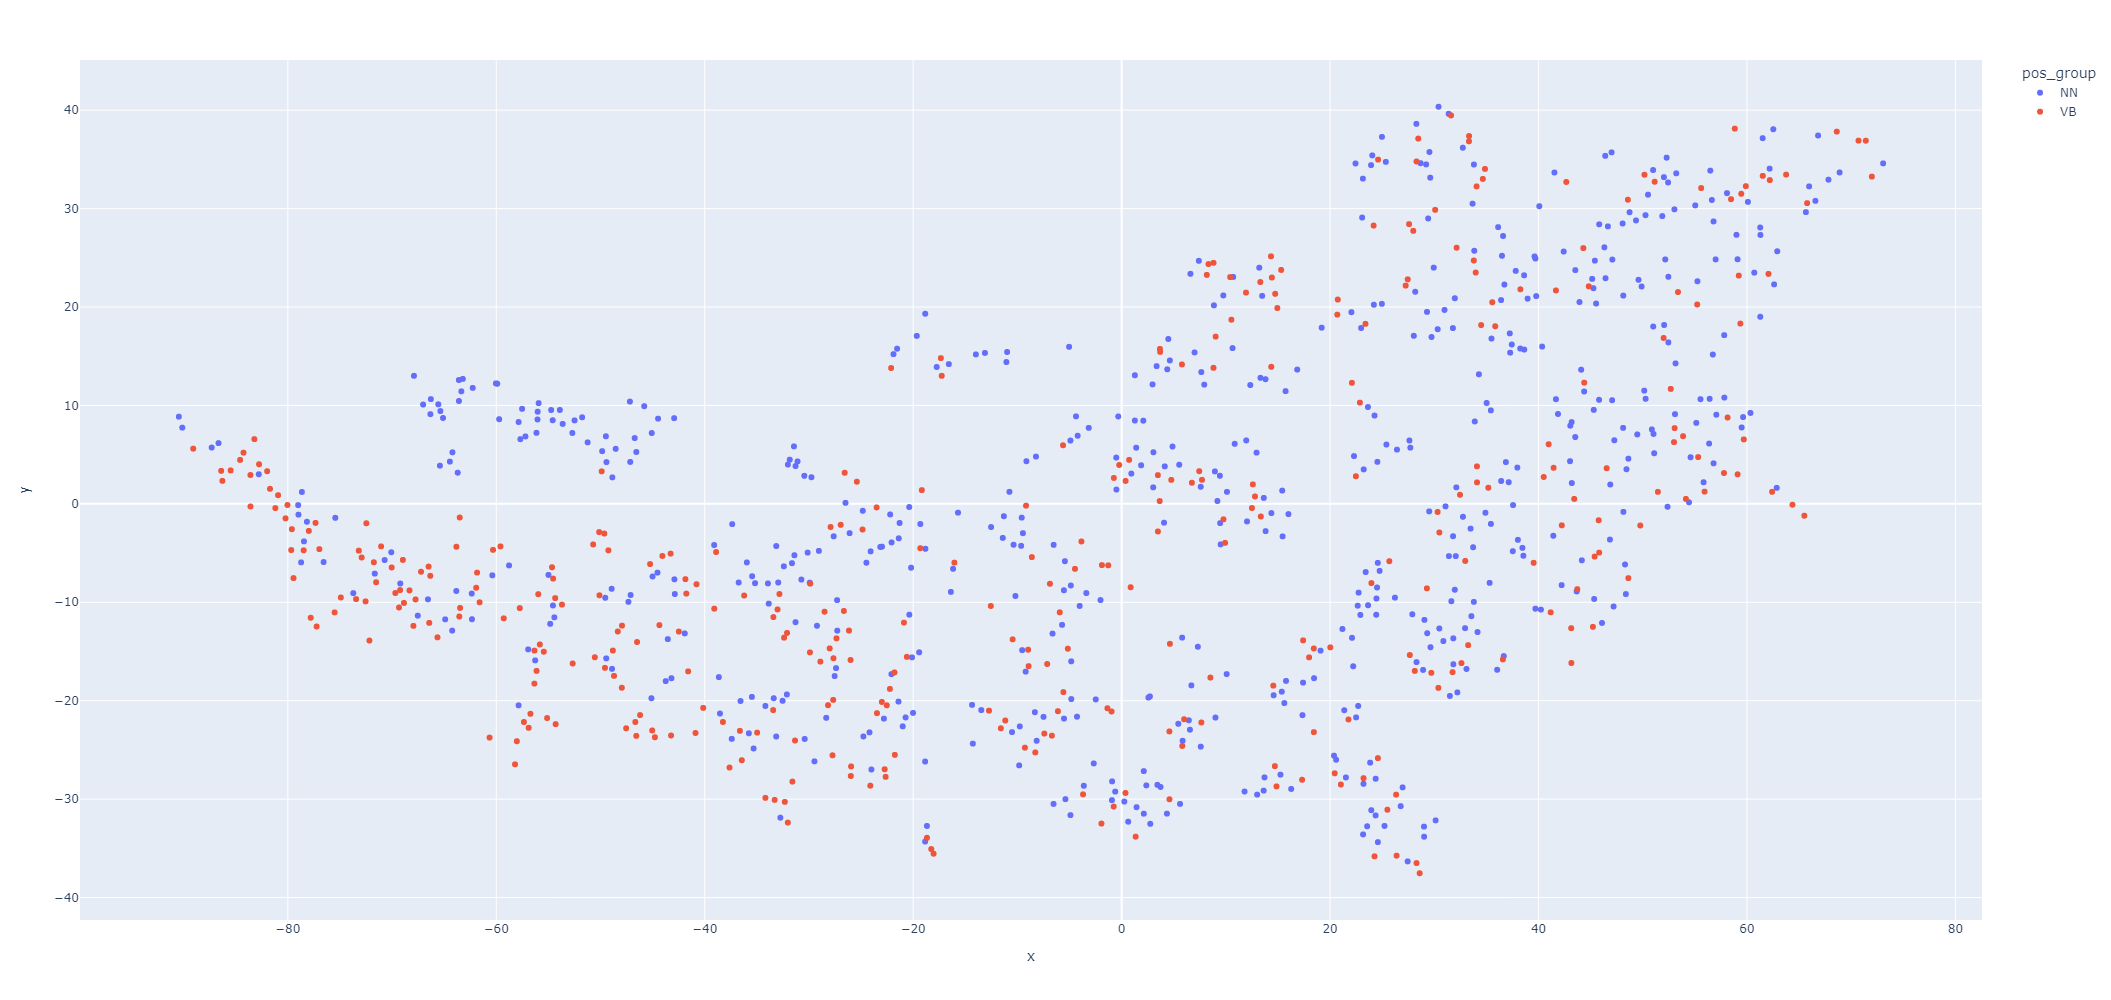

In [188]:
px.scatter(coords.reset_index(), 'x', 'y',  
           color='pos_group', 
           hover_name='term_str',          
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [189]:
def complete_analogy_aus(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None

def complete_analogy_mel(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model_mel.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [190]:
complete_analogy_aus('snape','professor','harry', 5)

term       sim
0    they  0.967786
1      he  0.962130
2   there  0.955916
3     she  0.951706
4  hagrid  0.924965

In [191]:
get_most_similar('castle')

term       sim
0     chest  0.998957
1    within  0.998933
2  supposed  0.998919
3   pulling  0.998870
4     point  0.998836
5       top  0.998828
6      ball  0.998822
7   ceiling  0.998789
8    inside  0.998622
9    potion  0.998612

In [192]:
coords

vector          x  \
term_str                                                                  
harry      [-0.09114715, -0.16361018, 0.056411423, 0.1077... -67.895378   
said       [-0.045251682, -0.08111252, 0.05181321, 0.1325... -63.504646   
was        [-0.05187624, -0.011199842, -0.017328879, -0.0... -86.280434   
s          [-0.06601473, -0.070487574, -0.04764048, 0.209...  71.981201   
had        [-0.06703863, -0.04644417, -0.042324822, 0.030... -79.454262   
...                                                      ...        ...   
lie        [-0.07624215, -0.07404178, -0.03104279, 0.1472...  14.860714   
nodding    [-0.07461775, -0.074840486, -0.028748399, 0.16...  31.751795   
detention  [-0.07007418, -0.07547886, -0.027729232, 0.158...  24.449047   
gaunt      [-0.075160936, -0.07987321, -0.02810515, 0.155...   5.806388   
lived      [-0.06714608, -0.07055982, -0.025824847, 0.139...   4.590492   

                   y      n         p          i  n_chars max_pos  n_pos  \
term_str                                                                   
harry      13.008692  18258  0.016327   5.936592        5     NNP      5   
said       -1.385871  14491  0.012958   6.269964        4     VBD      2   
was         2.337891  15647  0.013992   6.159235        3     VBD      4   
s          33.250050  14796  0.013231   6.239914        1     VBD     19   
had        -7.543076  10165  0.009090   6.781511        3     VBD      3   
...              ...    ...       ...        ...      ...     ...    ...   
lie       -28.706079     74  0.000066  13.883380        3      VB      7   
nodding   -17.100330     65  0.000058  14.070465        7     VBG      2   
detention  -9.615355     89  0.000080  13.617100        9      NN      3   
gaunt     -13.590788     72  0.000064  13.922908        5     NNP      3   
lived     -30.013910     88  0.000079  13.633402        5     VBD      3   

                                                     cat_pos  stop  \
term_str                                                             
harry                                 {VBP, VB, NNP, RP, NN}     0   
said                                              {NNP, VBD}     0   
was                                       {IN, VB, NNP, VBD}     1   
s          {VBP, VB, NNP, VBN, JJR, PDT, VBD, RB, RBR, RB...     1   
had                                          {NNP, VBN, VBD}     1   
...                                                      ...   ...   
lie                          {JJ, VBP, VBZ, VB, NNP, RB, NN}     0   
nodding                                            {NN, VBG}     0   
detention                                     {NN, NNP, VBP}     0   
gaunt                                          {JJ, NN, NNP}     0   
lived                                        {NNP, VBN, VBD}     0   

          stem_porter stem_snowball stem_lancaster      dfidf  mean_tfidf  \
term_str                                                                    
harry           harri         harri          harry   0.000000    0.000000   
said             said          said           said   0.433201    0.000625   
was                wa           was            was   0.000000    0.000000   
s                   s             s              s   0.000000    0.000000   
had               had           had            had   0.000000    0.000000   
...               ...           ...            ...        ...         ...   
lie               lie           lie            lie  30.837243    0.000781   
nodding           nod           nod            nod  30.588803    0.000755   
detention      detent        detent            det  29.260381    0.001058   
gaunt           gaunt         gaunt          gaunt  20.509309    0.001333   
lived            live          live            liv  30.949759    0.000967   

          pos_group  
term_str             
harry            NN  
said             VB  
was              VB  
s                VB  
had              VB  
...             ...  


In [193]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def hca(sims, labels, linkage_method='ward', color_thresh=.3):
    tree = sch.linkage(sims, method=linkage_method)
    fig_height = len(labels) / 3
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, fig_height))
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

def plot_terms_tree(coords, terms_n = 100, term_pos_pat = r'^(N|V)', color_thresh=1):
    term_filter = coords.max_pos.str.match(term_pos_pat) & (coords.stop == 0) & (coords.index.str.len() > 2)
    M = coords[term_filter].sort_values('mean_tfidf', ascending=False).vector.head(terms_n)
    IDX = coords.loc[M.index].index #term_str
    hca(M.to_list(), IDX.to_list(), color_thresh=color_thresh)

<Figure size 640x480 with 0 Axes>

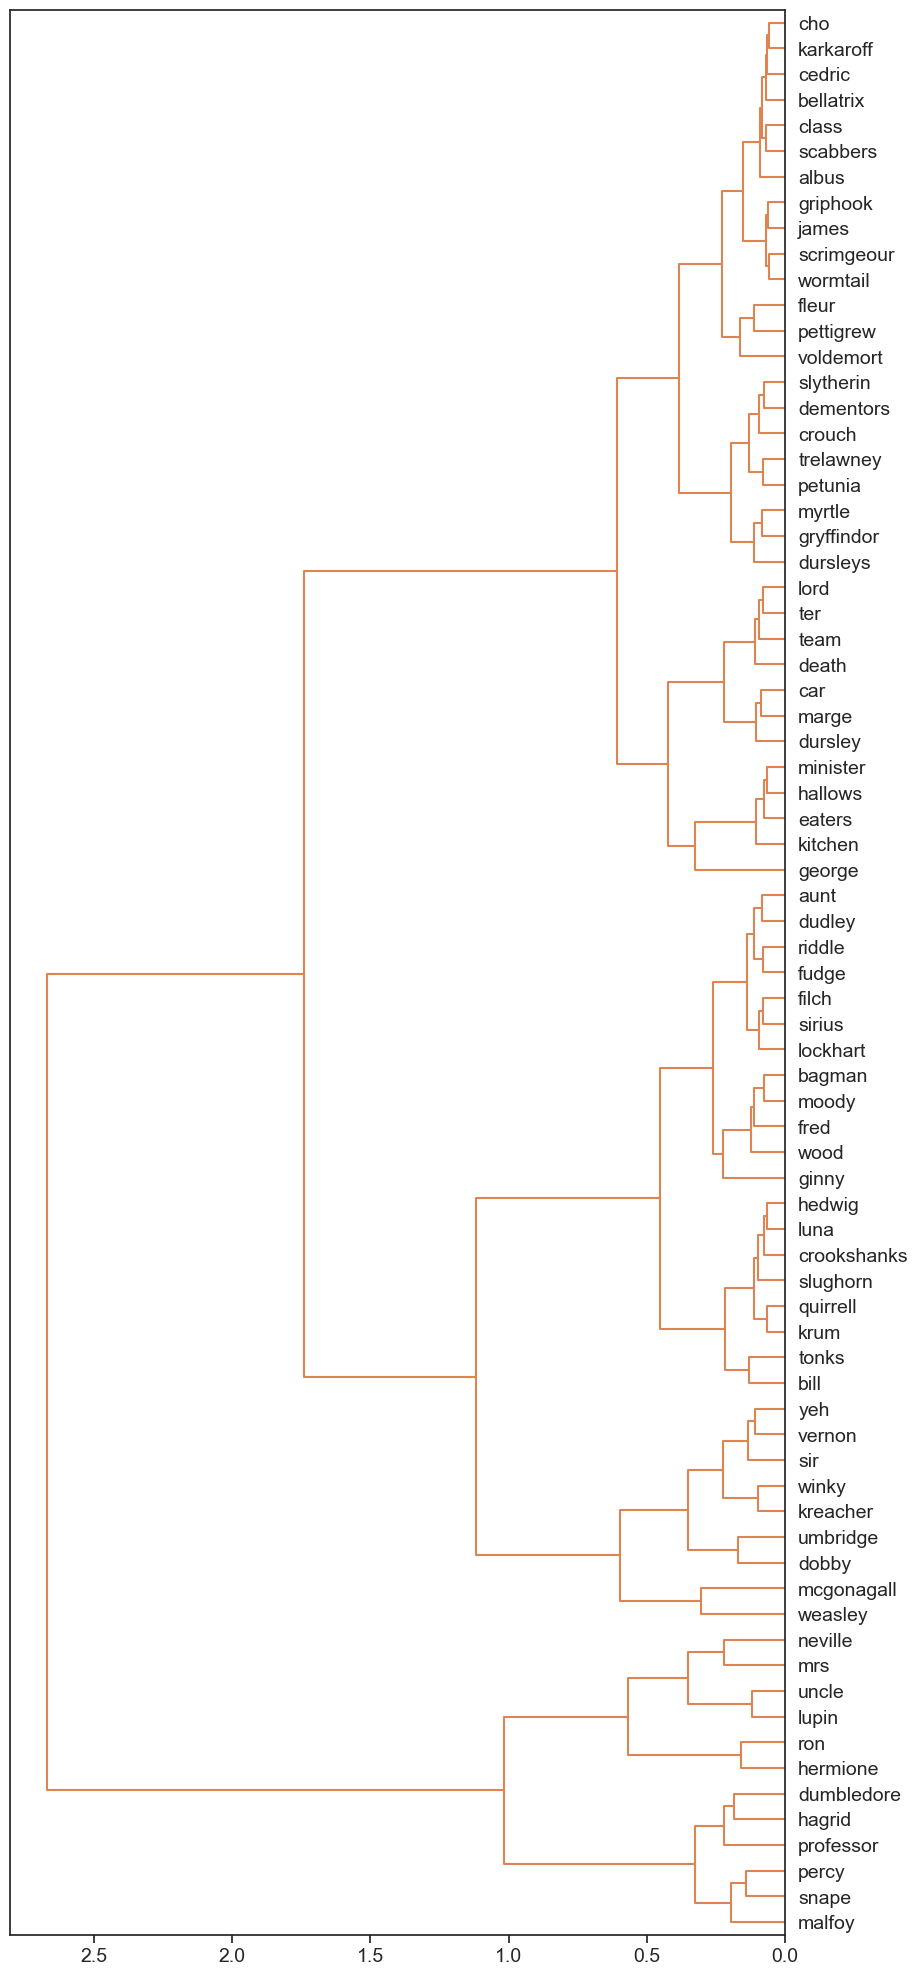

In [194]:
plot_terms_tree(coords, term_pos_pat=r'^NN[^P]?', color_thresh=9, terms_n=75)

## Get SA Lexicon

In [195]:
SALEX = pd.read_csv('salex_nrc.csv').set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
SALEX['polarity'] = SALEX.positive - SALEX.negative

In [196]:
V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1) 

In [197]:
V.head()

n         p          i  n_chars max_pos  n_pos  \
term_str                                                        
harry      18258  0.016327   5.936592        5     NNP      5   
professor   2029  0.001814   9.106280        9     NNP      4   
don         1963  0.001755   9.153989        3     VBP      8   
good        1002  0.000896  10.124166        4      JJ      5   
black        931  0.000833  10.230196        5      JJ      4   

                                         cat_pos  stop stem_porter  \
term_str                                                             
harry                     {VBP, VB, NNP, RP, NN}     0       harri   
professor                     {VB, NN, NNP, VBP}     0   professor   
don        {JJ, VBP, VBZ, VB, NNP, NNS, VBD, NN}     1         don   
good                      {JJ, VB, NNP, VBD, NN}     0        good   
black                          {JJ, VB, NN, NNP}     0       black   

          stem_snowball  ... anticipation  disgust  fear joy  negative  \
term_str                 ...                                             
harry             harri  ...            0        0     0   0         1   
professor     professor  ...            0        0     0   0         0   
don                 don  ...            0        0     0   0         0   
good               good  ...            1        0     0   1         0   
black             black  ...            0        0     0   0         1   

           positive  sadness  surprise  trust  polarity  
term_str                                                 
harry             0        1         0      0        -1  
professor         1        0         0      1         1  
don               1        0         0      1         1  
good              1        0         1      1         1  
black             0        1         0      0        -1  

[5 rows x 25 columns]

In [198]:
DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
TF = (DTCM.T / DTCM.T.max()).T

BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()

In [199]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [200]:
B

n        tf     tfidf max_pos  anger  anticipation  \
book_id chap_num term_str                                                       
1       1.0      amuse     1  0.004926  0.008974      VB    0.0           0.0   
                 angry     1  0.004926  0.001249      JJ    1.0           0.0   
                 anxious   1  0.004926  0.002638      JJ    0.0           1.0   
                 approve   1  0.004926  0.006624      NN    0.0           0.0   
                 aunt      2  0.009852  0.005581     NNP    0.0           0.0   
...                       ..       ...       ...     ...    ...           ...   
7       37.0     vanished  1  0.013699  0.003473     VBD    0.0           0.0   
                 watch     2  0.027397  0.005250      NN    0.0           1.0   
                 white     1  0.013699  0.002579      JJ    0.0           1.0   
                 worried   1  0.013699  0.004854      JJ    0.0           0.0   
                 worry     2  0.027397  0.009709      NN    0.0           1.0   

                           disgust  fear  joy  sadness  surprise  trust  \
book_id chap_num term_str                                                 
1       1.0      amuse         0.0   0.0  1.0      0.0       0.0    0.0   
                 angry         1.0   0.0  0.0      0.0       0.0    0.0   
                 anxious       0.0   1.0  0.0      0.0       0.0    0.0   
                 approve       0.0   0.0  1.0      0.0       0.0    1.0   
                 aunt          0.0   0.0  0.0      0.0       0.0    1.0   
...                            ...   ...  ...      ...       ...    ...   
7       37.0     vanished      0.0   1.0  0.0      1.0       1.0    0.0   
                 watch         0.0   1.0  0.0      0.0       0.0    0.0   
                 white         0.0   0.0  1.0      0.0       0.0    1.0   
                 worried       0.0   0.0  0.0      1.0       0.0    0.0   
                 worry         0.0   1.0  0.0      1.0       0.0    0.0   

                           polarity  
book_id chap_num term_str            
1       1.0      amuse          1.0  
                 angry         -1.0  
                 anxious       -1.0  
                 approve        1.0  
                 aunt           1.0  
...                             ...  
7       37.0     vanished      -1.0  
                 watch          0.0  
                 white          1.0  
                 worried       -1.0  
                 worry         -1.0  

[33197 rows x 13 columns]

In [201]:
for col in emo_cols:
    B[col] = B[col] * B.tfidf

In [202]:
## Emotion word counts by POS 

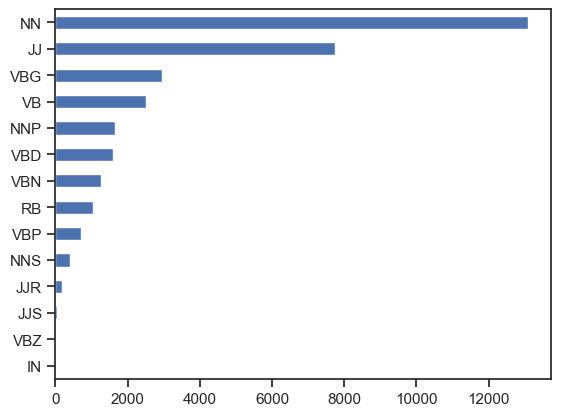

In [203]:
B.max_pos.value_counts().sort_values().plot.barh();

In [204]:
EMO_BOOKS = B.groupby(['book_id'])[emo_cols].mean()
EMO_CHAPS = B.groupby(['book_id','chap_num'])[emo_cols].mean()

In [205]:
EMO_BOOKS.index = LIB.title #book_title

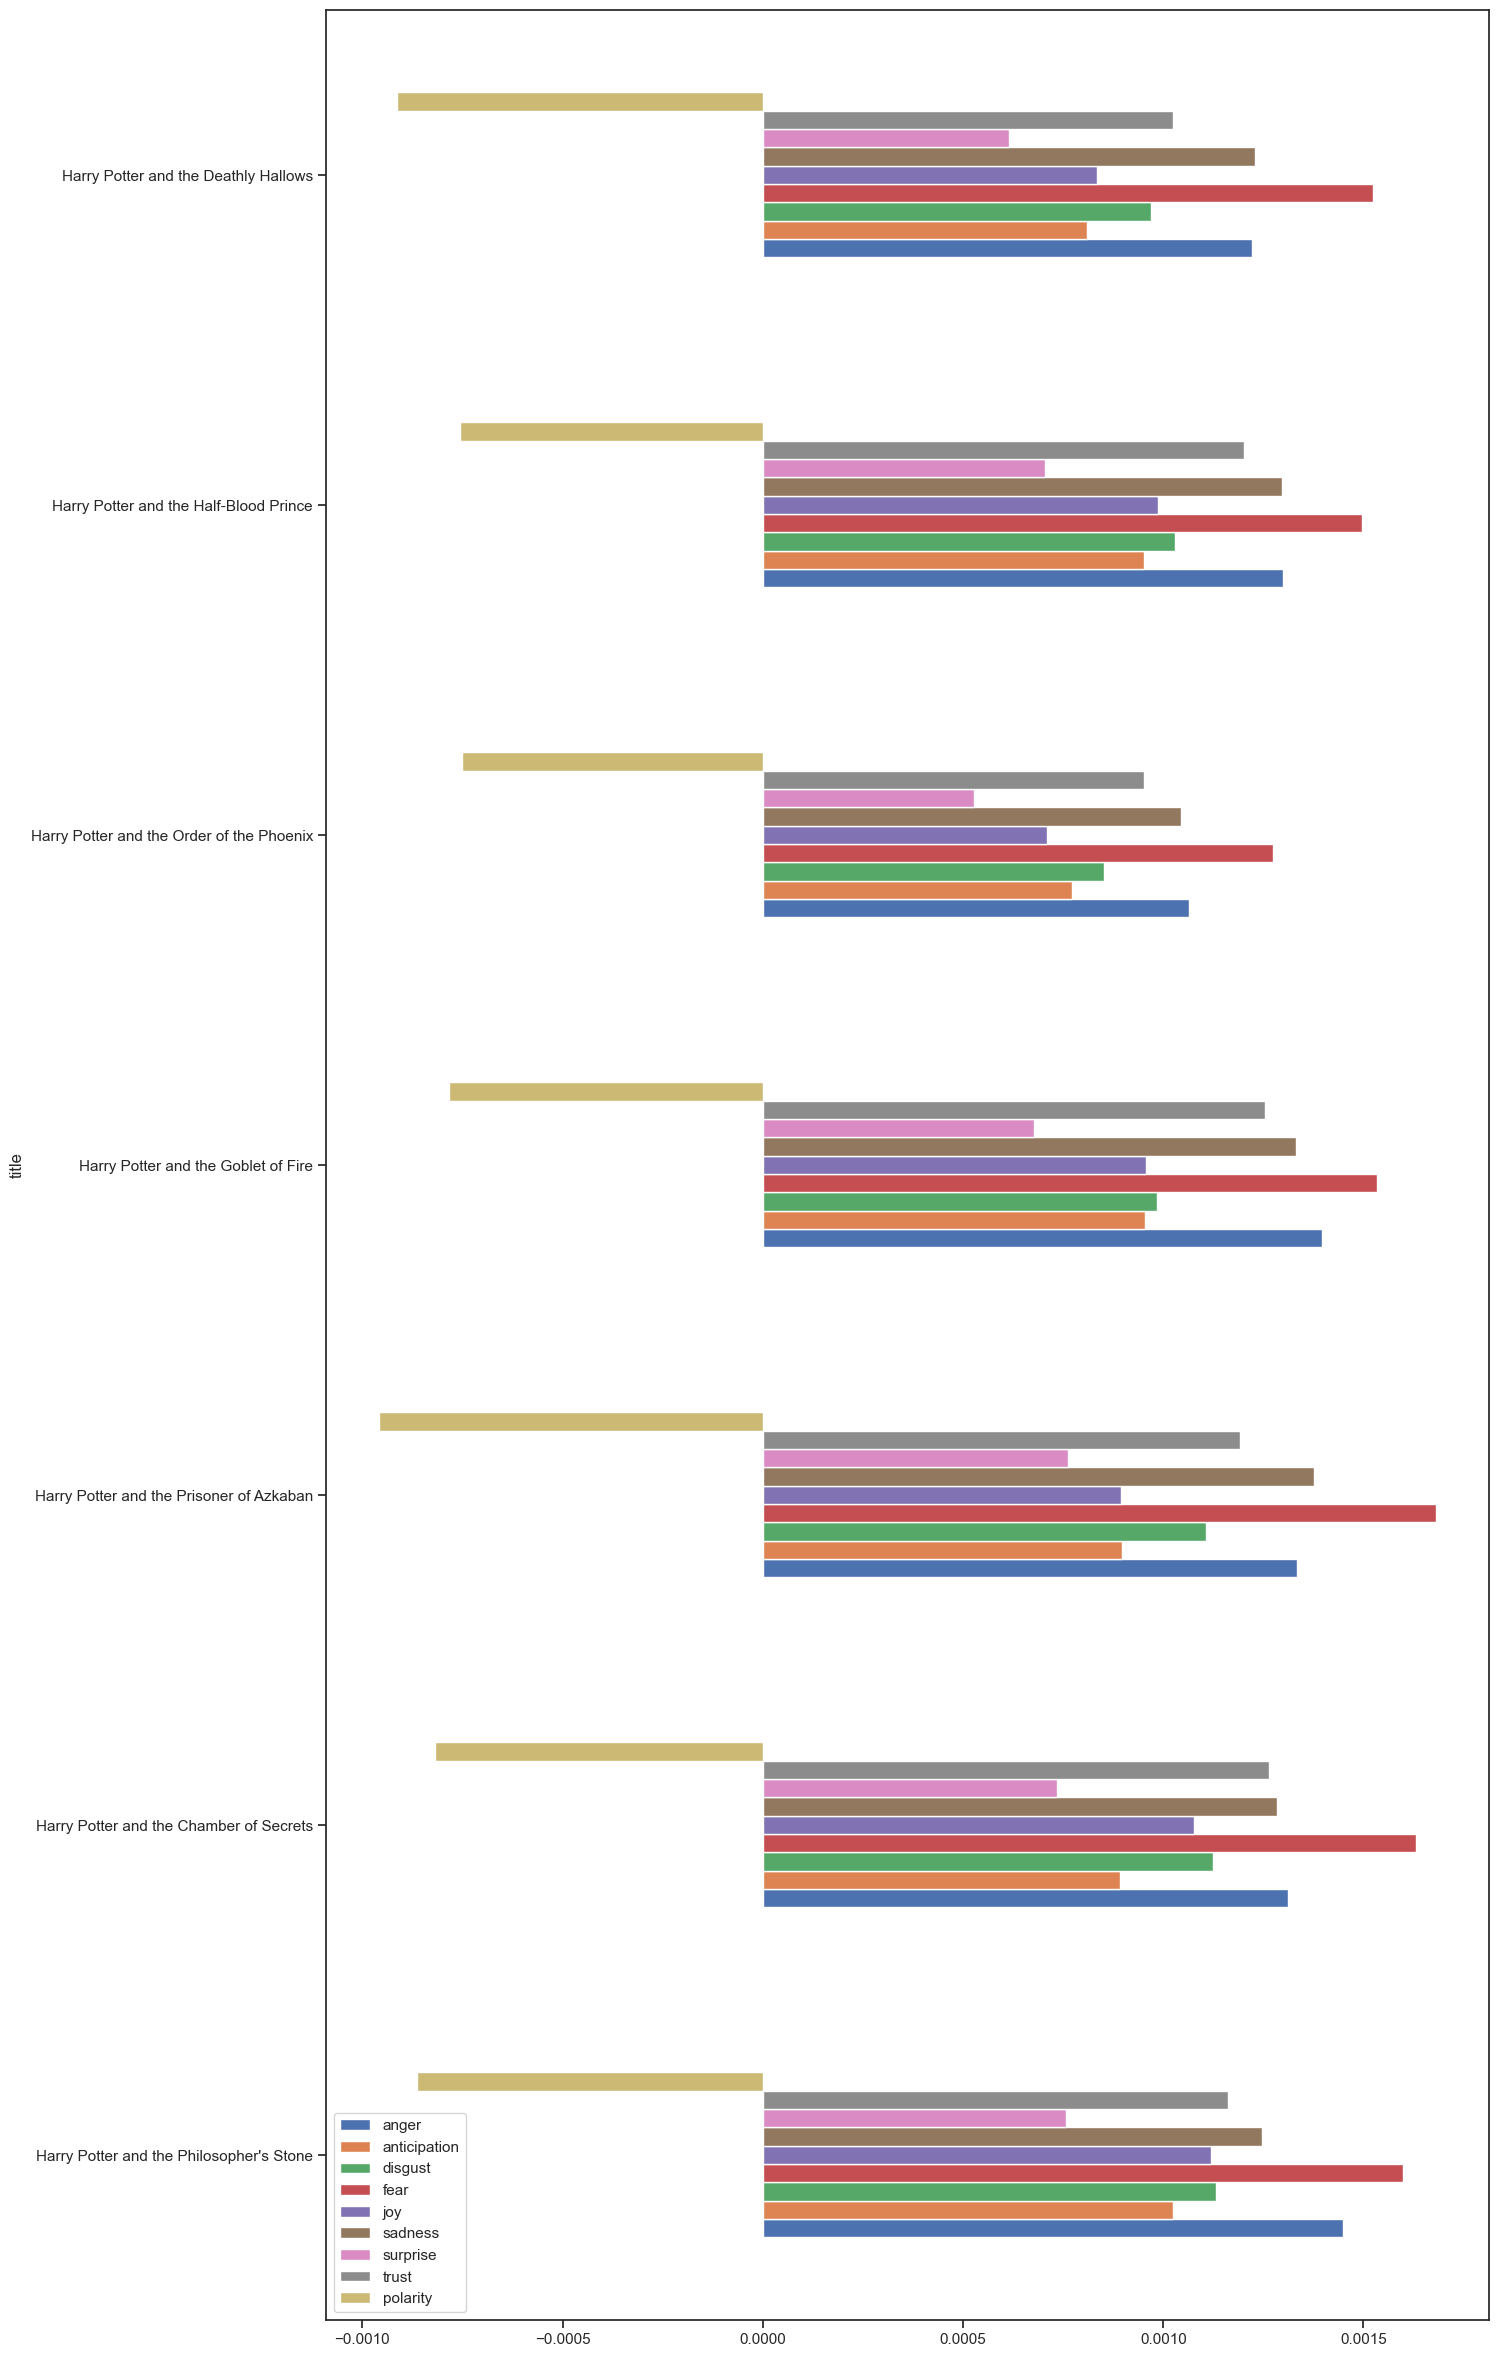

In [206]:
EMO_BOOKS.plot.barh(figsize=(15,30));

## Going more in depth with book 7

In [207]:
EMO_CHAPS

anger  anticipation   disgust      fear       joy  \
book_id chap_num                                                         
1       1.0       0.001028      0.001422  0.000936  0.001474  0.001735   
        2.0       0.001218      0.001367  0.001626  0.001777  0.001592   
        3.0       0.001279      0.000699  0.001207  0.001059  0.000477   
        4.0       0.002318      0.001325  0.001850  0.002692  0.001282   
        5.0       0.001017      0.001028  0.001204  0.001226  0.000967   
...                    ...           ...       ...       ...       ...   
7       33.0      0.000924      0.000626  0.000811  0.001042  0.000610   
        34.0      0.001001      0.000936  0.001119  0.001963  0.001026   
        35.0      0.001827      0.001206  0.001671  0.002305  0.001208   
        36.0      0.001093      0.000710  0.000555  0.001348  0.000738   
        37.0      0.002901      0.003572  0.001131  0.002352  0.003897   

                   sadness  surprise     trust  polarity  
book_id chap_num                                          
1       1.0       0.000938  0.000993  0.001475  0.000328  
        2.0       0.001257  0.001145  0.001910 -0.000257  
        3.0       0.000925  0.000255  0.001287 -0.001230  
        4.0       0.002371  0.001123  0.001158 -0.002923  
        5.0       0.000906  0.000727  0.001193 -0.000577  
...                    ...       ...       ...       ...  
7       33.0      0.001014  0.000530  0.000918 -0.000701  
        34.0      0.001652  0.000586  0.001312 -0.001128  
        35.0      0.001795  0.000731  0.001784 -0.000955  
        36.0      0.001086  0.000578  0.000926 -0.000637  
        37.0      0.002986  0.001638  0.003711 -0.000339  

[199 rows x 9 columns]

In [208]:
book7_chaps = EMO_CHAPS.loc[7] 

## Mean sentiment by chapter 

In [209]:
book7_chaps.style.background_gradient(cmap='YlGnBu', axis=None)

In [210]:
book7_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(7))

In [211]:
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

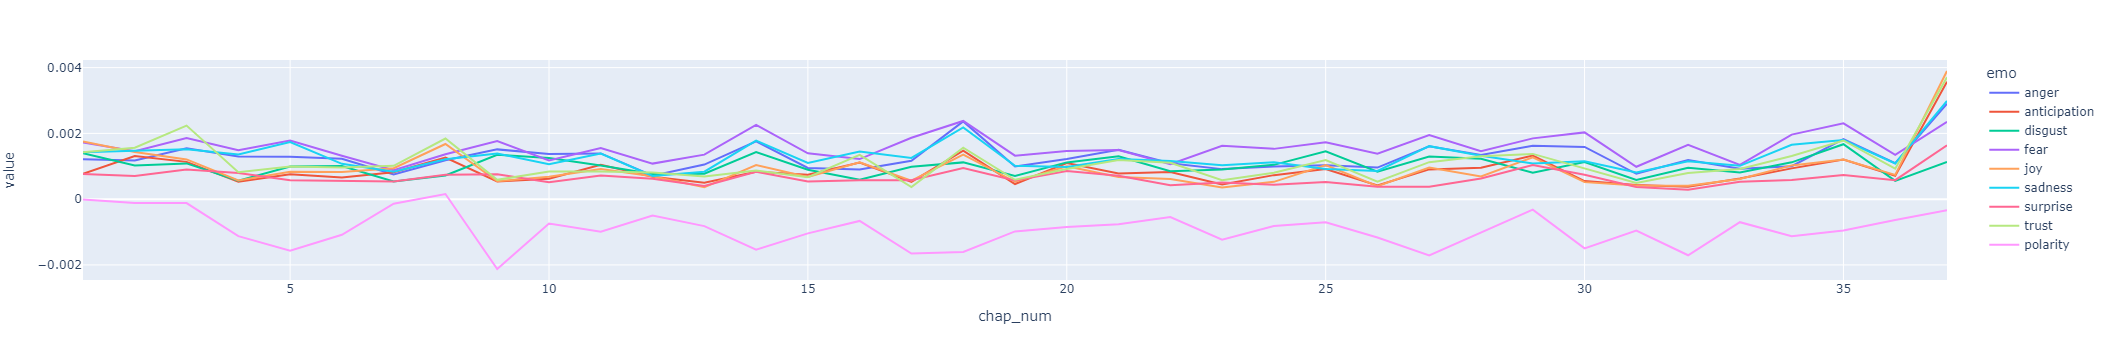

In [212]:
px.line(book7_chaps_thin, x='chap_num', y='value', color='emo')

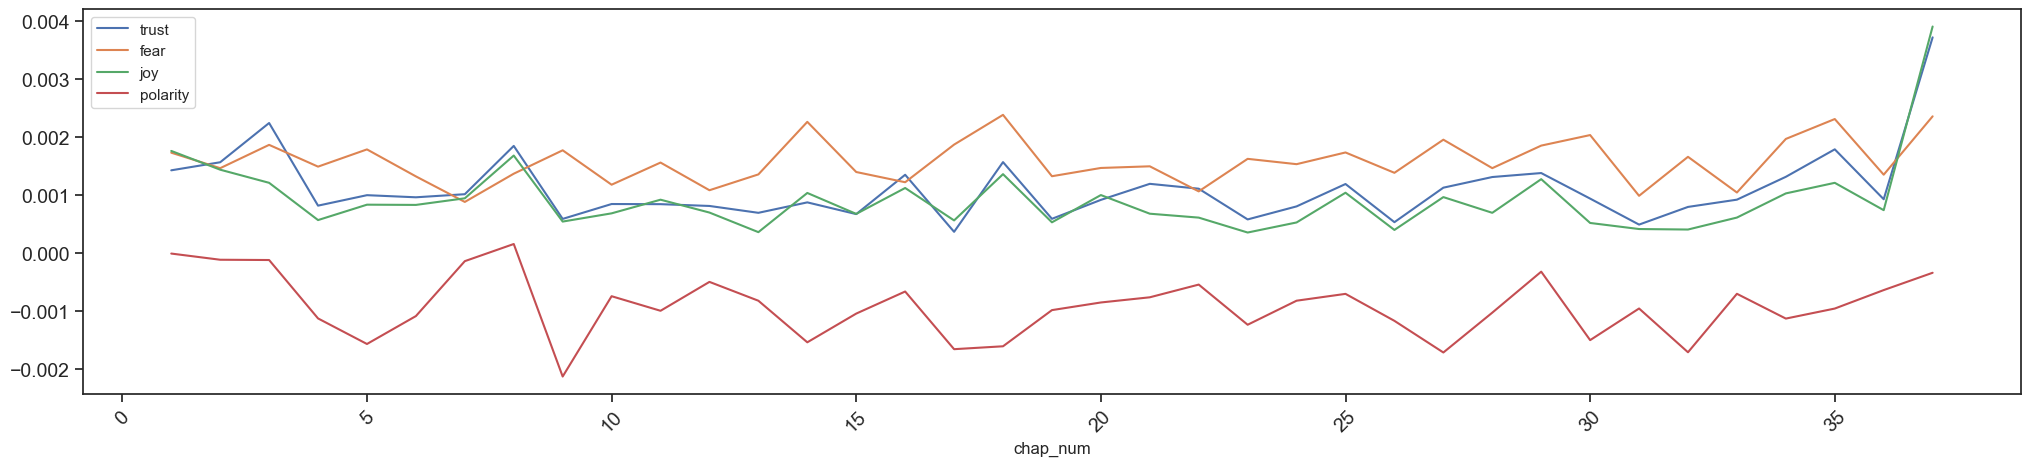

In [213]:
plot_sentiments(book7_chaps, ['trust','fear','joy','polarity'])

## Cose Read Sentiment in Texts

In [214]:
T = CORPUS.join(V, on='term_str').fillna(0)

In [215]:
T

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                  
1       1.0      0        0        0               (Mr, NNP)  NNP        Mr   
                                   1               (and, CC)   CC       and   
                                   2              (Mrs, NNP)  NNP       Mrs   
                                   3          (Dursley, NNP)  NNP   Dursley   
                                   5                (of, IN)   IN        of   
...                                                      ...  ...       ...   
7       37.0     78       0        7          (nineteen, JJ)   JJ  nineteen   
                                   8            (years, NNS)  NNS     years   
                          1        0               (All, DT)   DT       All   
                                   1              (was, VBD)  VBD       was   
                                   2              (well, RB)   RB      well   

                                              term_str    n    p    i  \
book_id chap_num para_num sent_num token_num                            
1       1.0      0        0        0                mr  0.0  0.0  0.0   
                                   1               and  0.0  0.0  0.0   
                                   2               mrs  0.0  0.0  0.0   
                                   3           dursley  0.0  0.0  0.0   
                                   5                of  0.0  0.0  0.0   
...                                                ...  ...  ...  ...   
7       37.0     78       0        7          nineteen  0.0  0.0  0.0   
                                   8             years  0.0  0.0  0.0   
                          1        0               all  0.0  0.0  0.0   
                                   1               was  0.0  0.0  0.0   
                                   2              well  0.0  0.0  0.0   

                                              n_chars max_pos  n_pos  ...  \
book_id chap_num para_num sent_num token_num                          ...   
1       1.0      0        0        0              0.0       0    0.0  ...   
                                   1              0.0       0    0.0  ...   
                                   2              0.0       0    0.0  ...   
                                   3              0.0       0    0.0  ...   
                                   5              0.0       0    0.0  ...   
...                                               ...     ...    ...  ...   
7       37.0     78       0        7              0.0       0    0.0  ...   
                                   8              0.0       0    0.0  ...   
                          1        0              0.0       0    0.0  ...   
                                   1              0.0       0    0.0  ...   
                                   2              0.0       0    0.0  ...   

                                             anticipation  disgust fear  joy  \
book_id chap_num para_num sent_num token_num                                   
1       1.0      0        0        0                  0.0      0.0  0.0  0.0   
                                   1                  0.0      0.0  0.0  0.0   
                                   2                  0.0      0.0  0.0  0.0   
                                   3                  0.0      0.0  0.0  0.0   
                                   5                  0.0      0.0  0.0  0.0   
...                                                   ...      ...  ...  ...   
7       37.0     78       0        7                  0.0      0.0  0.0  0.0   
                                   8                  0.0      0.0  0.0  0.0   
                          1        0                  0.0      0.0  0.0  0.0   
                                   1                  0.0      0.0  0.0  0.0   
                                   2                  0.0      0.0  0.0  0.0   

                              

In [216]:
book7 = T.loc[7].copy()

In [217]:
emo = 'polarity'
book7['html'] = book7.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.term_str), 1)

In [218]:
SENTS = OHCO[:4]
book7_sents = book7.groupby(SENTS[1:])[emo_cols].mean()

In [219]:
book7_sents['sent_str'] = book7.groupby(SENTS[1:]).term_str.apply(lambda x: x.str.cat(sep=' '))

In [220]:
book7_sents['html_str'] = book7.groupby(SENTS[1:]).html.apply(lambda x: x.str.cat(sep=' '))

In [221]:
from IPython.display import display, HTML

def sample_sentences(df):
    rows = []
    for idx in df.sample(10).index:

        valence = round(df.loc[idx, emo], 4)     
        t = 0
        if valence > t: color = '#ccffcc'
        elif valence < t: color = '#ffcccc'
        else: color = '#f2f2f2'
        z=0
        rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
        <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
        </tr>""".format(color, valence, df.loc[idx, 'html_str'], idx))

    display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
    display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

In [222]:
sample_sentences(book7_sents)

## Trying VADER

In [223]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [224]:
book7_vader_cols = book7_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
book7_vader = pd.concat([book7_sents, book7_vader_cols], axis=1)

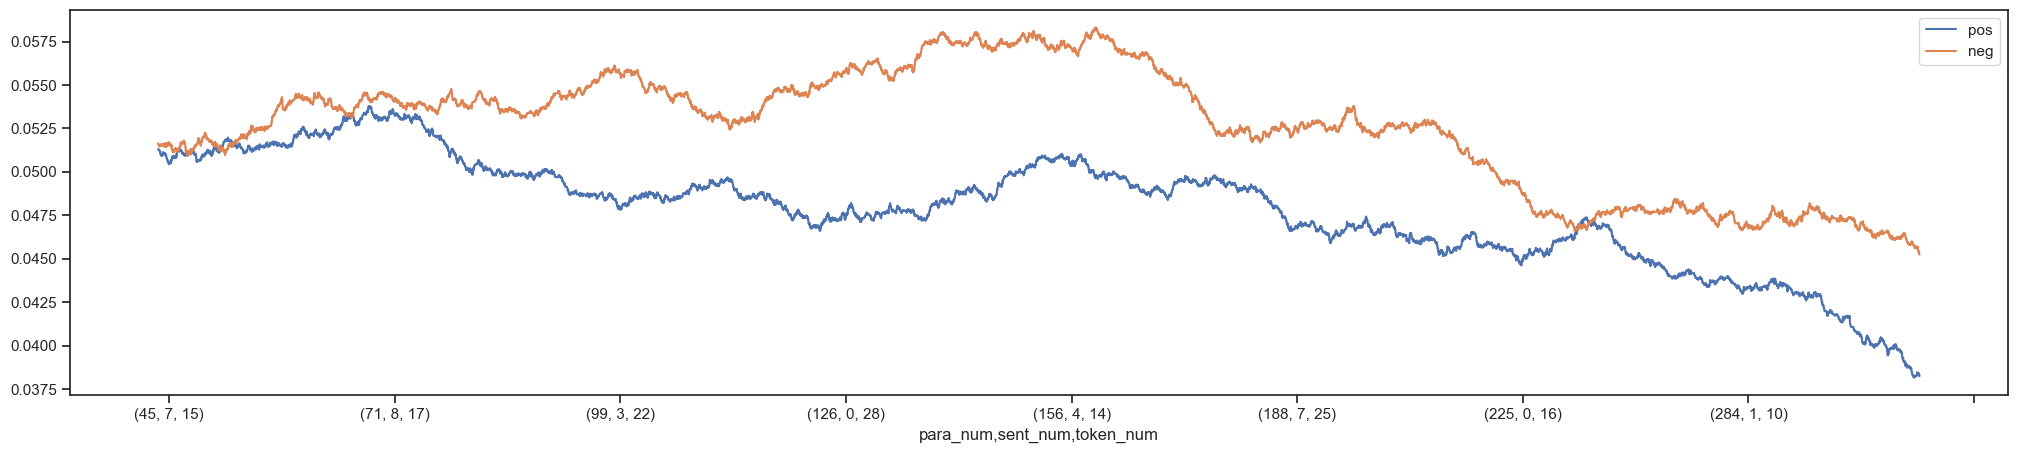

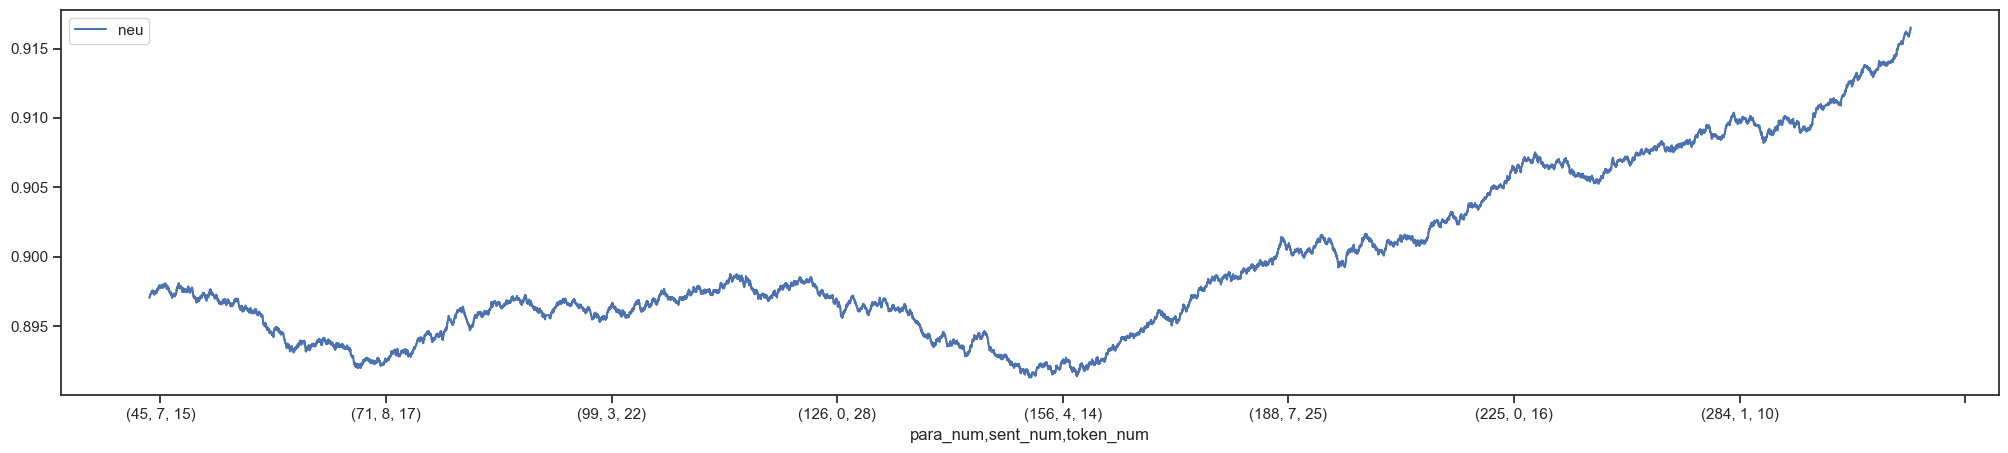

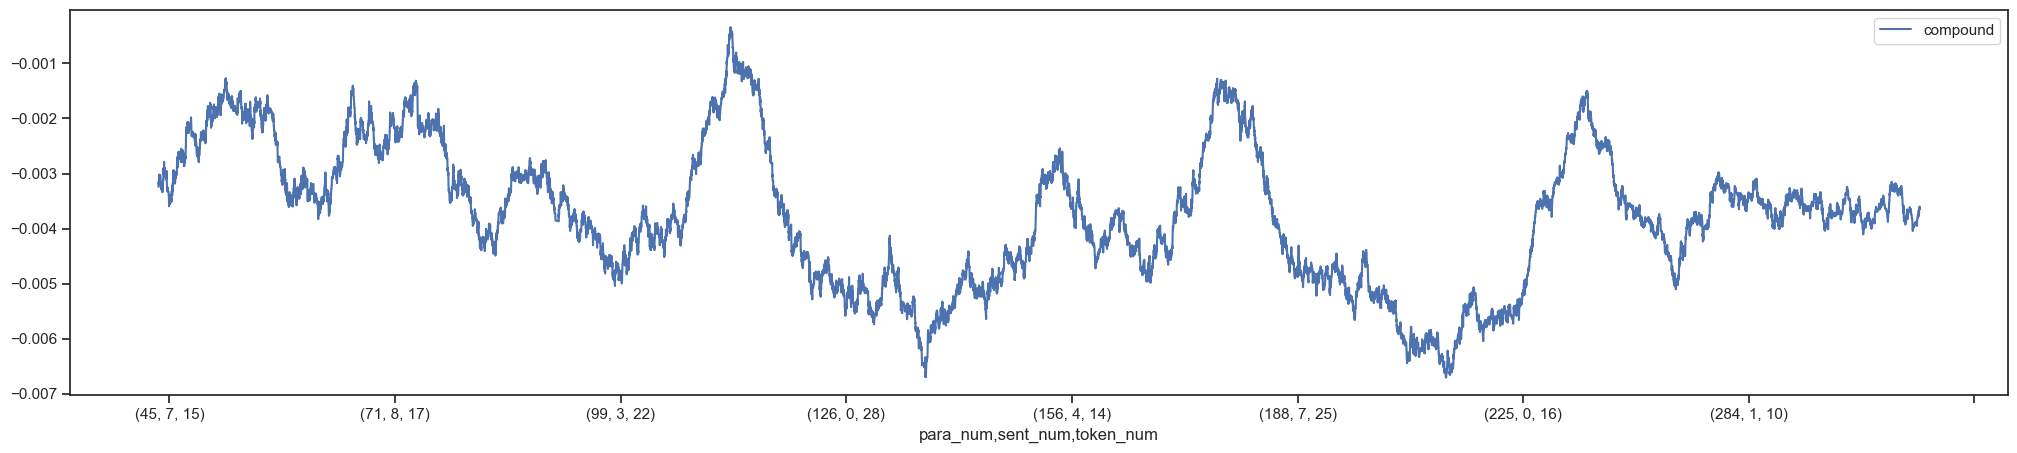

In [225]:
w = int(book7_vader.shape[0] / 5)
book7_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5));
book7_vader[['neu']].rolling(w).mean().plot(figsize=(25,5));
book7_vader[['compound']].rolling(w).mean().plot(figsize=(25,5));

## Emo Space

In [226]:
import sys; sys.path.append("../lib/")

In [227]:
EMOX = B[emo_cols].groupby('book_id').mean()\
    .join(LIB.title).reset_index(drop=True).set_index('title')

In [228]:
EMOX.sort_values('polarity').style.background_gradient(cmap='Spectral', axis=None)

In [229]:
from sklearn.preprocessing import normalize

class HAC:
    """
    Takes an arbitrary vector space and represents it 
    as a hierarhical agglomerative cluster tree. 
    The number of observations should be sufficiently 
    small to allow being plotted.
    Attributes:
        w (int): The width of the figure in inches.
        label_size (int): The font size of the labels in points.
        orientation (str): The orientation of the figure; 'top', 'bottom', 'left', 'right'. Defaults to 'left'.
        dist_measure (str): The distance measure to use; braycurtis, canberra, chebyshev, cityblock, correlation, 
            cosine, dice, euclidean, hamming, jaccard, jensenshannon, kulsinski, kulczynski1, mahalanobis, matching, 
            minkowski, rogerstanimoto, russellrao, seuclidean, sokalmichener, sokalsneath, sqeuclidean, yule. 
            Defaults to euclidean.
        linkage_method (str): The linkage method to use; single, complete, average, weighted, centroid, median, ward
            Defaults to ward.
        norm_type (str): The vector normalization type; l1, l2, max. Defaults to l2.
        color_thresh (float): The threshhold at which to apply coloring in the dendropgram. Defaults to None.
    """

    w:int = 10
    label_size:int = 14
    orientation:str = 'left'
    dist_metric:str = 'cosine' 
    linkage_method:str = 'ward' 
    norm_type:str = 'l2' 
    color_thresh:float = None
    
    def __init__(self, X, labels=None):
        self.X = X
        self.h = X.shape[0]
        if labels:
            self.labels = labels            
        else:
            self.labels = X.index.tolist()

    def get_sims(self):
        self.SIMS = pdist(normalize(self.X, norm=self.norm_type), metric=self.dist_metric)

    def get_tree(self):
        self.TREE = sch.linkage(self.SIMS, method=self.linkage_method)        
        
    def plot_tree(self):
        if not self.color_thresh:
            self.color_thresh = df(self.TREE)[2].median()
        plt.figure()
        plt.subplots(figsize=(self.w, self.h / 3))
        sch.dendrogram(self.TREE, 
            labels=self.labels, 
            orientation=self.orientation,
            count_sort=True,
            distance_sort=True,
            above_threshold_color='.75',
            color_threshold=self.color_thresh);
        plt.tick_params(axis='both', which='major', labelsize=self.label_size)
        
    def plot(self):
        self.get_sims()
        self.get_tree()
        self.plot_tree()

<Figure size 640x480 with 0 Axes>

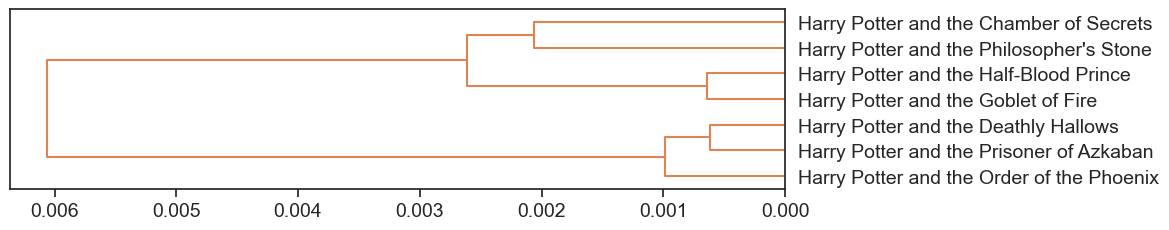

In [230]:
emo_tree = HAC(EMOX)
emo_tree.color_thresh=.03
emo_tree.plot()

It's interesting to see what books get paired together. 1 and 2 are paired, which I think makes sense. What's really cool is seeing 4 and 6 together as both of these books had main characters in the book playing the role as double agents. Mad Eye Moody was being impersonated by Barty Crouch Jr in 4 and Snape was triple agent working with a dying Dumbledore but having everyone think he's evil in book 6. 

# Semantic Search

In [231]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [232]:
BAG = ['book_id', 'chap_num', 'para_num']

CORPUS_by_para = CORPUS.groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})\
    .reset_index()

CORPUS_text = CORPUS_by_para.para_str
CORPUS_text

0        mr and mrs dursley of number four privet drive...
1        mr dursley was the director of a firm called g...
2        the dursleys had everything they wanted but th...
3        met for several years in fact mrs dursley pret...
4        this boy was another good reason for keeping t...
                               ...                        
40736    the last trace of steam evaporated in the autu...
40737                    he ll be all right murmured ginny
40738    as harry looked at her he lowered his hand abs...
40739                                       i know he will
40740    the scar had not pained harry for nineteen yea...
Name: para_str, Length: 40741, dtype: object

In [233]:
import torch
import pprint
corpus_embeddings = torch.load("harrypotter.pt")

In [234]:
def search_potter(concept, top_k, books = [1, 2, 3, 4, 5, 6, 7]):
    # Get book indexes and filter corpus embeddings by book
    book_indexes = list(np.concatenate(([CORPUS_by_para[CORPUS_by_para['book_id'] == i].index for i in books])))
    global corpus_embeddings
    corpus_embeddings_subset = corpus_embeddings[book_indexes]
    
    #Encode the query
    query_embedding = model.encode(concept, convert_to_tensor=True)
    
    # Generate search hits
    potter_search_hits = util.semantic_search(query_embedding, corpus_embeddings_subset, top_k=top_k)[0]
    
    # Get row indexes of the top k hits
    potter_hit_indexes = [x['corpus_id'] for x in potter_search_hits]
    
    return pprint.pprint([{"Book Number: " + str(CORPUS_by_para.iloc[x]["book_id"]) + 
             ", Chapter Number: " + 
             str(int(CORPUS_by_para.iloc[x]["chap_num"]))
             :CORPUS_by_para.iloc[x]["para_str"]} for x in potter_hit_indexes])

search_potter("the scar had not pained harry for nineteen years all was well", 5, books=[1, 2])

[{'Book Number: 2, Chapter Number: 1': 'it was this scar that made harry so '
                                       'particularly unusual even for a wizard '
                                       'this scar was the only hint of harry s '
                                       'very mysterious past of the reason he '
                                       'had been left on the dursleys doorstep '
                                       'eleven years before'},
 {'Book Number: 1, Chapter Number: 16': 'well i was lucky once wasn t i said '
                                        'harry pointing at his scar i might '
                                        'get lucky again'},
 {'Book Number: 1, Chapter Number: 16': 'harry did the best he could trying to '
                                        'ignore the stabbing pains in his '
                                        'forehead which had been bothering him '
                                        'ever since his trip into the forest '
  

# Visualizations

## Word Dispersion Plots

In [235]:
D = pd.get_dummies(CORPUS.term_str)

def word_plot(term_str):
    D[term_str].plot(figsize=(10, .5), legend=False, title=term_str.upper());

In [236]:
## Looking at some expected to be more frequent

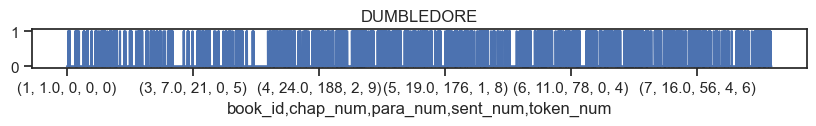

In [237]:
word_plot('dumbledore') # from M01_04_Further_Exploration

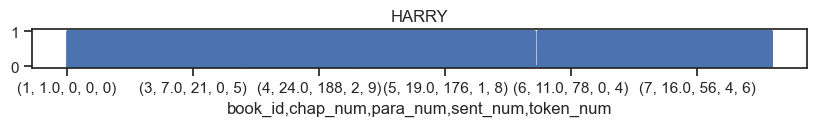

In [238]:
word_plot('harry')

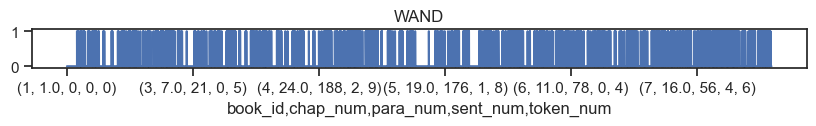

In [239]:
word_plot('wand')

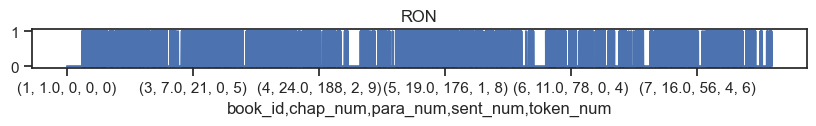

In [240]:
word_plot('ron')

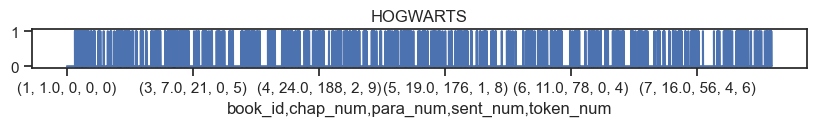

In [241]:
word_plot('hogwarts')

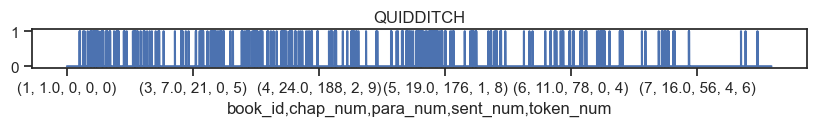

In [242]:
word_plot('quidditch')

In [243]:
## Some more rarer words

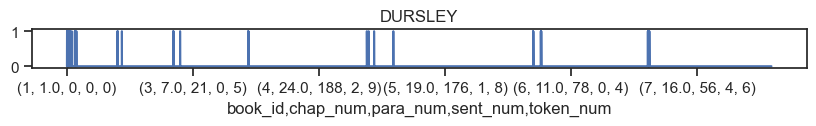

In [244]:
word_plot('dursley')

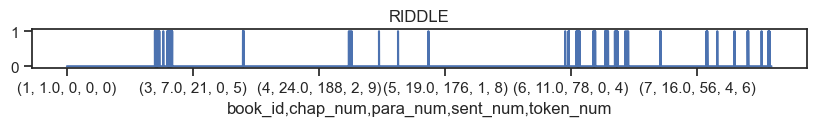

In [245]:
word_plot('riddle')

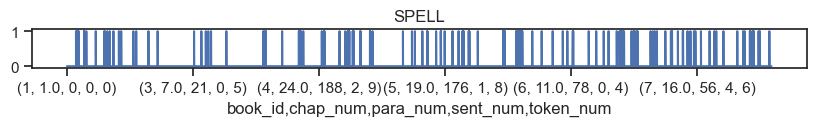

In [246]:
word_plot('spell')

## Correlation Dendograms

<Figure size 640x480 with 0 Axes>

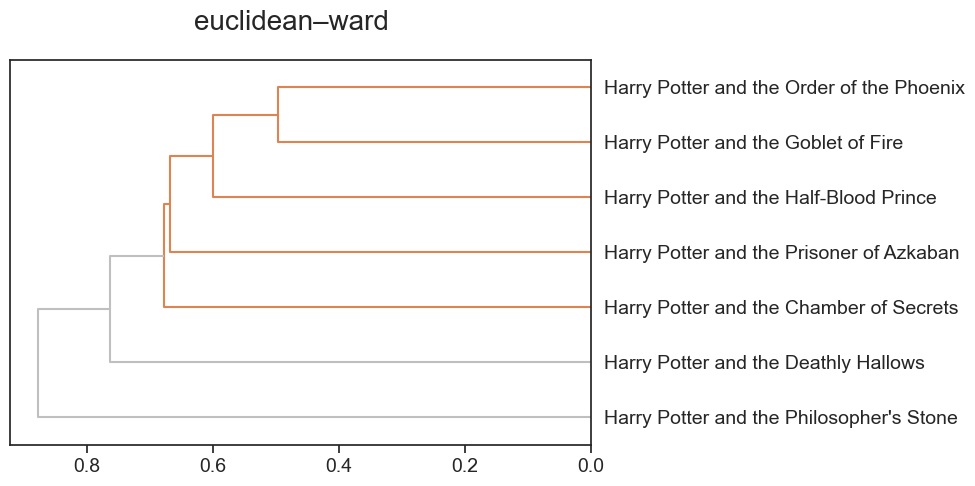

<Figure size 640x480 with 0 Axes>

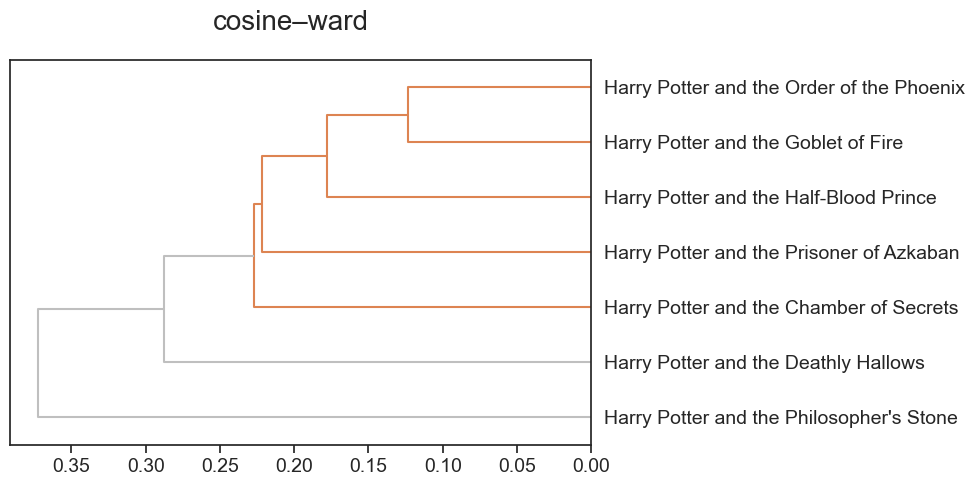

<Figure size 640x480 with 0 Axes>

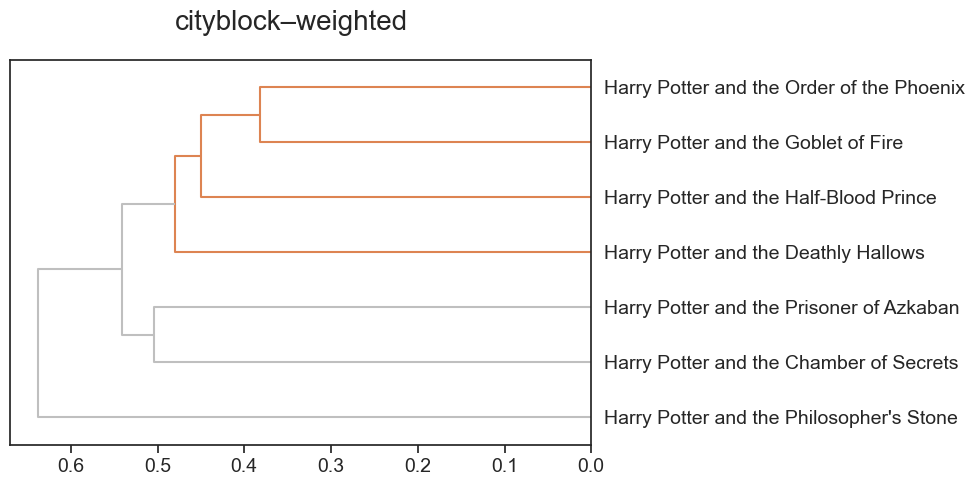

<Figure size 640x480 with 0 Axes>

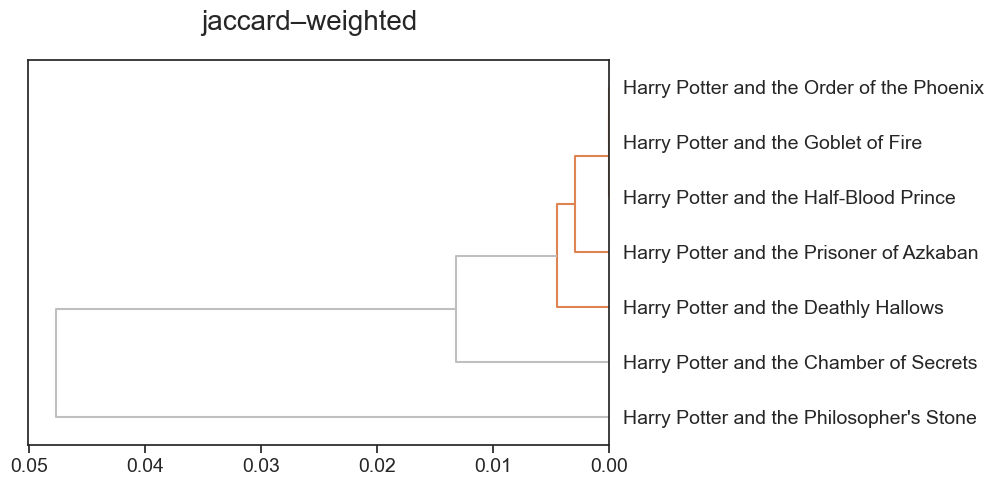

<Figure size 640x480 with 0 Axes>

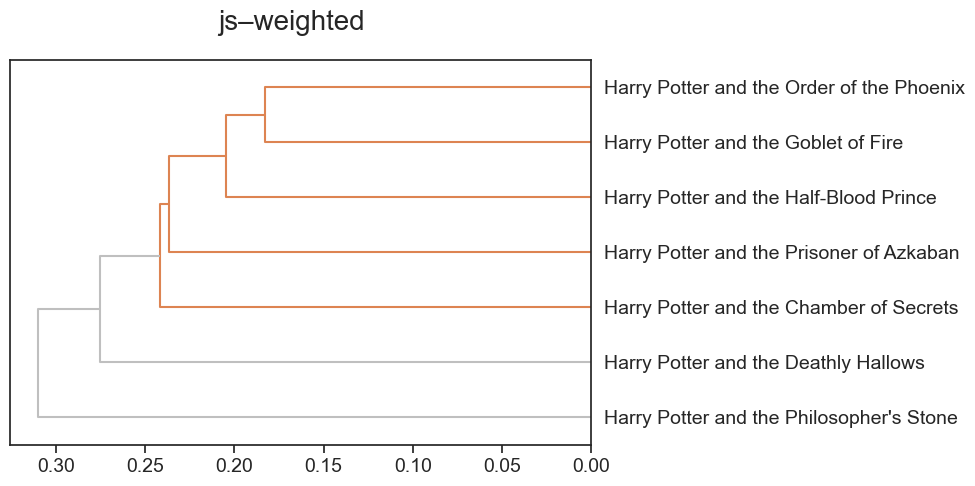

In [247]:
# Define function
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def draw_hca(sims, linkage_method='complete', figsize=(7.5, 5)):
    global LIB
    
    tree = sch.linkage(sims, method=linkage_method)
    color_thresh = pd.DataFrame(tree)[2].mean()
    
    labels = LIB.title.values
    
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh,
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.suptitle(f"{title}–{linkage_method}", fontsize=20)

for X, metric, title, linkage in combos:
    draw_hca(PAIRS[title], linkage_method=linkage)

## Plot Chapter Significance

In [262]:
def plot_sig_docs(book_id, type='scatter'):

    global DOCS
    D = DOCS.loc[book_id]
    title = LIB.loc[book_id].title
    point_size = (D.n / D.n.sum()) * 700
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=D.index, y=D.book_chap_sig, 
                             text=D.index, 
                             mode = 'lines+markers+text',
                             marker = dict(size=point_size, color='#BBB'),
                             line = dict(color='#DADADA'),
                             textfont = dict(color="black")
                            ))
                  
    fig.update_layout(
        font = dict(color="#000", size=14),
        title=title,
        xaxis_title="Chapter",
        yaxis_title="Significance",
        height=800
    )
    fig.show()

In [263]:
DOCS = BOW.groupby(bag).n.sum().to_frame('n')
DOCS['book_chap_sig'] = TFIDF.T.mean().to_frame('book_chap_sig')

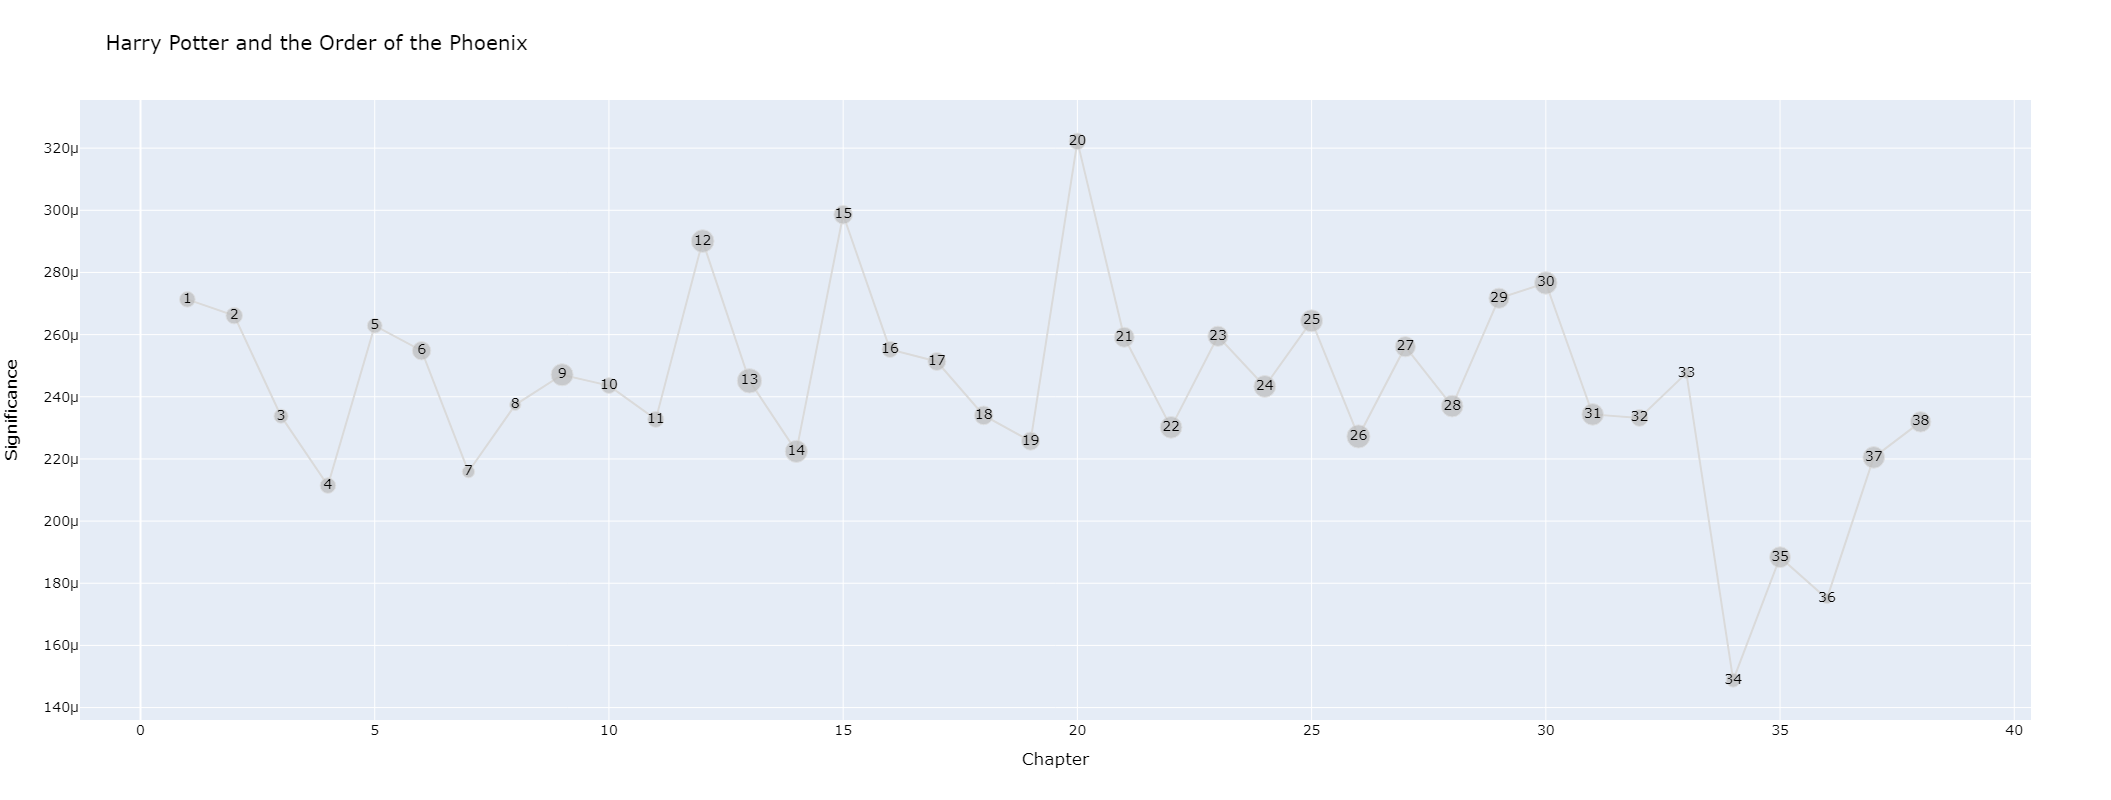

In [265]:
plot_sig_docs(5)

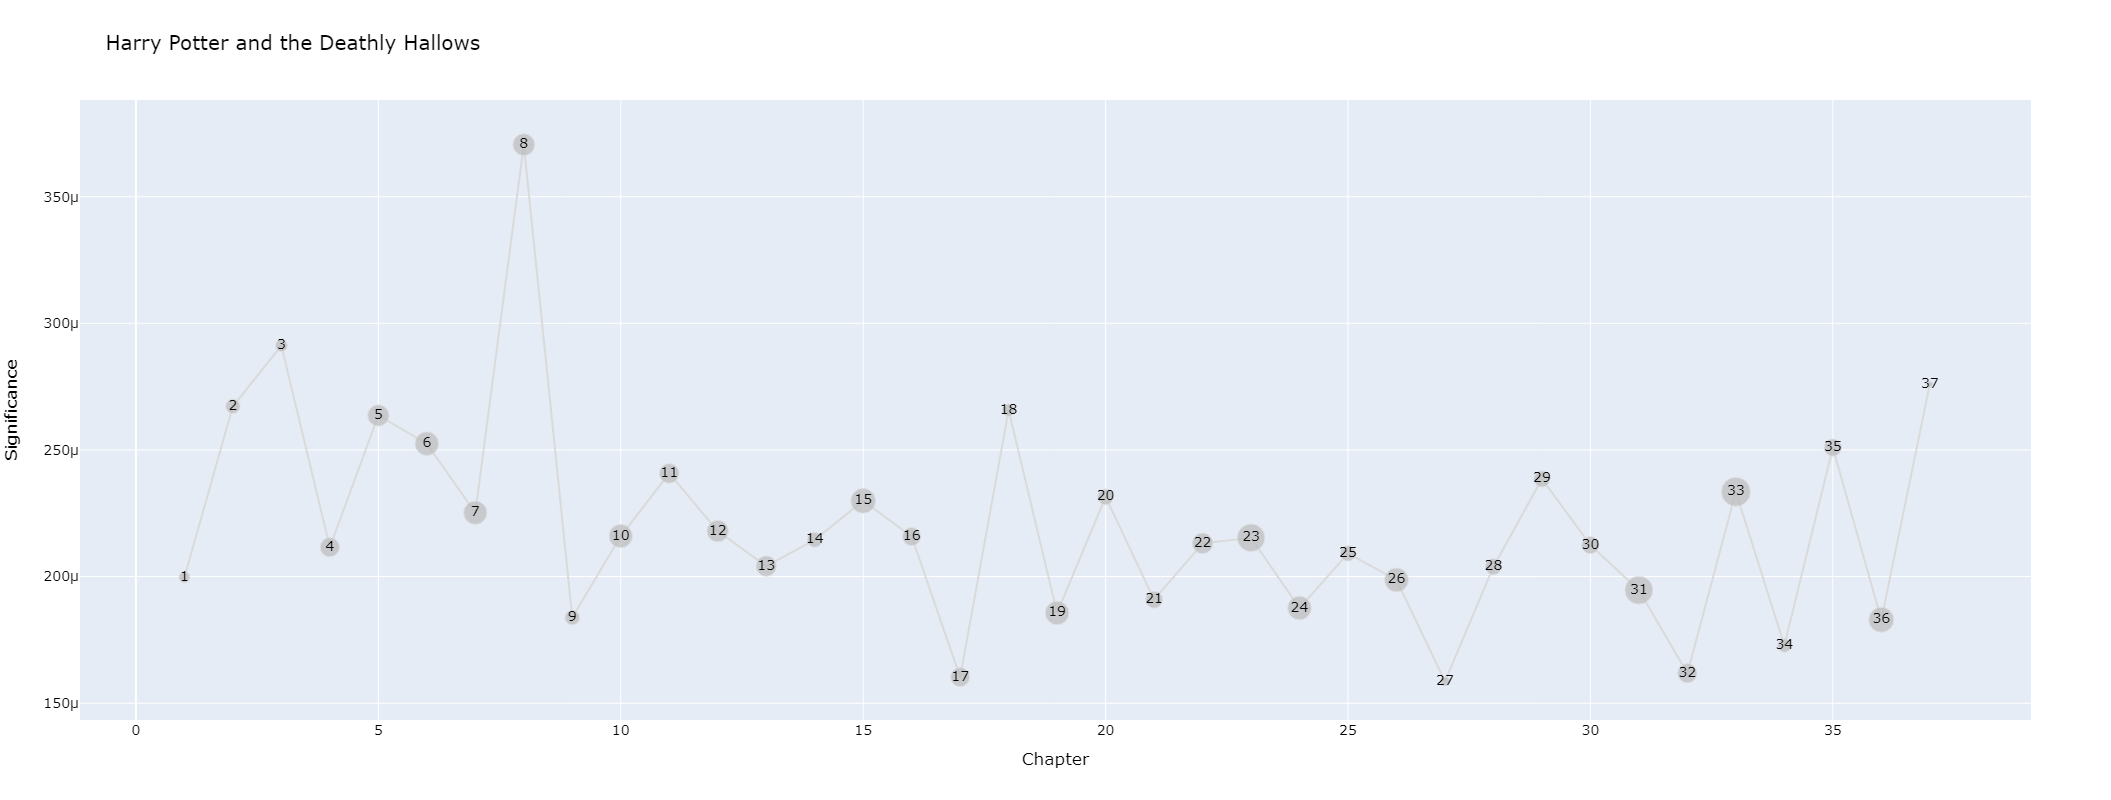

In [266]:
plot_sig_docs(7)

## PCA Visualizations

In [250]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = LOADINGS.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos',
                      marginal_x='box', height=800)

In [251]:
def vis_pcs(M, a, b, label='title', hover_name='doc', symbol=None, size=None):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()

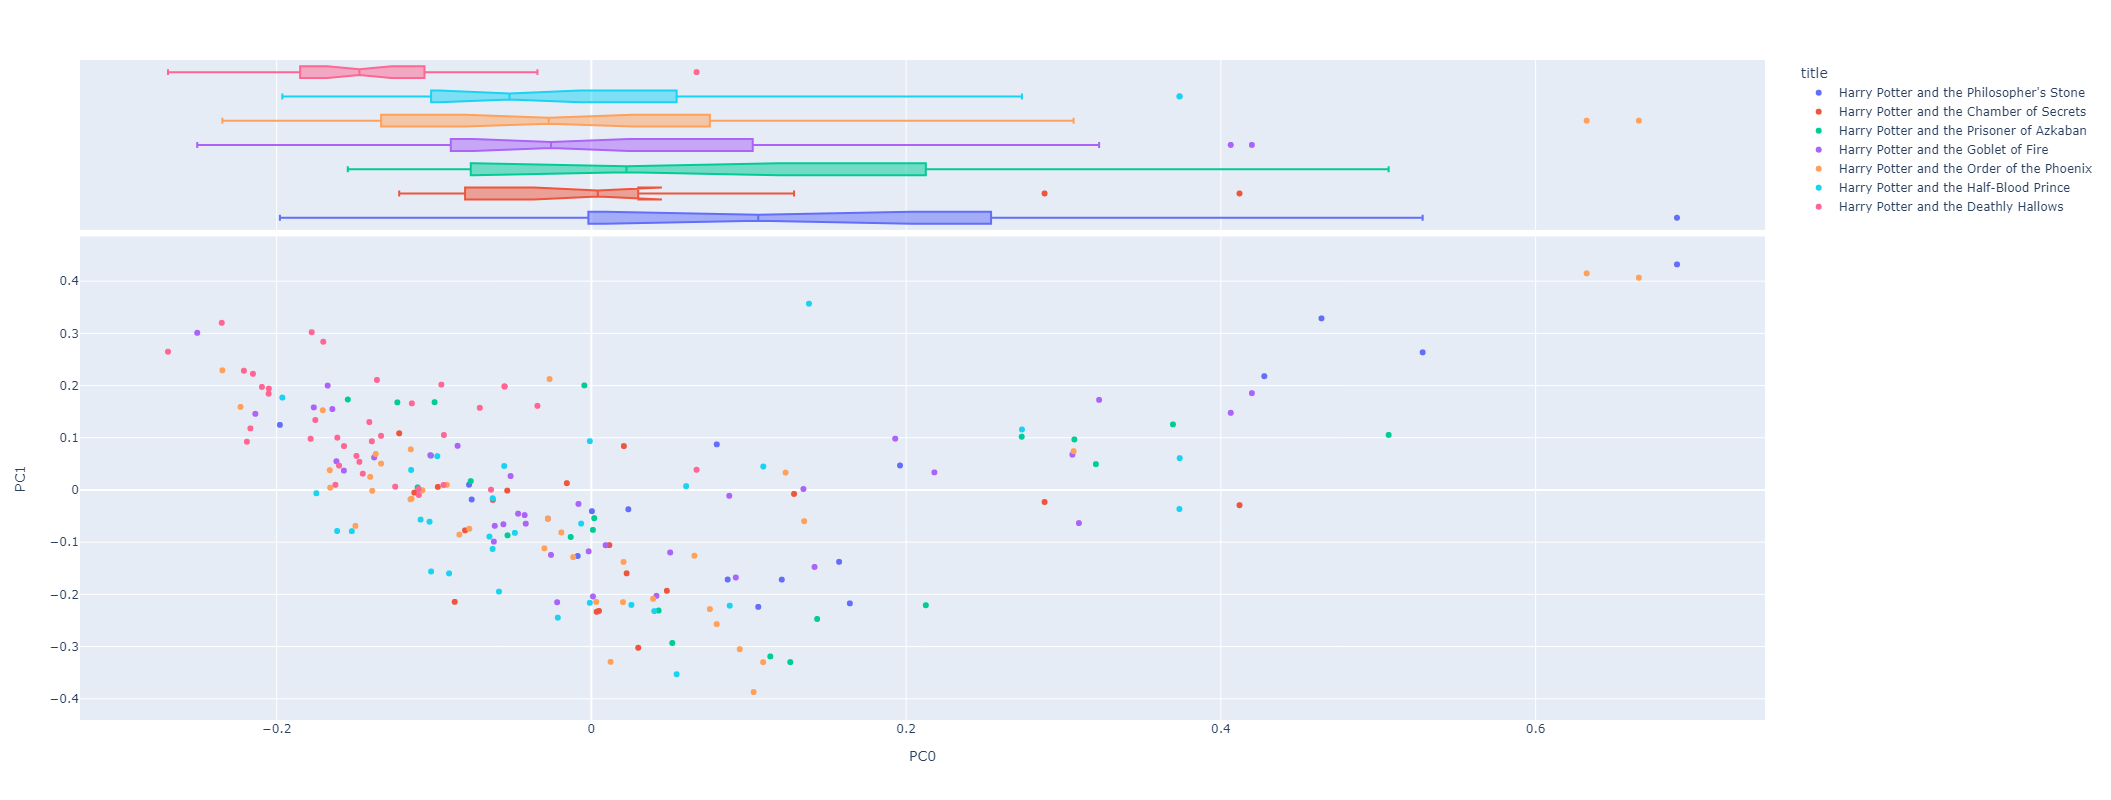

In [252]:
vis_pcs(DCM, 0, 1)

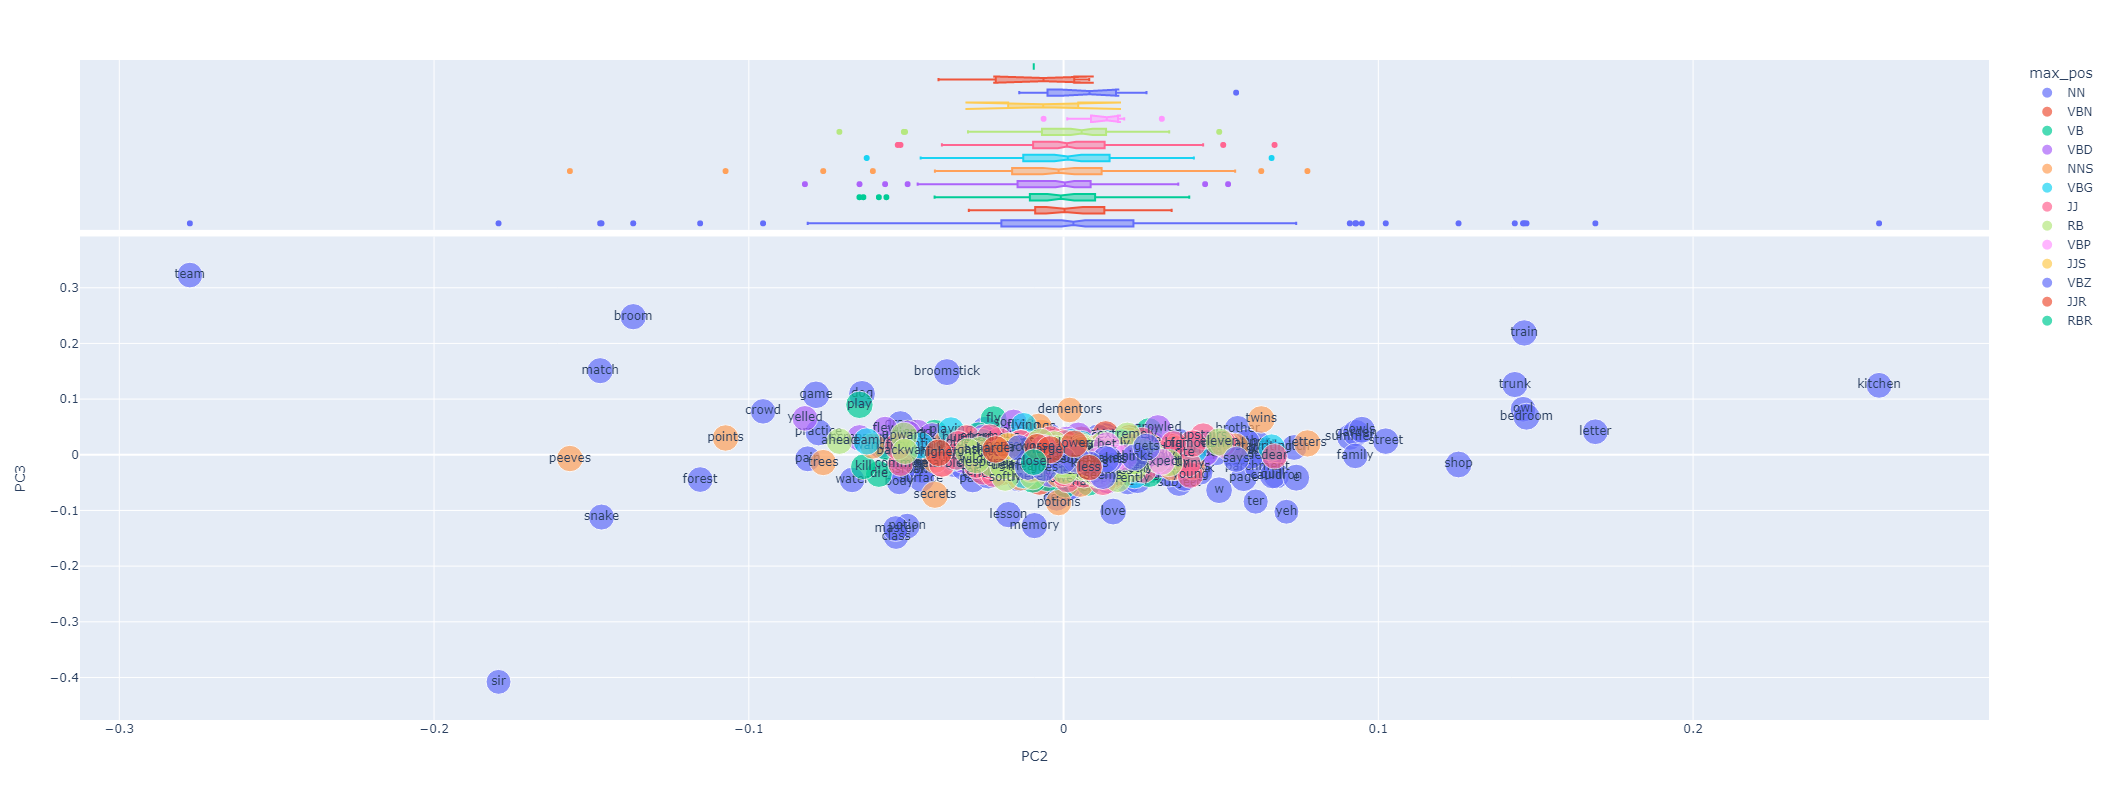

In [253]:
vis_loadings(2, 3)

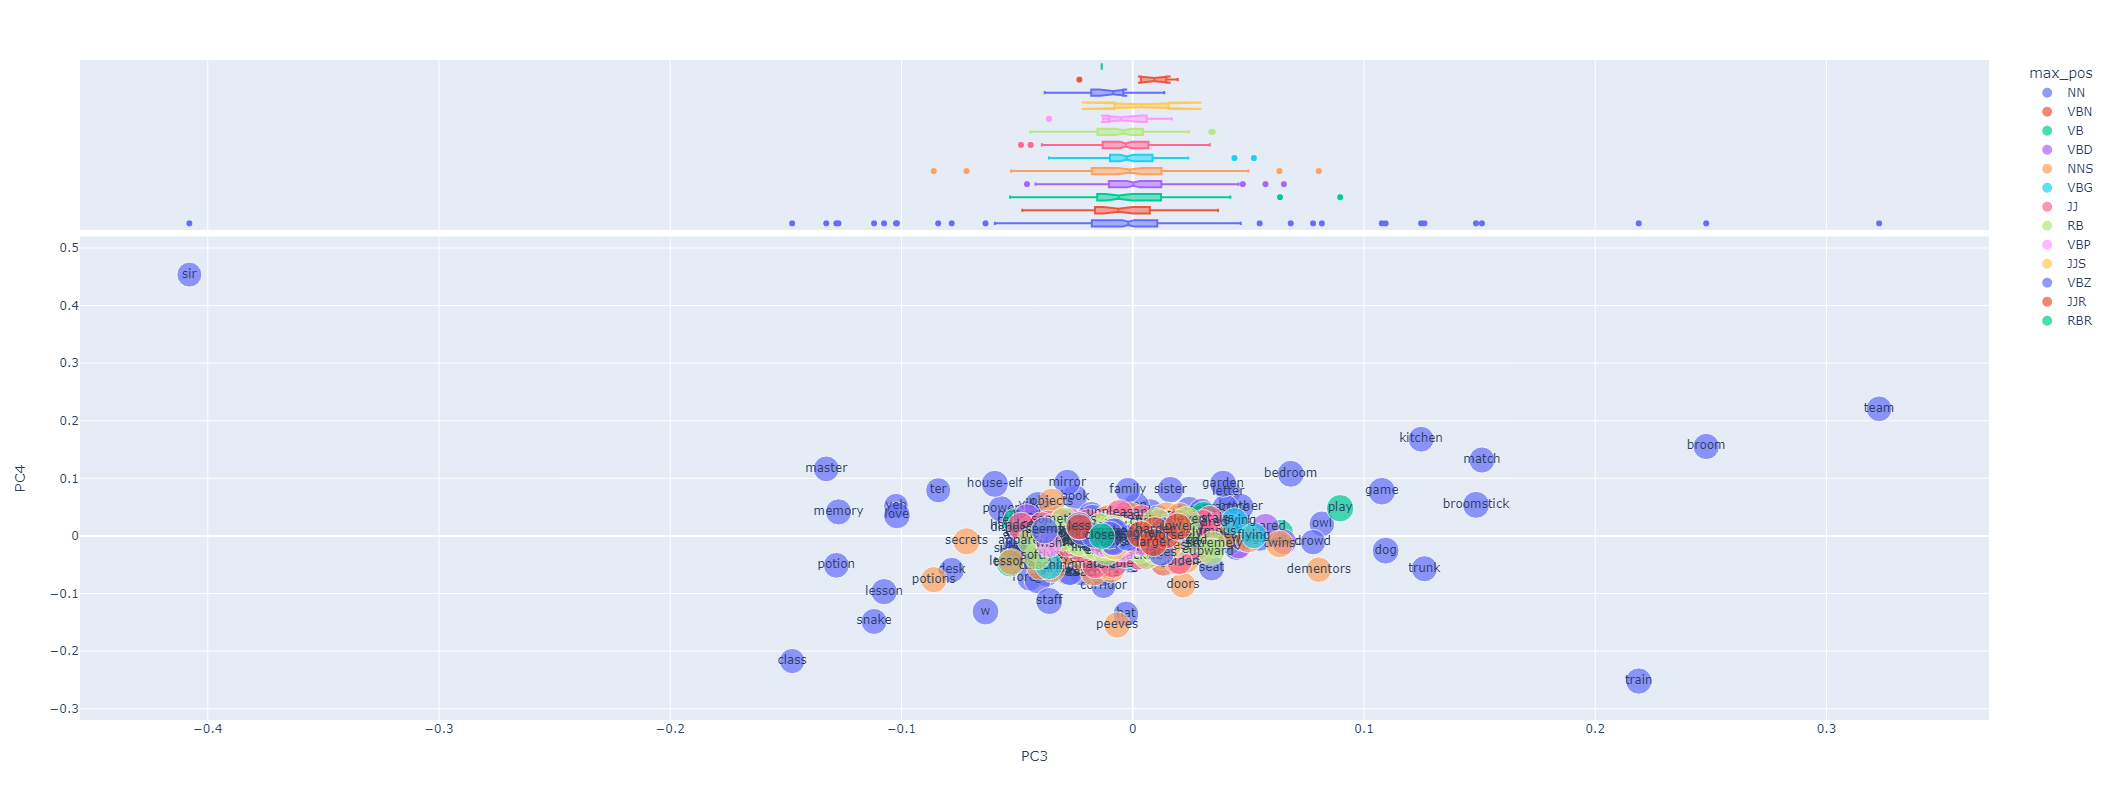

In [254]:
vis_loadings(3, 4) # the w as a word below comes from instances of a character saying "W - what?"

## t-SNE plot

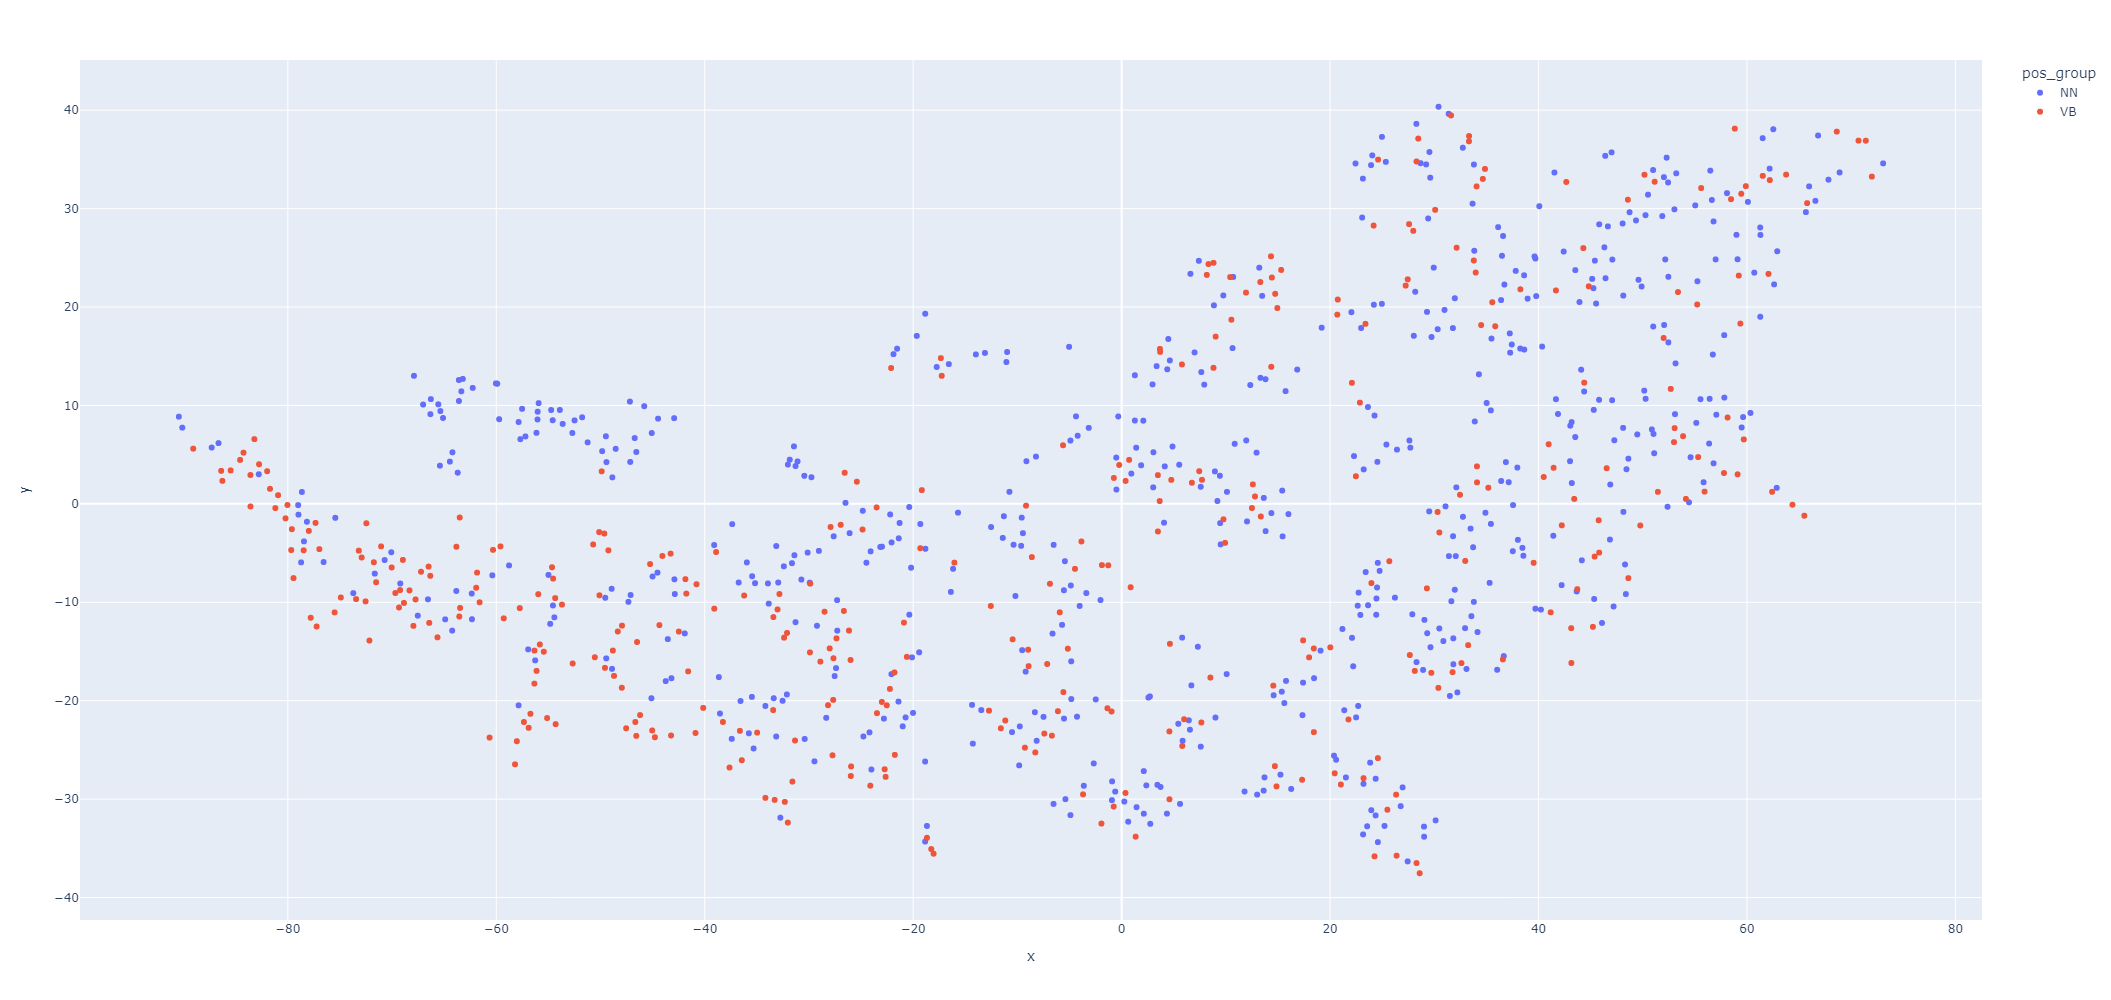

In [255]:
px.scatter(coords.reset_index(), 'x', 'y',  
           color='pos_group', 
           hover_name='term_str',          
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')